# Key Project Strategy Simulator - Gaia

In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
import healpy as hp
import random
import matplotlib.pyplot as plt
import csv
from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA import microlmodels
from pyLIMA import microlmagnification
from pyLIMA import microlsimulator
from pyLIMA import microltoolbox
from pyLIMA import microloutputs
import jplhorizons_utils
import visibility_utils
import healpixel_functions
from scipy import interpolate
import h5py
import copy

## Gaia Event Sky Locations

To start off with, let's start by simulating the set of Gaia events that we are likely to detect. 

The code skymap_events.py was previously used to map the events detected in Gaia Data Release 3 by Katarzyna, and convert this into a very rough map of event rate per year per HEALpixel (see code skymap_events.py).  This takes into account Gaia's time sampling, the distributions of stars, events and extinction, and Gaia's restricted limiting magnitude in crowded fields. 

In [2]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
hp.nside2resol(NSIDE, arcmin = True)/60.0

0.9161297098179749

In [3]:
map_file_path = 'gaia/gaia_event_rate.fits'
with fits.open(map_file_path) as hdul:
    data_table = hdul[1].data

coords = SkyCoord(data_table['RA'], data_table['Dec'], frame='icrs', unit=(u.hourangle, u.deg))

gaia_event_rate_table = Table([
                            Column(name="HP", data=data_table['hp_index'], dtype='int'),
                            Column(name="RA", data=data_table['RA'], dtype='str'),
                            Column(name="Dec", data=data_table['Dec'], dtype='str'),
                            Column(name="field_centre", data=coords),
                            Column(name="Gamma", data=data_table['gamma'], dtype='float'),
                            ])
gaia_event_rate_table

HP,RA,Dec,field_centre,Gamma
int64,str12,str12,object,float64
1,03:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (45., 89.26902778)>",0.0
2,09:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (135., 89.26902778)>",0.0
3,15:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (225., 89.26902778)>",0.0
4,21:00:00,+89:16:08.50,"<SkyCoord (ICRS): (ra, dec) in deg\n (315., 89.26902778)>",0.0
5,01:30:00,+88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (22.5, 88.53802778)>",0.0
6,04:30:00,+88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (67.5, 88.53802778)>",0.0
...,...,...,...,...
0,16:30:00,-88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (247.5, -88.53802778)>",0.0
0,19:30:00,-88:32:16.90,"<SkyCoord (ICRS): (ra, dec) in deg\n (292.5, -88.53802778)>",0.0


We need a smoother distribution function for events in RA, Dec.  We achieve this by downsampling the HEALpix map, then returning the map sampling to NSIDE=64. 

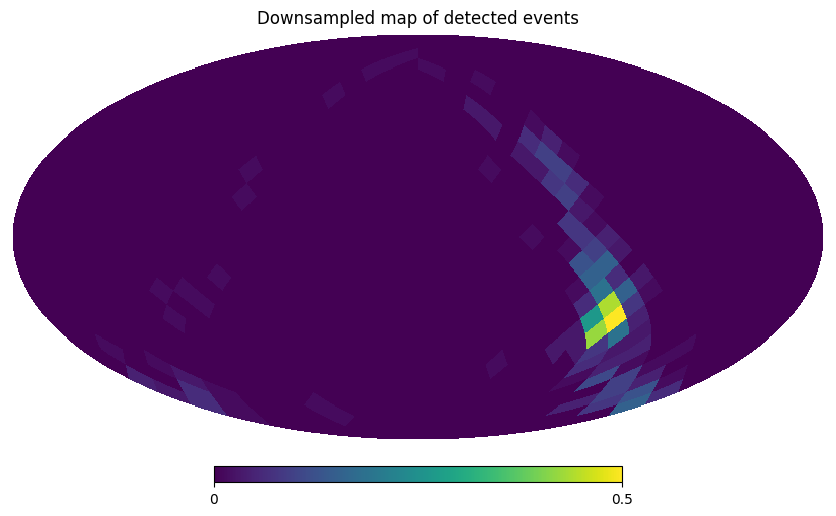

In [4]:
true_event_map = np.zeros(NPIX)
true_event_hp = np.where(gaia_event_rate_table['Gamma'] != 0.0)
true_event_map[true_event_hp] += 1.0

lores_true_event_map = hp.ud_grade(true_event_map, 8)
hp.mollview(lores_true_event_map, title='Downsampled map of detected events')
smooth_true_event_map = hp.ud_grade(lores_true_event_map, 64)

We want to draw a random sample of events, using this data to generate a realistic sample of where these targets will be located.  This should generate a list of HEALpixels where the simulated events are deemed to be located. 

In [5]:
n_samples = 1000
sim_event_hp = random.choices(np.arange(0,NPIX,1), weights=smooth_true_event_map, k=n_samples)

Now plot the original map of actual detected event positions and overplot the on-sky positions of the simulated event sample.

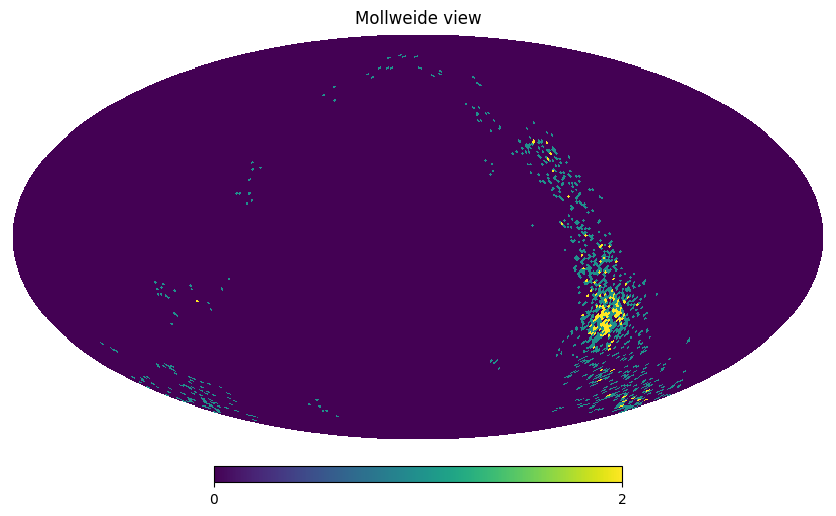

In [6]:
sim_event_map = np.zeros(NPIX)
sim_event_map[sim_event_hp] += 1.0

map_events = sim_event_map + true_event_map
hp.mollview(map_events)

Now convert the HEALpixel positions simulated for the sample of events to RA, Dec locations, assuming that the events are located at the HEALpixel centroids.  

In [7]:
sim_event_coords = gaia_event_rate_table['field_centre'][sim_event_hp]
sim_event_coords

"<SkyCoord (ICRS): (ra, dec) in deg\n (233.1, -52.80185278)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (280.546875, -9.59406667)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (322.03125, 39.45089444)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (269.296875, -34.22886389)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (289.6875, -7.78271389)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (223.23529167, -52.029725)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (260.15625, -41.01449722)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (284.0625, -16.33482222)>"
"<SkyCoord (ICRS): (ra, dec) in deg\n (157.5, -67.93492778)>"
...
"<SkyCoord (ICRS): (ra, dec) in deg\n (286.171875, 5.97915556)>"


## Gaia Event Baseline Magnitudes

Next we need to simulate the lightcurve data that Gaia would produce for these events.  

The first quantity we need is the baseline magnitude of the events.  We derive this by looking at the distribution of historic data from the Gaia Alerts system.  

In [8]:
def str2float(str):
    if len(str) > 0:
        return float(str)
    else:
        return -99.999

In [9]:
file_path = 'gaia/gaia_alerts_data.csv'
file_lines = open(file_path, 'r').readlines()
event_ids = []
data = []
for i,line in enumerate(file_lines):
    if i > 0:
        row = line.replace('\n','').split(',')
        event_ids.append(row[0])
        data.append([str2float(row[2]), str2float(row[3]), str2float(row[5]), str2float(row[6])])
data = np.array(data)

gaia_alert_table = Table([
                            Column(name="Event", data=event_ids, dtype='str'),
                            Column(name="RA", data=data[:,0], dtype='str'),
                            Column(name="Dec", data=data[:,1], dtype='str'),
                            Column(name="mag", data=data[:,2], dtype='float'),
                            Column(name="mag_error", data=data[:,3], dtype='float'),
                            ])
gaia_alert_table

Event,RA,Dec,mag,mag_error
str9,str32,str32,float64,float64
Gaia22epg,19.96019,-53.955,19.83,0.4
Gaia22epf,274.77416,-28.17701,19.55,0.05
Gaia22epe,273.40098,-29.60688,19.3,0.04
Gaia22epd,271.10083,-24.27362,18.34,0.36
Gaia22epc,14.69411,-56.98653,16.86,0.18
Gaia22epb,272.94736,-27.39745,18.11,0.06
...,...,...,...,...
Gaia14aag,219.14335,44.65261,18.42,0.02
Gaia14aaf,244.25381,62.00685,18.06,0.19


Text(0.5, 1.0, 'Distribution of baseline magnitudes of Gaia Alerts')

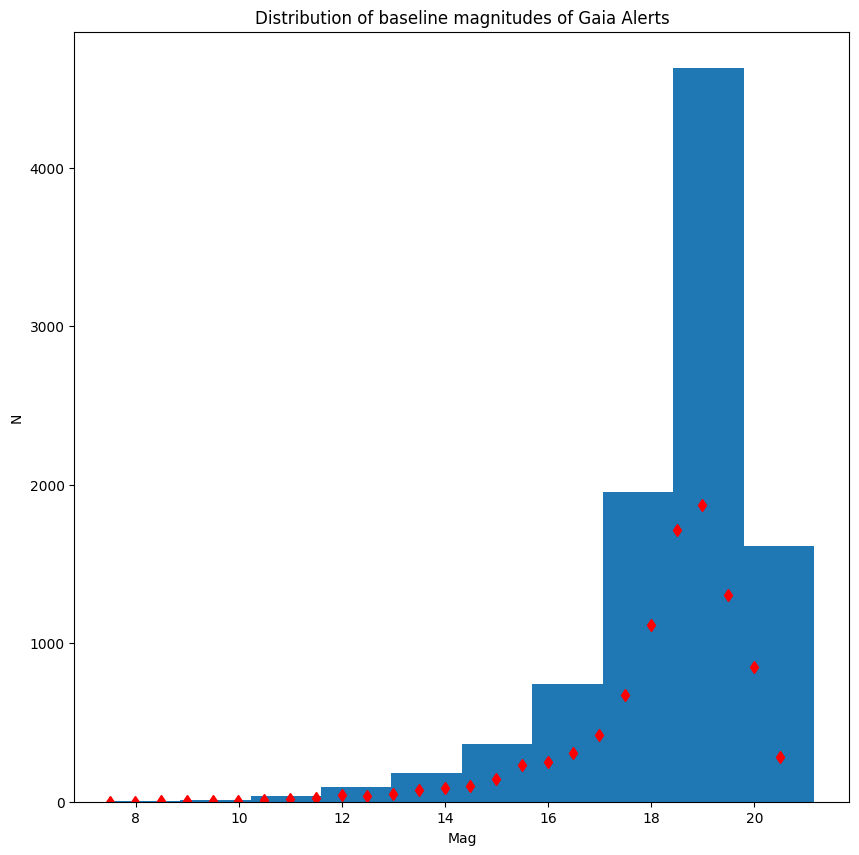

In [10]:
idx = np.where(gaia_alert_table['mag'] > 0.0)
mag_min = gaia_alert_table['mag'][idx].min()
mag_max = gaia_alert_table['mag'][idx].max()
(mag_dist, mag_bins) = np.histogram(gaia_alert_table['mag'][idx], bins=np.arange(mag_min, mag_max, 0.5))


fig = plt.figure(1,(10,10))
plt.hist(gaia_alert_table['mag'][idx])
plt.plot(mag_bins[0:-1], mag_dist, 'rd')
plt.xlabel('Mag')
plt.ylabel('N')
plt.title('Distribution of baseline magnitudes of Gaia Alerts')

Now we can use this distribution to simulate a realistic range of baseline magnitudes for Gaia detections

Text(0.5, 1.0, 'Distribution of simulated Gaia detections')

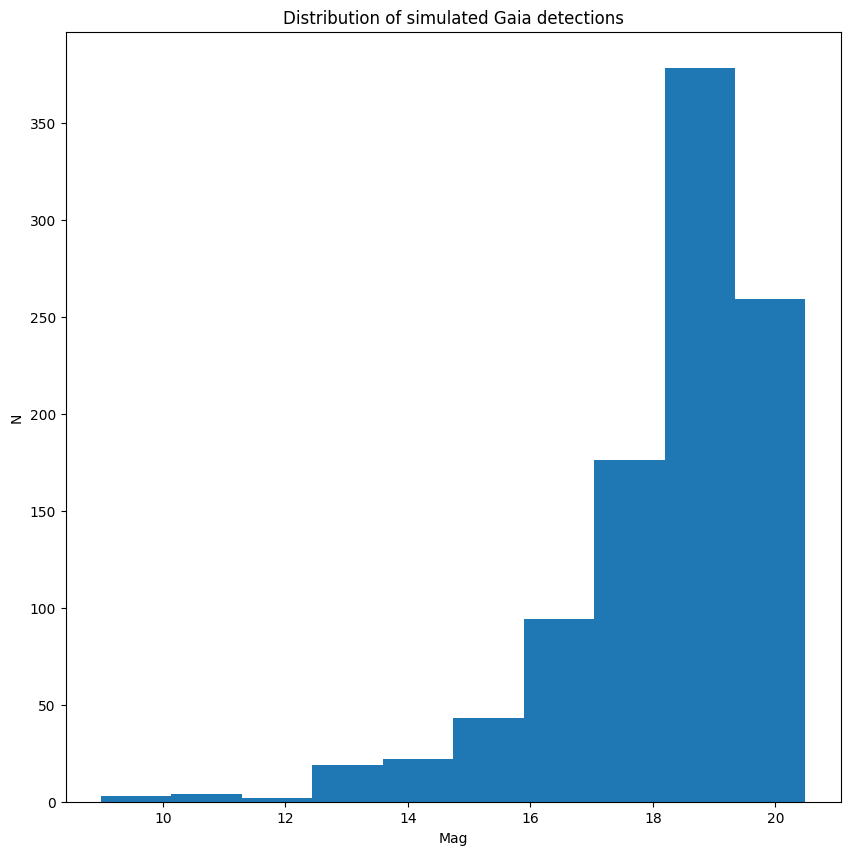

In [11]:
sim_event_mag = random.choices(mag_bins[0:-1], weights=mag_dist, k=n_samples)
fig = plt.figure(1,(10,10))
plt.hist(sim_event_mag)
plt.xlabel('Mag')
plt.ylabel('N')
plt.title('Distribution of simulated Gaia detections')

## Gaia Event Lensing Parameters

Next, we simulate a realistic range of microlensing event parameters.  We generate a timestamps array first, as the simulated events are constrained to have t0 within the range of the overlap between the Key Project (2023-2026) and Gaia's expected dates of operation (2023-2025):

In [12]:
# Time stamps are in Julian Date
start_date = 2460157.50000
end_date = 2460887.5000

In [13]:
def simulate_event_parameters(start_date, end_date, n_sample):
    """Based on code by Markus Hundertmark, adapted to simulate stellar and stellar remnant PSPL events
    within ranges likely to be detected by Gaia
    """
    event_parameters = []
    for i in range(0,n_sample, 1):
        t0 = np.random.uniform(start_date, end_date)
        u0 = np.random.normal(0.141993,0.312678)
        if u0>1:
            u0 = 1
        if  u0<-1:
            u0 = -1
        te = 10.**np.random.normal(1.455351,0.379810)
        rho = abs(np.random.normal(0.008303,0.013883))
        piEN = np.random.normal(0.164267,0.749409)
        piEE = np.random.normal(0.044996,0.259390)
        event_parameters.append([t0,u0,te,rho,piEN,piEE])
    event_parameters = np.array(event_parameters)
    
    return event_parameters

In [14]:
event_parameters = simulate_event_parameters(start_date, end_date, n_samples)
params_list = ['t0','u0','te','rho','piEN','piEE']

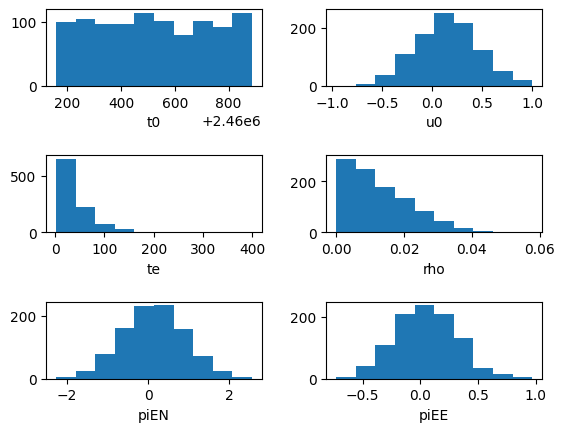

In [15]:
fig, axs = plt.subplots(3, 2)
plt.subplots_adjust(wspace=0.3,hspace=0.9)
idx = 0
for irow in range(0,3,1):
    for icol in range(0,2,1):
        axs[irow, icol].hist(event_parameters[:,idx])
        axs[irow, icol].set_xlabel(params_list[idx])
        idx += 1

Based on experience from previous year's of survey data, approximately 10% of events are binary lenses, which show anomalies, caustic crossings and other lightcurve features that need higher cadence observations in order to characterize them.  

To simulate this, and estimate the total amount of time this would require, ideally we would simulate a set of binary lens models but fitting a large sample of such events would be extremely time consuming.  Instead, we randomly nominate 50% of events in the table to be binaries, and use this flag to trigger more intensive observations over the event peak.  This effectively simulates the real-world observations that would be made of a subtle (planetary-style) anomaly. 

While binary stellar events often take longer (the gap between caustic entry and exit can be a few days), they do not need to be monitored as intensively the whole time.  Instead, intensive observations would be required over the caustic crossings, returning to moderate cadence in the gap.  The difference in the time requirements will be taken into account at a later stage.  

In [16]:
binaries = np.random.random_integers(0, n_samples-1, int(0.5*n_samples))
binary_index = np.zeros(n_samples, dtype=int)
binary_index[binaries] = 1

For ease of handling, let's combine these data into a single events table

In [17]:
def roundID(num):
    num = str(num)
    while (len(num) < 5):
        num = '0'+num
    return num

sim_event_names = []
for x in range(1,len(sim_event_hp)+1,1):
    sim_event_names.append('GaiaSim'+roundID(x))

In [18]:
events_table = Table([
                        Column(name="EventID", data=sim_event_names, dtype='str'),
                        Column(name="HP", data=sim_event_hp, dtype='int'),
                        Column(name="location", data=sim_event_coords),
                        Column(name="baseline_mag", data=sim_event_mag, dtype='str'),
                        Column(name="t0", data=event_parameters[:,0], dtype='float'),
                        Column(name="u0", data=event_parameters[:,1], dtype='float'),
                        Column(name="te", data=event_parameters[:,2], dtype='float'),
                        Column(name="rho", data=event_parameters[:,3], dtype='float'),
                        Column(name="piEN", data=event_parameters[:,4], dtype='float'),
                        Column(name="piEE", data=event_parameters[:,5], dtype='float'),
                        Column(name="nvisits", data=np.zeros(n_samples), dtype='float'),
                        Column(name="binary_lens", data=binary_index, dtype='int'),
                        ])
events_table

EventID,HP,location,baseline_mag,t0,u0,te,rho,piEN,piEE,nvisits,binary_lens
str12,int64,object,str32,float64,float64,float64,float64,float64,float64,float64,int64
GaiaSim00001,44181,"<SkyCoord (ICRS): (ra, dec) in deg\n (233.1, -52.80185278)>",17.490000000000002,2460803.3398455344,0.13680073863732767,39.88570303841847,0.012939712500705337,-1.0424980589462876,0.2945141501204799,0.0,1
GaiaSim00002,28743,"<SkyCoord (ICRS): (ra, dec) in deg\n (280.546875, -9.59406667)>",18.490000000000002,2460716.8993212455,0.1394321773561388,12.16687949351455,0.009747815794934429,-0.3068398540496694,-0.2905539482927927,0.0,1
GaiaSim00003,9061,"<SkyCoord (ICRS): (ra, dec) in deg\n (322.03125, 39.45089444)>",20.490000000000002,2460417.7349421475,0.2042518227553263,22.140174960530672,0.03047607680406219,0.725057907935633,-0.35906964275548503,0.0,0
GaiaSim00004,38463,"<SkyCoord (ICRS): (ra, dec) in deg\n (269.296875, -34.22886389)>",18.490000000000002,2460689.2371116197,-0.09676316304564636,9.59744053670669,0.02556108609007003,0.6513007670479256,0.005286983299623307,0.0,0
GaiaSim00005,27982,"<SkyCoord (ICRS): (ra, dec) in deg\n (289.6875, -7.78271389)>",18.990000000000002,2460797.2159754112,0.3820921975786873,23.20677469306169,0.0008926765479274137,0.8143022709417136,-0.31871393331801573,0.0,0
GaiaSim00006,43974,"<SkyCoord (ICRS): (ra, dec) in deg\n (223.23529167, -52.029725)>",13.99,2460856.7808350236,0.2490153019924247,43.7507314569636,0.019114597573638384,1.4346987898823182,-0.003914165169148359,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
GaiaSim00994,37187,"<SkyCoord (ICRS): (ra, dec) in deg\n (274.21875, -30.69158611)>",18.990000000000002,2460390.7865557247,0.17323270263275145,10.822236239629271,0.007477827460337141,-0.2551396343273372,-0.14080748196084125,0.0,1
GaiaSim00995,29261,"<SkyCoord (ICRS): (ra, dec) in deg\n (288.984375, -10.80692222)>",18.490000000000002,2460320.4286059993,0.19639642661557632,6.076497362952367,0.02676227427967056,0.12090198437146313,0.07189170324366059,0.0,1


### Blending

Note that we implicitly assume zero blending from background stars in the photometry for Gaia events.  Analysis offline has shown that this is a reasonable approximation for events outside the galactic centre, which are the majority of Gaia events. 



## Gaia Event Lightcurve sampling

In order to generate realistic Gaia lightcurves, we take into account the non-uniform map of visits that results from Gaia's scanning law. We read in this data, which was resampled using the gaia/gaia_scanning_law notebook, and output to file gaia/gaia_dr3_nvisits_34months.fits.  Since Gaia is expected to continue operating for 24months during the Key  Project, we scale the expected number of visits per HEALpixel accordingly.  

In [19]:
gaia_duration = 34*30.0
gaia_kp_overlap = 365.24*2.0
scale_factor = gaia_kp_overlap / gaia_duration
scale_factor

0.716156862745098

In [20]:
map_file_path = 'gaia/gaia_dr3_nvisits_34months.fits'
with fits.open(map_file_path) as hdul:
    data_table = hdul[1].data

gaia_nvisits = Table([
                        Column(name="HP", data=data_table['hp_index'], dtype='int'),
                        Column(name="nvisits", data=data_table['nvisits']*scale_factor, dtype='int'),
                        ])
gaia_nvisits

HP,nvisits
int64,int64
1,221
2,226
3,219
4,219
5,232
6,222
...,...
49146,224
49147,230


Assign the numbers of visits to each simulated event, based on the HEALpixel where it was detected, and add this to the events_table.  

In [21]:
events_table['nvisits'] = gaia_nvisits['nvisits'][events_table['HP']-1]  # Off-by-one to match Python's number-from-zero
events_table

EventID,HP,location,baseline_mag,t0,u0,te,rho,piEN,piEE,nvisits,binary_lens
str12,int64,object,str32,float64,float64,float64,float64,float64,float64,int64,int64
GaiaSim00001,44181,"<SkyCoord (ICRS): (ra, dec) in deg\n (233.1, -52.80185278)>",17.490000000000002,2460803.3398455344,0.13680073863732767,39.88570303841847,0.012939712500705337,-1.0424980589462876,0.2945141501204799,175,1
GaiaSim00002,28743,"<SkyCoord (ICRS): (ra, dec) in deg\n (280.546875, -9.59406667)>",18.490000000000002,2460716.8993212455,0.1394321773561388,12.16687949351455,0.009747815794934429,-0.3068398540496694,-0.2905539482927927,110,1
GaiaSim00003,9061,"<SkyCoord (ICRS): (ra, dec) in deg\n (322.03125, 39.45089444)>",20.490000000000002,2460417.7349421475,0.2042518227553263,22.140174960530672,0.03047607680406219,0.725057907935633,-0.35906964275548503,279,0
GaiaSim00004,38463,"<SkyCoord (ICRS): (ra, dec) in deg\n (269.296875, -34.22886389)>",18.490000000000002,2460689.2371116197,-0.09676316304564636,9.59744053670669,0.02556108609007003,0.6513007670479256,0.005286983299623307,133,0
GaiaSim00005,27982,"<SkyCoord (ICRS): (ra, dec) in deg\n (289.6875, -7.78271389)>",18.990000000000002,2460797.2159754112,0.3820921975786873,23.20677469306169,0.0008926765479274137,0.8143022709417136,-0.31871393331801573,108,0
GaiaSim00006,43974,"<SkyCoord (ICRS): (ra, dec) in deg\n (223.23529167, -52.029725)>",13.99,2460856.7808350236,0.2490153019924247,43.7507314569636,0.019114597573638384,1.4346987898823182,-0.003914165169148359,265,1
...,...,...,...,...,...,...,...,...,...,...,...
GaiaSim00994,37187,"<SkyCoord (ICRS): (ra, dec) in deg\n (274.21875, -30.69158611)>",18.990000000000002,2460390.7865557247,0.17323270263275145,10.822236239629271,0.007477827460337141,-0.2551396343273372,-0.14080748196084125,99,1
GaiaSim00995,29261,"<SkyCoord (ICRS): (ra, dec) in deg\n (288.984375, -10.80692222)>",18.490000000000002,2460320.4286059993,0.19639642661557632,6.076497362952367,0.02676227427967056,0.12090198437146313,0.07189170324366059,111,1


Store the table of simulated event parameters

In [22]:
hdr = fits.Header()
hdr['NEVENTS'] = len(events_table)
phdu = fits.PrimaryHDU(header=hdr)

ra = np.array([x.ra.deg for x in events_table['location']])
dec = np.array([x.dec.deg for x in events_table['location']])

column_list = []
column_list.append(fits.Column(name='EventID', array=events_table['EventID'], format='A14'))
column_list.append(fits.Column(name='HEALpixel', array=events_table['HP'], format='I8'))
column_list.append(fits.Column(name='RA_deg', array=ra, format='E'))
column_list.append(fits.Column(name='Dec_deg', array=dec, format='E'))
column_list.append(fits.Column(name='baseline_mag', array=events_table['baseline_mag'], format='E'))
column_list.append(fits.Column(name='t0', array=events_table['t0'], format='E'))
column_list.append(fits.Column(name='u0', array=events_table['u0'], format='E'))
column_list.append(fits.Column(name='tE', array=events_table['te'], format='E'))
column_list.append(fits.Column(name='rho', array=events_table['rho'], format='E'))
column_list.append(fits.Column(name='piEN', array=events_table['piEN'], format='E'))
column_list.append(fits.Column(name='piEE', array=events_table['piEE'], format='E'))
column_list.append(fits.Column(name='nvisits_gaia', array=events_table['nvisits'], format='I5'))
column_list.append(fits.Column(name='binary_lens', array=events_table['binary_lens'], format='I1'))
hdu = fits.BinTableHDU.from_columns(column_list)

hdul = fits.HDUList([phdu,hdu])
hdul.writeto('./sim_gaia_events_table.fits', overwrite=True)


## Gaia Event Lightcurves

Now we can simulate the lightcurves that Gaia would produce for these simulated events.  Although the scanning law data does not tell us the distribution of visits over the 34 months included in Gaia DR3, it is a regularly repeating function with a non-varying scan from a space-based facility.  The sampling isn't uniform, but we approximate it here as uniform, since experiments with the Gaia scanninglaw package failed due to out of date documentation.  

In [23]:
def add_gaia_g_noise(mag):
    """Code by Markus Hundertmark
    """
    a1 = 0.2
    b1 = -5.3 #-5.2
    a2=0.2625
    b2= -6.3625 #-6.2625

    mag_obs_list = []
    magerr_list = []

    for value in mag:
        log_err1 = a1*value + b1
        log_err2 = a2*value + b2
        if (value < 13.5):
            magerr = 10**(a1*13.5+b1)
            magerr_list.append(magerr)
            mag_obs = np.random.normal(value, magerr)
            mag_obs_list.append(mag_obs)
        if value>=13.5 and value<17:
            magerr = 10**log_err1
            magerr_list.append(magerr)
            mag_obs = np.random.normal(value, magerr)
            mag_obs_list.append(mag_obs)
        if (value>=17):
            magerr = 10**log_err2
            magerr_list.append(magerr)
            mag_obs = np.random.normal(value, magerr)
            mag_obs_list.append(mag_obs)
        #this works until 21 mag.
    return np.array(mag_obs_list), np.array(magerr_list)

In [24]:
def simulate_event_gaia(event_params, start_date, end_date, horizons_table, parallax=True):
    """Expects parameters from an entry in the events_table above.
    """
    
    # Simulate timestamps
    cadence = (end_date - start_date) / event_params['nvisits']
    timestamps = np.arange(start_date, end_date, cadence)
    
    # Create a PyLIMA event object
    sim_event = event.Event()
    sim_event.name = event_params['EventID']
    sim_event.ra = float(event_params['location'].ra.deg)
    sim_event.dec = float(event_params['location'].dec.deg)

    # Generate a constant lightcurve at the event's baseline magnitude, with fixed photometric uncertainties, 
    # since these will be replaced later
    lc = np.zeros((len(timestamps),3))
    lc[:,0] = timestamps
    lc[:,1] = [float(event_params['baseline_mag'])] * len(timestamps)
    lc[:,2] = [0.01] * len(timestamps)
    print(float(event_params['baseline_mag']), np.median(lc[:,1]))
    
    # Add a PyLIMA telescope object to the event with this lightcurve, and add it to the event
    tel = telescopes.Telescope(name='Gaia', camera_filter='G',
                                     spacecraft_name = 'Gaia',
                                     light_curve_magnitude=lc,
                                     location='Space',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)

    # For spacecraft parallax, need to append the spacecraft_positions table here
    spacecraft_positions = jplhorizons_utils.calc_spacecraft_positions_observer_table(horizons_table,
                                                                                    event_params['t0'])
    tel.spacecraft_positions = spacecraft_positions
    
    sim_event.telescopes.append(tel)
    sim_event.find_survey('Gaia')
    
    # Add a PyLIMA model to the event, using the simulated parameters
    if parallax:
        sim_model = microlmodels.create_model('FSPL', sim_event,
                                          parallax=['Full',float(event_params['t0'])])
        lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                              float(event_params['rho']), float(event_params['piEN']), float(event_params['piEE'])]
        
    else:
        sim_model = microlmodels.create_model('FSPL', sim_event)
        lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                          float(event_params['rho'])]
        
    sim_model.define_model_parameters()
    
    if parallax:
        sim_model.event.compute_parallax_all_telescopes(sim_model.parallax_model)
        
    tel = sim_model.event.telescopes[0]
    
    pylima_parameters = sim_model.compute_pyLIMA_parameters(lensing_parameters)
    #print(event_params)
    
    # Use the PyLIMA model to add a lensing event into the lightcurve
    magnification = sim_model.model_magnification(tel, pylima_parameters)
    A = sim_model.model_magnification(tel,pylima_parameters)
    
    lightcurve = sim_event.telescopes[0].lightcurve_magnitude
    lightcurve[:,1] = lightcurve[:,1] + -2.5*np.log10(A)
    (lightcurve[:,1],lightcurve[:,2]) = add_gaia_g_noise(lightcurve[:,1])
    sim_event.telescopes[0].lightcurve_magnitude = lightcurve
    print(float(event_params['baseline_mag']), np.median(lightcurve[:,1]))
    
    return sim_event, sim_model, lensing_parameters

In order to implement parallax for Gaia events, we use the projected vector locations of the spacecraft, as generated by JPL Horizons, and output to an ASCII table which can be read from file.  
The JPL Horizons configuration used to generate this table is:
* Ephemeris type: Vector table
* Target body: Gaia (spacecraft)
* Coordinate center: Solar System Barycenter SSB [500@0]
* Time: 2023-01-01 to 2026-08-30, increments of 1 day (duration of Key Project)
* Table settings: default

However, this appears not to be the format required to calculate the observed location of the spacecraft.  Instead it needs the RA, Dec position, meaning that the observer table format is required, with the following options:
* Astrometric RA & Dec
* Rates RA & Dec
* Airmass and extinction (required)
* Visual mag & surface brightness
* Heliocentric range and range rate
* Observer range and range rate
* Sun-Observer-Target ELONG angle
* Sun-Target-Observer PHASE angle
* Local apparent hour angle
* Sky motion
* Lunar sky brightness

In [25]:
gaia_vector_table_file = './gaia/jplhorizons_observer_table.txt'

horizons_table = jplhorizons_utils.parse_JPL_Horizons_table(horizons_file_path=gaia_vector_table_file, 
                                                                   table_type='OBSERVER')
horizons_table

Date,RA,Dec,Delta,JD
bytes16,float64,float64,float64,float64
2023-Jan-01T00:0,101.31470833333333,22.988694444444445,0.99424530711027,2459945.5
2023-Jan-02T00:0,102.41991666666667,22.90411111111111,0.99437003596059,2459946.5
2023-Jan-03T00:0,103.52370833333335,22.811972222222224,0.99450009481111,2459947.5
2023-Jan-04T00:0,104.625875,22.712305555555556,0.9946354327103,2459948.5
2023-Jan-05T00:0,105.72629166666665,22.605194444444447,0.99477599538272,2459949.5
2023-Jan-06T00:0,106.82491666666667,22.49063888888889,0.99492172842485,2459950.5
...,...,...,...,...
2026-Aug-22T00:0,330.5357916666667,-12.060194444444445,1.02354688405442,2461274.5
2026-Aug-23T00:0,331.45425,-11.725111111111111,1.02327762396697,2461275.5


In [26]:
# Pick a bright event as a test case:
event_number = 0
while (float(events_table[event_number]['baseline_mag']) > 18.0):
    event_number += 1
print('Picked bright event: ',event_number,' baseline_mag=',events_table[event_number]['baseline_mag'],'mag')

gaia_lens, gaia_lens_model, lens_model_pars = simulate_event_gaia(events_table[event_number], start_date, end_date, horizons_table, parallax=True)

Picked bright event:  0  baseline_mag= 17.490000000000002 mag
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.484016295445347


Simulate all events

In [27]:
sim_gaia_lenses = []
sim_gaia_lens_models = []
sim_model_params = []

for ievent in range(0,len(events_table),1):
    (gaia_lens, gaia_lens_model, lens_model_pars) = simulate_event_gaia(events_table[ievent], start_date, end_date, horizons_table, parallax=True)
    sim_gaia_lenses.append(gaia_lens)
    sim_gaia_lens_models.append(gaia_lens_model)
    sim_model_params.append(lens_model_pars)
    print(ievent, sim_model_params[-1])

17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.48193230329353
0 [2460803.3398455344, 0.13680073863732767, 39.88570303841847, 0.012939712500705337, -1.0424980589462876, 0.2945141501204799]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.489305094404692
1 [2460716.8993212455, 0.1394321773561388, 12.16687949351455, 0.009747815794934429, -0.3068398540496694, -0.2905539482927927]
20.490000000000002 20.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
20.490000000000002 20.47894358410666
2 [2460417.7349421475, 0.2042518227553263, 22.140174960530672, 0.03047607680406219, 0.725057907935633, -0.35906964275548503]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.49111045814301
3 [2460689.2371116197, -0.09676316304564636, 9.59744053670669, 0.02556108609007003, 0.65130076

Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.490000000000002 16.464884325924906
38 [2460701.252577721, 0.6388735173504367, 50.046018000108425, 0.002865261192537505, -0.6046152773417868, 0.40183923038495795]
15.49 15.49
Parallax(Full) estimated for the telescope Gaia: SUCCESS
15.49 15.488699388068849
39 [2460198.0112236473, -0.2792485859537486, 19.649836164961286, 0.0005105273897734498, 0.7280284807019346, 0.25799983124778847]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.978569560591456
40 [2460336.9257605267, -0.529800465701327, 21.401840681562845, 0.017383421544657912, 0.2552165875663403, -0.1509195294063822]
16.990000000000002 16.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.990000000000002 16.98047530629166
41 [2460747.428069849, 0.6654178066203505, 72.02453037246313, 0.009578530158690942, -0.7051181268013524, 0.4394624517630483]
18.990000000000002 18.990000000000002


Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.990000000000002 16.978323738744052
74 [2460755.17852616, 0.10642850945375171, 43.861045868228445, 0.029046519818991784, 0.039723380227806415, 0.06175725763547392]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.477641311779838
75 [2460569.6235599373, 0.03196377025074232, 17.89496976330002, 0.012236400534981855, 0.4542211669306805, -0.21877459244127997]
16.990000000000002 16.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.990000000000002 16.987199556104812
76 [2460773.812305542, -0.12026068976799323, 16.83753845290117, 0.017490361994927834, -1.2213501882275024, -0.1572769790000363]
20.490000000000002 20.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
20.490000000000002 20.455871771923114
77 [2460235.2468143697, 0.185193622919983, 32.213347755767835, 0.03448539739375419, 1.1711082156415107, 0.0259545608130519

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.49058237585082
110 [2460306.681222738, -0.12694318881885894, 3.881645228249662, 0.01306100513687054, 1.4384187329482243, -0.0911861641011136]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.930364952092845
111 [2460642.446502483, -0.1504502648562188, 85.84017115925035, 0.0013316260344264164, 0.1744205770663253, -0.0848359104117977]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.970047657655623
112 [2460841.5520082256, 0.11588508091733793, 246.27040241637502, 0.007442438897165119, 1.497251055898032, -0.024345640346482476]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.489051769333436
113 [2460158.414576689, 0.043631127818713034, 9.978464578176716, 0.010444089950378621, 0.19208373760501204, 0.035177303609

Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.479446757147898
151 [2460552.2141575315, 0.09884729527691574, 32.930819716460014, 0.002455369526525181, 0.21408623890235243, 0.22369753295215908]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.47279516160074
152 [2460275.1420791987, 0.12643571805395767, 66.68459711439202, 0.011145479833495385, 0.8660142232244752, 0.04660882087635736]
19.990000000000002 19.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.981855063952487
153 [2460358.2373011876, 0.13928494744987713, 14.709068422098358, 0.014666491217740937, -0.3061777456342251, -0.08587594414055383]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.486711389095507
154 [2460352.9154131156, 0.058597963245055604, 21.085235541051468, 0.012458525604211124, 1.1456835560935008, -0.364560

Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.48469468576081
187 [2460475.7713158648, -0.31272531793834035, 17.63796666573136, 0.0578350568475393, -0.1767334032499442, 0.7042390868011832]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.464557774088945
188 [2460800.803898681, -0.014875253092017038, 30.559886450325795, 0.007875702785514844, 0.6327203031398156, 0.21814478712283572]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.47756980381758
189 [2460279.112382952, 0.5955381006237702, 52.030868551906444, 0.028030738712448953, -0.7869441231118544, 0.016269645091279827]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.87520763246524
190 [2460737.9680936174, 0.31810925761395403, 72.68751606395563, 0.019805838213376628, 0.4967853028166261, -0.0966411510700

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.97937295009605
226 [2460395.4488099874, 0.3295570432355408, 108.35498386575938, 0.03287701627012521, -1.642121965092228, 0.11792438572904351]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.410451627212097
227 [2460421.850134822, 0.1951479705141362, 73.26810642015589, 0.010160553975145056, 0.22060906547795817, -0.12019112714683766]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.980624571689884
228 [2460221.4461034355, 0.5933730420235143, 26.918635796661153, 0.0044256139080552075, -0.4481776200520005, 0.048568232284293855]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.966820475139613
229 [2460770.849465637, -0.04038308875390309, 51.33964939600336, 0.021773546991891032, 1.0210200241983487, 0.006149127345

Parallax(Full) estimated for the telescope Gaia: SUCCESS
20.490000000000002 20.47428545654332
259 [2460336.3987878985, -0.03638088027800687, 23.601437971624282, 0.021622438112868084, 1.082844887609471, 0.017789705695995715]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.453070820775146
260 [2460503.3853034084, 0.04571765851014818, 64.92715809759974, 0.01755628922895037, -0.5665109873329377, 0.16284957723784102]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.485497493040242
261 [2460193.146991462, 0.39752450266291206, 32.95714540449552, 0.007442368399437633, 0.569277156942298, -0.011974193702449148]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.47815906267921
262 [2460199.930676928, 0.5864804252673842, 80.89087985471323, 0.02486782299948337, 0.4663876400444508, 0.2332321674294787

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.478470619012825
297 [2460294.2435759096, 0.12352486140550056, 29.847182336151988, 0.0027917669331232594, 0.2022347359448037, 0.16959831053474467]
15.99 15.99
Parallax(Full) estimated for the telescope Gaia: SUCCESS
15.99 15.988008240123294
298 [2460287.0309465537, -0.25672867054835335, 17.84155076984229, 0.010691023317515888, -0.2813350916791112, -0.2579215910677985]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.959068581502276
299 [2460247.4586963677, 0.07302084268748794, 75.27641417307638, 0.020023577152019724, -0.22958866999011035, -0.21462578710171445]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.484862565363933
300 [2460589.805999986, 0.1767975664687803, 12.10999006028903, 0.00099339120733431, 0.2539055012012985, -0.0830323201393644]
18.990000000000002 18.9900000

13.99 13.985733053366769
336 [2460202.190699229, -0.3237474118240683, 87.31785016085284, 0.03811935358446442, -0.8659486494947994, -0.7278581476866558]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.45277451127984
337 [2460281.530145226, 0.07776156892190547, 93.6658796377237, 0.001564964705760956, 0.37852986776378195, -0.0740633629744786]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.47082552147613
338 [2460541.820794696, 0.18837538065558596, 72.40345076264552, 0.013974024475715439, 0.7201320572929537, 0.6001326230247805]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.978438618797867
339 [2460435.705515673, 0.03702464263203052, 17.157882308957667, 0.022851076227057385, -0.4096993287853908, -0.1643460510756143]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for th

18.490000000000002 18.44424121732201
375 [2460873.7060588845, 0.237985646908, 121.0438984159168, 0.003278288687354851, -0.17952479734876964, -0.11871174659466577]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.971353450657922
376 [2460606.3320346223, 0.41649982688006293, 22.61631724498128, 0.017265691931131907, 0.5584381427867642, -0.030873012879398927]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.463785716088623
377 [2460674.017613886, 0.16307020228087535, 55.147013754633235, 0.007959745961809116, 1.3961652660587225, -0.2797391246868334]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.47760069176936
378 [2460592.5166451083, 1.0, 46.41006394105809, 0.015782316547170227, 0.9114350290546598, -0.18351035264359702]
13.99 13.99
Parallax(Full) estimated for the telescope Gaia: SUCCESS

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.494287853281666
415 [2460382.8494390566, 0.14471916843253477, 11.771132581973188, 0.002551226216824837, 0.1755633532648271, 0.023137559193519588]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.958601295700582
416 [2460283.745137512, -0.05868139624708971, 87.38965531120381, 0.0027235714652182434, 0.6327446321038499, -0.33257613571977185]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.977036212672886
417 [2460213.719255211, 0.4385575739513434, 32.474943342228386, 0.025394828039924114, -0.6341764819158258, -0.4712385859787304]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.978051873037874
418 [2460579.813927855, -0.25386049725051396, 29.55978994999024, 0.017635530495657567, 0.09530015354613923, -0.2533395

Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.353166296678644
454 [2460475.064192266, 0.3179619532264546, 75.86984009811133, 0.00455324338256388, -0.09284012390751756, -0.3214572094493589]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.98948786942927
455 [2460632.467334929, 0.1933716362075158, 7.788838226018009, 0.024546213093500725, 0.2881985125221812, -0.11323516604436376]
14.99 14.99
Parallax(Full) estimated for the telescope Gaia: SUCCESS
14.99 14.986156217564014
456 [2460609.9008413353, 0.10513711368122111, 17.27487088004151, 0.006074028249953008, 1.104049603918098, -0.036563148569408975]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.973477972695207
457 [2460850.6263677664, -0.6133032221472237, 29.06730868852296, 0.005549827615299308, 0.2964594857379681, 0.12133353080001352]
17.490000000000002 17.4900000000000

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.404633213741096
494 [2460510.90385911, 0.7430489547803324, 96.82953607085551, 0.01810889873177321, 0.1454441156671182, 0.09071845675497892]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.982926907647318
495 [2460286.0422067335, 0.7181074714128565, 24.244646114841654, 0.0037635798256605507, 1.020503063046151, 0.07671156315078945]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.461359310357043
496 [2460447.1484954823, -0.2993246425071031, 37.51659255754043, 0.017868655620023856, 0.5993118522270554, 0.14092220188999216]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.988672658156617
497 [2460475.9021937577, 0.2886083024838124, 4.834909678940898, 0.010191028445753725, -0.968509567669096, -0.1558266918469991]

Parallax(Full) estimated for the telescope Gaia: SUCCESS
15.49 15.487454392625713
533 [2460430.659680144, -0.3917267173525657, 18.578080851737795, 0.025172389975890885, 0.10440623125752194, 0.4779420941117383]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.99390173721107
534 [2460207.2322368408, 0.02535554451559492, 13.453650646801844, 0.008449253017207852, -0.5940306266434401, 0.3436964907158734]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.474512966316208
535 [2460406.3609459857, 0.29485852493670106, 38.5498705313953, 0.027578283400076377, 0.5420451189404092, 0.10651562228370681]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.97126796376891
536 [2460400.921942805, 0.7533321313891536, 26.958504138741013, 0.00029271904621314127, 0.6149554251710019, 0.20410182219889447]
16.99000

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.483982428115787
572 [2460456.1903501437, 0.0907368385764189, 28.450972817636885, 0.0046827597346190825, 0.3977150145162385, -0.0681400119083519]
16.990000000000002 16.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.990000000000002 16.986218791325186
573 [2460805.5098342346, -0.004161024092217497, 20.745160004250536, 0.021511225576737333, -0.07949961199334246, 0.08575062802952713]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.479390897497666
574 [2460635.5753754796, 0.5792960333143804, 19.151633817234025, 0.016833440548730087, -0.12191697448962852, -0.11142712407978067]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.427499139875238
575 [2460760.398476655, -0.05273772301206678, 46.2915457110062, 0.018329175095266693, 1.4319023172121903, -0.0743

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.467712908624012
612 [2460594.4355412265, -0.226944723246969, 42.054701141891115, 0.011978721262700635, 0.08031728346995803, 0.06867880015591403]
16.490000000000002 16.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.490000000000002 16.483176878523636
613 [2460581.024937519, -0.08179751335316104, 24.465501790453082, 0.024863209545861686, -0.15049419386465535, -0.0695287730857132]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.47481235707391
614 [2460563.8057733015, -0.008460456250172221, 26.571909214018387, 0.00978371813678852, 0.8349145401693374, -0.0677904851209378]
13.99 13.99
Parallax(Full) estimated for the telescope Gaia: SUCCESS
13.99 13.987184594741947
615 [2460371.7972508953, 0.48943832835177836, 28.3608979627243, 0.0208822671524351, -0.10099795550579688, 0.08451623772403744]
17.490000000000002 17.4900000

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.974848702919154
655 [2460725.534518098, 0.6603464210668475, 32.85011836181107, 0.015723986383199592, 1.0509148950619647, -0.14479789839131155]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.479840560564863
656 [2460514.180264632, 0.08146093629327167, 22.56816423859399, 0.027319811435378663, 0.1480368061868491, -0.2642741169216594]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.479084903336858
657 [2460802.5377741433, 0.5994643626640418, 24.253723440804915, 0.0053840864943255, 0.45572675320218814, 0.23901380254879862]
14.99 14.99
Parallax(Full) estimated for the telescope Gaia: SUCCESS
14.99 14.980940192192646
658 [2460414.399297558, 0.23312021241726988, 44.92373928161415, 0.023086546350175374, -0.05876324002886715, -0.14645963133491005]
16.990000000000002 16.990000000000

Parallax(Full) estimated for the telescope Gaia: SUCCESS
15.49 15.480121980378897
699 [2460756.6990292207, -0.19658494187256362, 53.45026482219262, 0.007941802240551797, 0.1254038028456649, -0.053197918146103994]
19.990000000000002 19.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.995958223657574
700 [2460464.3064808515, -0.3026082009154766, 6.410940547541804, 0.022774253845884024, -0.7269550064944019, -0.18241399827998597]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.47403504491763
701 [2460640.661823355, 0.3049792087025821, 23.733480864599038, 0.006828753303022314, -0.7425372092918106, 0.24285294909820151]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.44267791753529
702 [2460584.1788055543, -0.08429199185493921, 150.65538821957773, 0.02154248715444361, -0.8407171352168499, 0.2940393724613137]
18.

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.990095373112396
736 [2460796.0971885663, 0.12362128718737772, 4.794496896999923, 0.005538549580455153, 0.024684306216680357, 0.1643312528887656]
14.49 14.49
Parallax(Full) estimated for the telescope Gaia: SUCCESS
14.49 14.485914502916511
737 [2460284.6563754235, -0.35616997711141674, 42.23862956360306, 0.008356977424265792, -0.400278124910407, -0.13292639947928409]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.462586216864185
738 [2460697.6572730765, 0.08278871807212815, 55.308065272770534, 0.009573838851558738, 0.7172801083788962, 0.46072260486344774]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.9734643149122
739 [2460808.3194521684, -0.23057116694840266, 44.11725094335624, 0.0031620226992346047, 0.6001941754520081, 0.12658986883056517]
18.490000000000002 18.4900000

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.480159626325005
773 [2460760.5476006074, 0.033666264039808075, 19.844487442842873, 0.012121389164680023, 0.07490106119382467, -0.1155922521911111]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.97564833944573
774 [2460863.9046322647, -0.09676503450872229, 46.06275737381302, 0.01544153692037212, 0.9375352579413538, -0.013834388662828156]
16.990000000000002 16.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.990000000000002 16.987255949556104
775 [2460200.886743618, 0.14925276286410272, 25.573320737269977, 0.011032403670158212, -0.6913629486516579, -0.2687289570217853]
19.990000000000002 19.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.990000000000002 19.929574450988426
776 [2460240.74111904, 0.480726222758745, 85.59256336662858, 0.009833924527756978, -1.2510144307109614, 0.15366854022

Parallax(Full) estimated for the telescope Gaia: SUCCESS
20.490000000000002 20.45273043941913
811 [2460868.9074054663, 0.21726453084113867, 49.60687342951052, 0.008874219739610117, -0.7949165994501219, -0.09375698000798299]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.947825002190232
812 [2460289.038243014, 0.30200918419157674, 101.80910669486768, 0.004627867360231696, 0.2152252681345118, -0.051769793787503675]
20.490000000000002 20.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
20.490000000000002 20.4651200504274
813 [2460315.9269163795, 0.30337621837996975, 20.462870055684622, 0.0010148143170131824, 1.4142162248863093, 0.44261485068440426]
17.490000000000002 17.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.47876973252517
814 [2460701.5806664103, 0.004089677676136411, 29.706382247866465, 0.02188286307120832, 0.38130873368812956, 0.869403179

19.490000000000002 19.46752738365988
853 [2460476.949048922, 0.696567071153111, 55.007889414135796, 0.023288321439555934, 1.4998198106636154, 0.34312810940407346]
16.990000000000002 16.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.990000000000002 16.966233745558423
854 [2460746.9222089252, 0.14349545479466827, 113.8452317293235, 0.005911125595675538, -0.4805071226417896, -0.06817522900135331]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.485608508924205
855 [2460853.7398022343, -0.021087391445922476, 9.90589508294022, 0.000680551565330029, -0.31176591379878144, -0.025291979606589042]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.96253642429973
856 [2460372.92744432, 0.5401065805466662, 52.32537127152607, 0.0043843715353307396, 0.6823160256692242, 0.05535469789767894]
19.490000000000002 19.490000000000002
Parallax(Ful

Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.978362204580453
893 [2460303.9038063227, 0.4783180124229983, 26.170414144286926, 0.0031165115573947204, -0.2995850699489764, -0.21634571290796453]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.463225986789983
894 [2460582.331266353, -0.06329693824146257, 93.33181379069312, 0.006126861593045526, 1.7165165616798215, -0.03862289130553736]
17.990000000000002 17.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.990000000000002 17.975947344942288
895 [2460492.2984344936, -0.15953397602058342, 40.23596730332708, 0.012477150326607865, 0.1271354223785814, -0.08716708076192697]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.96341092395747
896 [2460558.939352387, 0.21867490108625098, 36.92006172313795, 0.0018794158586798787, 0.17299936846549366, 0.2318342

Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.484550350803854
934 [2460180.477291954, 0.8973131465594321, 32.16006219819779, 0.0028504289030436003, 1.1127449125528706, 0.004411282268030982]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.963261791931775
935 [2460730.9662244767, 0.4641855780550186, 37.8277190998108, 0.01322358198793279, 0.031074328402821844, -0.07665804394612857]
11.99 11.99
Parallax(Full) estimated for the telescope Gaia: SUCCESS
11.99 11.976230825327868
936 [2460311.90496497, 0.6072362163778254, 44.479006138757256, 0.007311566172660492, -0.22305991137925762, 0.3122897367709511]
18.490000000000002 18.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.490000000000002 18.485973059166735
937 [2460465.365522268, 0.3070228435343055, 10.690696303949627, 0.003140868636049154, 1.4100061362683731, 0.5247005773538921]
19.490000000000002 19.49000000000000

Parallax(Full) estimated for the telescope Gaia: SUCCESS
17.490000000000002 17.473881932879454
973 [2460301.718783291, 0.029815751039781596, 70.51231514674474, 0.0033280787560256786, 0.38832298849088154, -0.21269452855013496]
16.990000000000002 16.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
16.990000000000002 16.982935653030008
974 [2460571.7881347085, 0.053878489668165205, 25.095928311976113, 0.013758568680245317, -0.1194203981486941, 0.1927019205049113]
19.490000000000002 19.490000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
19.490000000000002 19.476744708430566
975 [2460850.6869802987, 0.05905896376407614, 17.60993807399615, 0.014057384184831977, 0.745988661402103, -0.052963227295449784]
18.990000000000002 18.990000000000002
Parallax(Full) estimated for the telescope Gaia: SUCCESS
18.990000000000002 18.977385665353516
976 [2460437.2163237697, 0.04445763753526166, 31.860791114027794, 0.011738525961641834, 1.0540728615417068, -0.43151

Store the simulated Gaia lightcurves

In [28]:
file_path = 'simulated_gaia_lightcurves.hdf5'

with h5py.File(file_path, "w") as f:
    
    for ievent in range(0,len(sim_gaia_lenses),1):
        lc = sim_gaia_lenses[ievent].telescopes[0].lightcurve_magnitude
        
        dset = f.create_dataset(events_table[ievent]['EventID'],
                            lc.shape,
                            dtype='float64',
                            data=lc)
    f.close()

Plot an example event

  EventID      HP                             location                               baseline_mag            t0                  u0                 te                rho                  piEN               piEE        nvisits binary_lens
------------ ----- -------------------------------------------------------------- ------------------ ------------------ ------------------- ----------------- -------------------- ------------------- ------------------ ------- -----------
GaiaSim00001 44181 <SkyCoord (ICRS): (ra, dec) in deg\n    (233.1, -52.80185278)> 17.490000000000002 2460803.3398455344 0.13680073863732767 39.88570303841847 0.012939712500705337 -1.0424980589462876 0.2945141501204799     175           1


Text(0.5, 1.0, 'Simulated event GaiaSim00001')

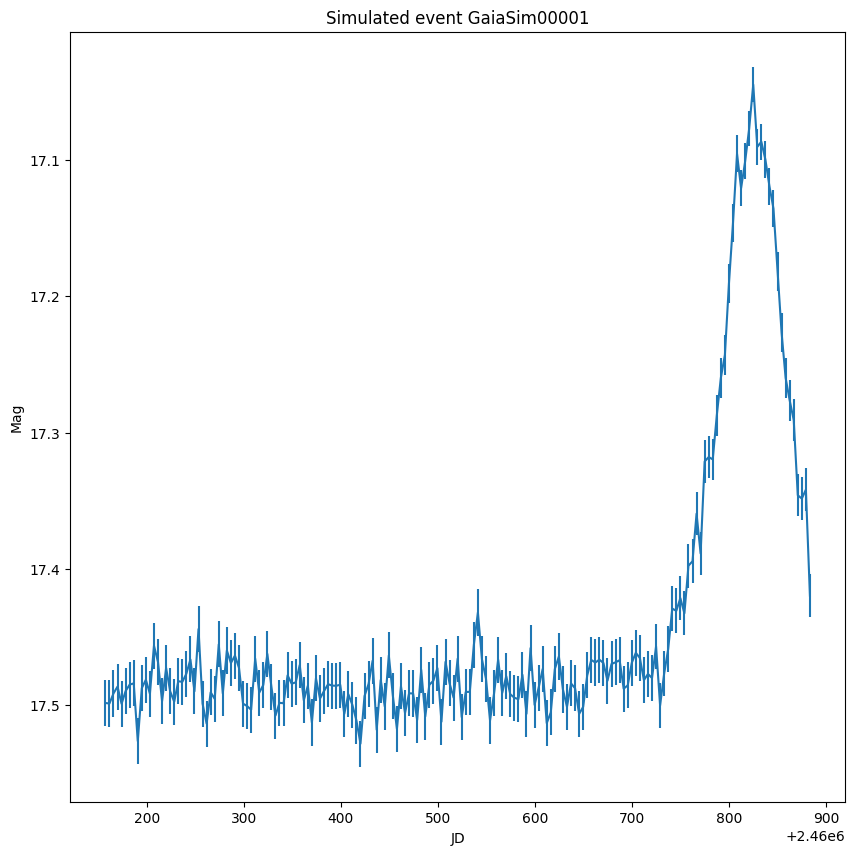

In [29]:
print(events_table[event_number])
fig = plt.figure(1,(10,10))
lc = sim_gaia_lenses[event_number].telescopes[0].lightcurve_magnitude
plt.errorbar(lc[:,0], lc[:,1], yerr=lc[:,2])
[xmin, xmax, ymin, ymax] = plt.axis()
#xmin = float(events_table[event_number]['t0']) - 2*float(events_table[event_number]['te'])
#xmax = float(events_table[event_number]['t0']) + 2*float(events_table[event_number]['te'])
plt.axis([xmin, xmax, ymax, ymin])
plt.xlabel('JD')
plt.ylabel('Mag')
plt.title('Simulated event '+events_table[event_number]['EventID'])

## LCO Event Lightcurves

The next step is to simulate LCO observations for the same events, implementing the observing strategy, but also factoring in visibility of the targets from the LCO 1m network of telescopes, realistic weather loses, etc.  

The first step is to create a realistic model for the photometric uncertainties achievable from the 1m telescopes. 

In [30]:
def add_lco_noise(mag):
    
    # Configuration:
    gain = 1.0 # e- / ADU
    read_noise = 8.0 # e-
    ZP = 25.0
    tel_aperture = 1.0 # m
    phot_aperture_pixels = 10.0
    
    # Convert the lightcurve magnitudes to fluxes
    flux = ( 10**( (mag-ZP)/-2.5 ) ) * gain
    
    # Estimate photometric uncertainties:
    aperradius = phot_aperture_pixels/2.0
    npix_aper = np.pi*aperradius*aperradius
    read_noise = np.sqrt(read_noise*read_noise*npix_aper)
    possion_noise = np.sqrt(flux)
    sig_flux = np.sqrt(read_noise*read_noise + possion_noise*possion_noise )
    
    # Convert back to magnitudes:
    f = flux / gain
    idx = np.where(flux <= 0.0)
    flux[idx] = 0.0
    sig_flux[idx] = 0.0
    idx = np.where(flux > 0.0)
    mag_err = np.zeros(len(mag))
    
    mag_err[idx] = (2.5/np.log(10.0))*sig_flux[idx]/f[idx]

    return mag_err
    

Text(0, 0.5, 'log_10(Mag error)')

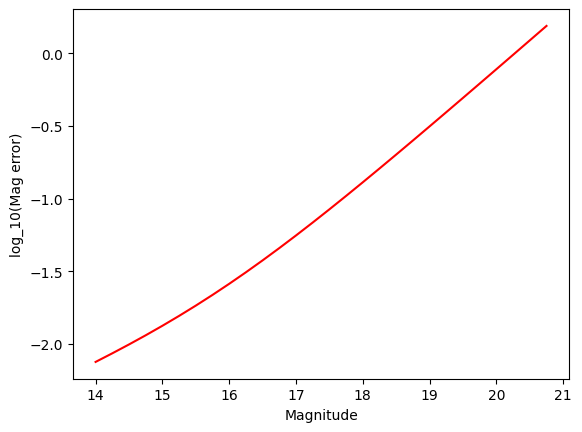

In [31]:
mag = np.arange(14.0, 21.0, 0.25)
mag_err = add_lco_noise(mag)

plt.plot(mag, np.log10(mag_err), 'r-')
plt.xlabel('Magnitude')
plt.ylabel('log_10(Mag error)')

The next step is to simulate what observations LCO could deliver for a given event.  
This naturally includes the visibility of that target from all network sites as a function of 
time, but this is computationally expensive, so we use a pre-calculated table.  This table is created from the notebook visibility_calculations.ipynb in this repository - see that notebook for full details. 

In [32]:
file_path = './lco_1m_network_visibility.hdf5'
visibility_data = visibility_utils.read_visibility_data(file_path)

The function below applies the pre-calculated visibility data to work out which simulated LCO datapoints would be viable observations and returns only those points. 

In [33]:
 def boundaries_check(times, interp_boundaries):
    idx = np.where(times < interp_boundaries[0])
    times[idx] = interp_boundaries[0]
    idx = np.where(times > interp_boundaries[1])
    times[idx] = interp_boundaries[1]
    return times

In [34]:
def observable_dates(input_ts, pixel_vis_func, interp_boundaries):
    """Function to determine whether or not a target is visible from the LCO 1m network 
    at the time stamps given, and return an array of timestamps with datapoints filtered 
    out if the target is not visible.  
    
    Note that this function is intended for multi-day arrays of timestamps, not intra-day.  
    
    While the input array of timestamps to interpolate for should be JD Time objects, 
    note that this is converted within the function into decimalyear, since this seasonal 
    visibility pattern can then be applied to any date.  
    """
        
    # Estimate the hours of visibility per timestamp.  
    ts = np.array([Time(t, format='jd') for t in input_ts])
    ts2 = np.array([(t.decimalyear-int(t.decimalyear)) for t in ts])
    ts2 = boundaries_check(ts2, interp_boundaries)
    hrs_visible = pixel_vis_func(ts2)
    
    # Filter out timestamps where the target isn't visible at all
    idx = np.where(hrs_visible > 0.0)
    
    return input_ts[idx]

The next function takes the simulated Gaia events, and generates a realistic set of LCO observations for that event, if it would be selected for observation using the Key Project strategy. 

In [35]:
def simulate_lco_observations(gaia_event, gaia_model, gaia_model_params, event_params, visibility_data, 
                              parallax=True):
    """Function to simulate LCO's observations of a given event.
    
    Observing strategy simulated:
    * Observe events only when brighter than 17.5mag
    * Cadence depends on event timescale:
    - tE <= 90d: cadence = once a day while  1.0tE <= |t-t0| <= 0.2tE, hourly 0.2tE <= |t-t0|
    - tE > 90d: cadence = once every two days
    * Declinations <= +10deg, simulate continuous cadence from 3 sites (24/7), modulo 10% random datapoints removed for weather
    * Declinations > +10deg, simulate continuous cadence from 1 site (8hrs out of 24), modulo weather
    """
    
    # Take a back-up copy of the original event object, since if no LCO observations are possible, 
    # this will be returned unchanged:
    original_event = copy.deepcopy(gaia_event)
    
    # First check whether the event ever gets bright enough for LCO 1-m observations. 
    # If observations are not viable, no additional lightcurve is added to the event
    gaia_lc = gaia_lens.telescopes[0].lightcurve_magnitude
    if len(gaia_lc) == 0:
        return original_event
    
    mag_threshold = 17.5
    bright_data = np.where(gaia_lc[:,1] <= mag_threshold)[0]
    if len(bright_data) == 0:
        print('Faint event, min '+str(gaia_lc[:,1].min())+' no LCO observations')
        return original_event
    
    # Unpack the lens model parameters:
    if parallax:
        [to, uo, te, rho, piEN, piEE] = gaia_model_params
        print('Event model parameters: ', to, uo, te, rho, piEN, piEE)
    else:
        [to, uo, te, rho] = gaia_model_params
    
    # Determine how many hours per day LCO can observe the target.  We use NSIDE=32 here, 
    # since this is the resolution of the pre-calculated visibility data, but note that 
    # the data is extracted using the Python array index ipix rather than the HP index.
    # This returns the HEALpixel's visibility as a function of date, which is used to create
    # an interpolation function.
    s = SkyCoord(gaia_event.ra, gaia_event.dec, frame='icrs', unit=(u.deg, u.deg))
    hpindex = healpixel_functions.skycoord_to_HPindex(s, 32, radius=2.0)
    ipix = hpindex[0]
    
    pixel_visibility = visibility_data['total_hrs_visible'][ipix,:]
    
    interp_boundaries = (visibility_data['decimalyear'].min(), visibility_data['decimalyear'].max())
    pixel_vis_func = interpolate.interp1d(visibility_data['decimalyear'], pixel_visibility)
    
    # Determine timestamps of LCO observations, with a cadence which depends on the event tE
    start_jd = gaia_lc[:,0].min()
    end_jd = gaia_lc[:,0].max()
    
    # Long timescale events - monitor at regular cadence throughout
    if te > 90.0:
        cadence = 2.0
        ts = np.arange(start_jd, end_jd, cadence)
        #print('Long timescale event, ts ', ts)
    
    # Short timescale events
    else:
        # Peak observations are defined as those between +/- 0.2tE of t0
        deltat = (gaia_lc[:,0] - to)/te
        
        # Pre-peak observations:
        # Monitor at moderate (few times per day) cadence between -tE to +tE:
        # Figure out the timestamps when the event is in the pre-peak phase, taking LCO 
        # network visibility into account
        idx1 = np.where(deltat <= -0.2)[0]
        idx2 = np.where(deltat > -1.0)[0]
        idx = list(set(idx1).intersection(set(idx2)))
        if len(idx) > 0:
            pre_peak_start = gaia_lc[idx,0].min()
            pre_peak_end = gaia_lc[idx,0].max()
            cadence = 8.0/24.0 # days - once per site
            ts1 = np.arange(pre_peak_start, pre_peak_end, cadence)
            ts1 = observable_dates(ts1, pixel_vis_func, interp_boundaries)
        else:
            ts1 = np.array([])
            pre_peak_start = gaia_lc[:,0].min()
            pre_peak_end = gaia_lc[:,0].min()

        # Post-peak observations:
        idx1 = np.where(deltat >= 0.2)[0]
        idx2 = np.where(deltat < 1.0)[0]
        idx = list(set(idx1).intersection(set(idx2)))
        if len(idx) > 0:
            post_peak_start = gaia_lc[idx,0].min()
            post_peak_end = gaia_lc[idx,0].max()
            cadence = 8.0/24.0 # days - once per site
            ts3 = np.arange(post_peak_start, post_peak_end, cadence)
            ts3 = observable_dates(ts3, pixel_vis_func, interp_boundaries)
        else:
            ts3 = np.array([])
            post_peak_start = gaia_lc[:,0].max()
            post_peak_end = gaia_lc[:,0].max()

        # Peak observations
        if event_params['binary_lens'] == 1:
            cadence = 1.0/24.0 # Monitor hourly
        else:
            cadence = 2.0/24.0 # Monitor single lenses every 2hrs
        ts2 = []
        day = pre_peak_end
        while (day < post_peak_start):
            # Estimate the number of hours that LCO can observe this target for
            t = Time(day, format='jd')
            t = t.decimalyear-int(t.decimalyear)
            t = boundaries_check(np.array([t]), interp_boundaries)[0]
            hours_per_night = pixel_vis_func(t)

            if hours_per_night > 0.0:
                # Simulate the timestamps of observations for one 24hr period, taking into account the numbers of 
                # hours that LCO can observe this target for:
                t = np.arange(day, day+(hours_per_night/24.0), cadence)
                ts2 += t.tolist()

            day += 1.0 # Increment the day number
        ts2 = np.array(ts2)

        # Binary lens events only
        # Make additional high cadence observations of two simulated caustic crossing events, 
        # each of which lasts 6hrs
        if event_params['binary_lens'] == 1:
            cadence = 15.0/(60.0*24.0) # Observe every 15mins
            caustic1 = np.arange(pre_peak_end, (pre_peak_end+(6.0/24.0)), cadence)
            caustic2 = np.arange(post_peak_start, (post_peak_start+(6.0/24.0)), cadence)
            ts4 = np.concatenate((caustic1, caustic2))
        else:
            ts4 = np.array([])
        
        ts = np.concatenate((ts1,ts2,ts3,ts4))
        #print('Stellar event, ts ', ts1,ts2,ts3,ts4)

    # Randomly remove a certain fraction of points to simulate data losses due to weather:
    bad_weather_fraction = 0.1
    weathered_idx = np.random.randint(0, high=len(ts), size=int(len(ts)*bad_weather_fraction))
    ts = np.delete(ts, weathered_idx)
    #print('Post weathering ts ',ts)
    
    # Its possible by now that we have no viable LCO observations.  If so, return the event without an 
    # LCO lightcurve attached
    if len(ts) == 0:
        print('No viable times for LCO observations')
        return original_event
    
    # Simulate the LCO photometry for these timestamps, assuming the same baseline magnitude as for Gaia
    lc = np.zeros((len(ts),3))
    lc[:,0] = ts
    lc[:,1] = [np.median(gaia_lc[:,1])] * len(ts)
    lc[:,2] = [0.01] * len(ts)
    #print('Here ',lc)
    tel = telescopes.Telescope(name='LCO', camera_filter='G',
                                     light_curve_magnitude=lc,
                                     location='Earth',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)
    gaia_event.telescopes.append(tel)
    
    if parallax:
        gaia_model.event.compute_parallax_all_telescopes(gaia_model.parallax_model)
    
    #print('N telescopes: ',len())
    #tel = gaia_model.event.telescopes[-1]
    
    # Use the PyLIMA model to add a lensing event into the lightcurve
    pylima_parameters = gaia_model.compute_pyLIMA_parameters(gaia_model_params)
    magnification = gaia_model.model_magnification(tel, pylima_parameters)
    A = gaia_model.model_magnification(tel,pylima_parameters)
    lc[:,1] = lc[:,1] + -2.5*np.log10(A)
    #print('Added magnification: ',lc)
    
    # Remove any LCO observations for datapoints below the brightness threshold
    idx = np.where(lc[:,1] > mag_threshold)[0]
    #print(idx)
    lc = np.delete(lc, idx, axis=0)
    #print('Removed '+str(len(idx))+' points because too faint')
    
    if len(lc) == 0:
        print('Event remains too faint for LCO observations even when magnified')
        return original_event
    
    # Predict the photometric scatter for each datapoint, based on its magnitude
    phot_scatter = add_lco_noise(lc[:,1])
    lc[:,1] += phot_scatter * np.random.randn(len(lc))
        
    # Calculate the photometric uncertainties
    lc[:,2] = add_lco_noise(lc[:,1])
    
    # Store the resulting lightcurve
    tel.lightcurve_magnitude = lc
    gaia_event.telescopes[1] = tel
    #print('Final lc ',gaia_event.telescopes[1].lightcurve_magnitude)
    
    return gaia_event


As a test example, we apply the LCO data simulator to one of the simulated events.  This returns an updated version of the simulated event object, with the LCO lightcurve appended to the associated list of datasets. 

In [36]:
gaia_lens = sim_gaia_lenses[event_number]
gaia_lens_model = sim_gaia_lens_models[event_number]
lens_model_pars = sim_model_params[event_number]

updated_gaia_event = simulate_lco_observations(gaia_lens, gaia_lens_model, lens_model_pars, events_table[event_number], visibility_data)

Event model parameters:  2460803.3398455344 0.13680073863732767 39.88570303841847 0.012939712500705337 -1.0424980589462876 0.2945141501204799
Parallax(Full) estimated for the telescope LCO: SUCCESS


  EventID      HP                             location                               baseline_mag            t0                  u0                 te                rho                  piEN               piEE        nvisits binary_lens
------------ ----- -------------------------------------------------------------- ------------------ ------------------ ------------------- ----------------- -------------------- ------------------- ------------------ ------- -----------
GaiaSim00001 44181 <SkyCoord (ICRS): (ra, dec) in deg\n    (233.1, -52.80185278)> 17.490000000000002 2460803.3398455344 0.13680073863732767 39.88570303841847 0.012939712500705337 -1.0424980589462876 0.2945141501204799     175           1


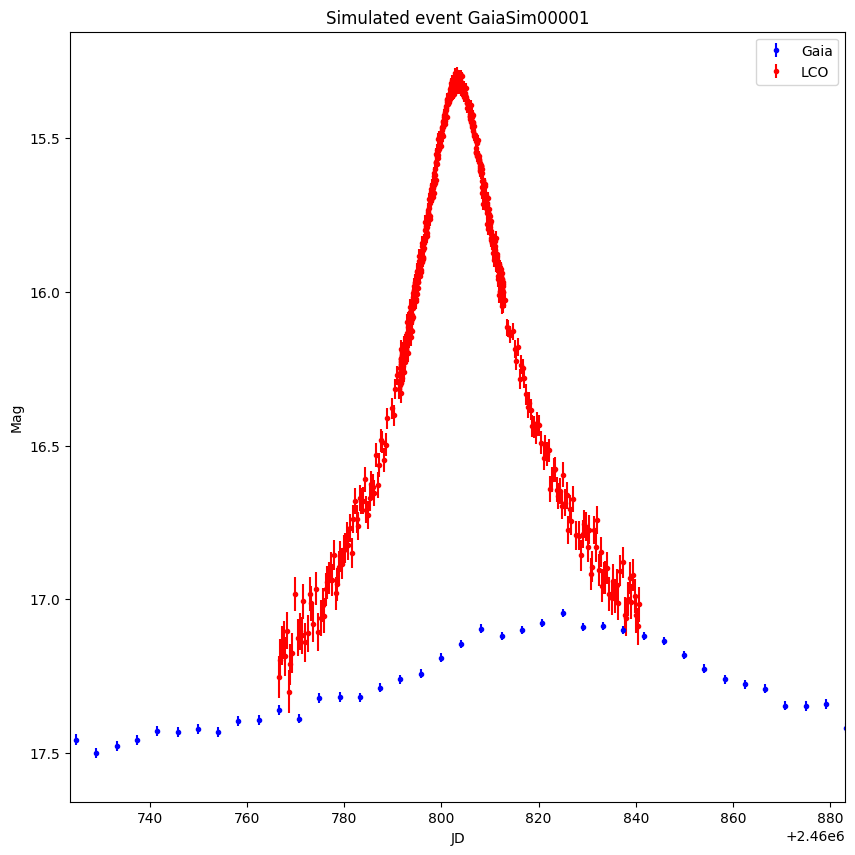

In [37]:
print(events_table[event_number])
fig = plt.figure(1,(10,10))
lc1 = updated_gaia_event.telescopes[0].lightcurve_magnitude
plt.errorbar(lc1[:,0], lc1[:,1], yerr=lc1[:,2], label='Gaia', fmt='b.')
lc2 = updated_gaia_event.telescopes[1].lightcurve_magnitude
plt.errorbar(lc2[:,0], lc2[:,1], yerr=lc2[:,2], label='LCO', fmt='r.')
[xmin, xmax, ymin, ymax] = plt.axis()
xmin = lens_model_pars[0] - 2.0*lens_model_pars[2]
xmax = lens_model_pars[0] + 2.0*lens_model_pars[2]
plt.axis([xmin, xmax, ymax, ymin])
plt.xlabel('JD')
plt.ylabel('Mag')
plt.legend()
plt.title('Simulated event '+events_table[event_number]['EventID'])
plt.savefig('GaiaSim00002_lc.png')

In [40]:
binary_number = binaries[0]
gaia_lens = sim_gaia_lenses[binary_number]
gaia_lens_model = sim_gaia_lens_models[binary_number]
lens_model_pars = sim_model_params[binary_number]

updated_gaia_event = simulate_lco_observations(gaia_lens, gaia_lens_model, lens_model_pars, events_table[binary_number], visibility_data)

Event model parameters:  2460856.7808350236 0.2490153019924247 43.7507314569636 0.019114597573638384 1.4346987898823182 -0.003914165169148359
Parallax(Full) estimated for the telescope LCO: SUCCESS


  EventID      HP                                location                              baseline_mag         t0                 u0                te                rho                 piEN                 piEE         nvisits binary_lens
------------ ----- ------------------------------------------------------------------- ------------ ------------------ ------------------ ---------------- -------------------- ------------------ --------------------- ------- -----------
GaiaSim00006 43974 <SkyCoord (ICRS): (ra, dec) in deg\n    (223.23529167, -52.029725)>        13.99 2460856.7808350236 0.2490153019924247 43.7507314569636 0.019114597573638384 1.4346987898823182 -0.003914165169148359     265           1


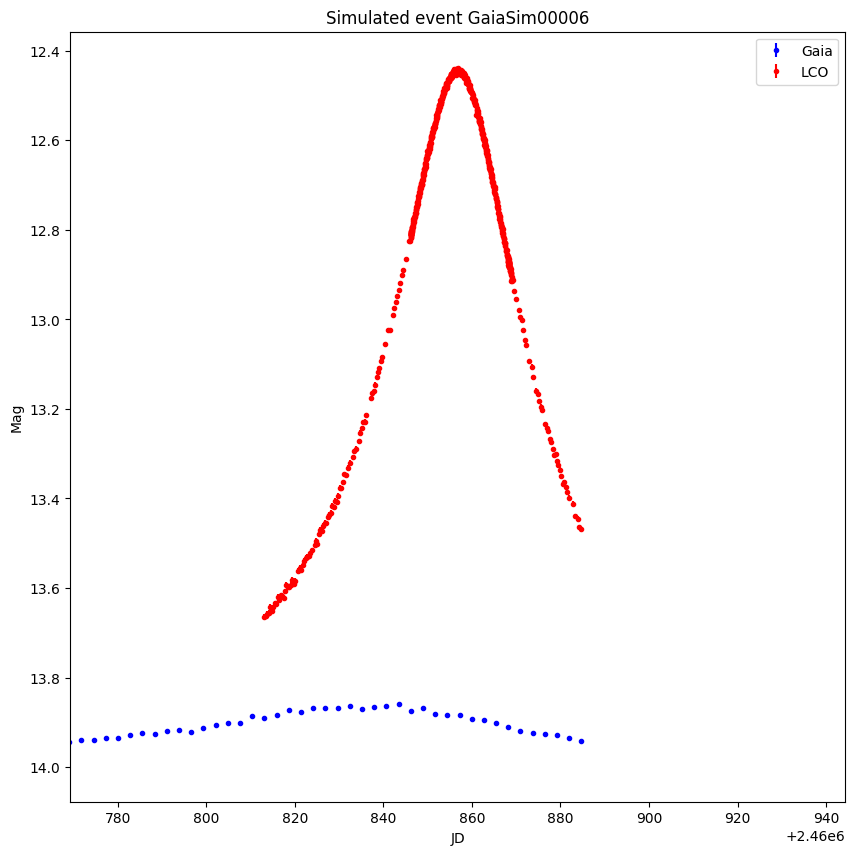

In [41]:
print(events_table[binary_number])
fig = plt.figure(1,(10,10))
lc1 = updated_gaia_event.telescopes[0].lightcurve_magnitude
plt.errorbar(lc1[:,0], lc1[:,1], yerr=lc1[:,2], label='Gaia', fmt='b.')
lc2 = updated_gaia_event.telescopes[1].lightcurve_magnitude
plt.errorbar(lc2[:,0], lc2[:,1], yerr=lc2[:,2], label='LCO', fmt='r.')
[xmin, xmax, ymin, ymax] = plt.axis()
xmin = lens_model_pars[0] - 2.0*lens_model_pars[2]
xmax = lens_model_pars[0] + 2.0*lens_model_pars[2]
plt.axis([xmin,xmax,ymax, ymin])
plt.xlabel('JD')
plt.ylabel('Mag')
plt.legend()
plt.title('Simulated event '+events_table[binary_number]['EventID'])
plt.savefig('GaiaSim00002_lc.png')

We can now simulate LCO observations for the full set of simulated Gaia events

In [42]:
simulated_events_list = []

for ievent in range(0,len(events_table),1):
    updated_gaia_event = simulate_lco_observations(sim_gaia_lenses[ievent], 
                                                   sim_gaia_lens_models[ievent], 
                                                   sim_model_params[ievent], 
                                                   events_table[ievent],
                                                   visibility_data)
    simulated_events_list.append(updated_gaia_event)

Event model parameters:  2460803.3398455344 0.13680073863732767 39.88570303841847 0.012939712500705337 -1.0424980589462876 0.2945141501204799
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460716.8993212455 0.1394321773561388 12.16687949351455 0.009747815794934429 -0.3068398540496694 -0.2905539482927927
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460417.7349421475 0.2042518227553263 22.140174960530672 0.03047607680406219 0.725057907935633 -0.35906964275548503
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460689.2371116197 -0.09676316304564636 9.59744053670669 0.02556108609007003 0.6513007670479256 0.005286983299623307
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460797.2159754112 0.3820921975786873 23.20677469306169 0.0008926765479274137 0.8143022709417136 -0.31871393331801573
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event mode

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460606.9773598346 0.15427468976325734 27.807397009594958 0.019135110590256334 -0.37488707398498305 -0.35723356585721067
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460741.0113173523 0.4315920655635491 26.29313340666365 0.00308289790375148 0.5125846310334926 -0.03757579537383688
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460489.9815317094 0.0676607532484924 60.55477126048842 0.00718589411691512 -0.305119639163091 0.10097329793469434
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460291.97724484 0.8118379984508887 141.62581357780206 0.006789366574308511 0.3896697325153755 -0.09516988452197403
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460171.439698569 0.44650723616377885 46.57290641067327 0.0004312697012934918 1.230844127270179 -0.5351528380848272
Parallax(Fu

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460257.3469775477 0.6346753676993467 32.27963096283922 0.0022161538143638266 0.34221931293489055 -0.019903651007373686
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460159.7331317575 0.49474626125630494 33.661280072922644 0.004251002831920222 0.19449228192307527 0.6464453267825697
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460187.0246043797 0.34108293099608256 36.373623955237946 0.03064365647408257 -0.06920461708619197 0.11486385683737155
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460328.3959504906 0.6732886775578719 29.104053145475863 0.013165929880651675 0.32416834113235565 0.4267271300793446
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460342.442438351 -0.13580529938809796 48.66429865938614 0.006392275146142334 -0.23928069021711357 0.3842221500808435
Par

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460280.14379593 0.0389780913980728 40.323834011406035 0.006585099589355162 0.034201431886272976 0.11243283004362725
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460718.342498113 0.3803272272664727 18.818466919671277 0.0011824961161185305 -0.6510684800421762 0.11298477114460134
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460325.552828163 0.14589238065982746 56.85959626262786 0.005468400373647415 -0.753892533042922 -0.21310433136927634
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460850.5639832052 -0.6903672551351427 31.587477525831947 0.004614743943277981 -0.7771107160341544 -0.16916087391071055
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460561.43482206 0.3938167218186507 159.24288384699042 0.03432852865033645 -1.5163362632616457 -0.3399842707009612
Parallax

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460854.921458862 -0.20474868678407745 38.784526461431874 0.009621791819630859 0.04968617360934825 -0.1548920073860879
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460269.2645629924 -0.13689860290373537 19.06251362667443 0.02223188072184458 1.5199445973522379 -0.21112755974661127
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460574.5555294645 0.35532766879802774 82.72055013966342 0.010242464013405598 0.10189463144934435 0.1664287917562243
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460415.7245894074 0.42936428048241115 46.50240184739045 0.008850842470847392 0.13007028481434604 -0.0495253210706721
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460434.0811797455 -0.10339949424243142 10.709078952093389 0.002300071806793355 1.3095630224681065 0.1021730229142169
Paral

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460541.126025658 -0.1983776816111862 5.071711107223778 0.01615214394826424 0.29211845312646556 0.5165695034724229
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460563.726934877 0.22866056277271432 18.129893013955407 0.004229992117126399 0.49576854271645854 0.1809537428242104
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460447.017527339 0.002347431611294609 61.96270834633128 0.0018561537985712154 -0.8003161049912784 -0.6414734788328892
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460219.6491373945 0.01774471029069677 47.66559566754955 0.010553963109406084 -0.5341162228551439 0.3051932816031531
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460265.857303277 0.411711505140282 32.04984591500123 0.006243972107179373 -0.6586559051968892 0.13480804600510193
Parallax(Ful

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460338.2004110734 0.8153149667015852 14.706526544787241 0.010964600152971843 2.3035279491554523 -0.16759316130230684
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460336.3987878985 -0.03638088027800687 23.601437971624282 0.021622438112868084 1.082844887609471 0.017789705695995715
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460503.3853034084 0.04571765851014818 64.92715809759974 0.01755628922895037 -0.5665109873329377 0.16284957723784102
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460193.146991462 0.39752450266291206 32.95714540449552 0.007442368399437633 0.569277156942298 -0.011974193702449148
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460199.930676928 0.5864804252673842 80.89087985471323 0.02486782299948337 0.4663876400444508 0.23323216742947878
Parallax(F

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460660.5095248222 0.2465355893966668 15.366671928353291 0.02258152857277768 -1.3234933550268106 0.3434441033698105
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460237.421034428 -0.47185534268400753 4.979061186691076 0.013022037705567223 0.056604225055345056 0.034039002784406115
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460369.598541128 0.31368890247207437 20.177881457010585 0.030637303404630174 0.7146558795980762 -0.20943617171303522
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460429.6466875807 -0.3024006433062898 53.18076218325193 0.006683891329092564 -0.2124104524818129 -0.3728341384806222
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460553.896712596 -0.012225051762091571 5.643746108880054 0.011173656089846466 0.3582378914814105 0.5161306119310733
Parall

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460781.7946759835 0.8564694571697258 10.269050710053893 0.0027001219963227654 0.5052272394950927 -0.04953082050929727
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460704.742620745 -0.3622024037670317 8.574076549446339 0.0009061300571486814 -0.4538359681511522 0.5885877069271971
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460395.3207248715 0.3339221674648549 74.72574252566731 0.012685831348135952 0.6661485259300306 0.03901642586657153
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460770.95219412 0.5389289293838279 14.007581303525965 0.008888753066779439 -0.5078040625670133 0.15084888758620194
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460687.096772589 0.7242520878426217 33.824173151547846 0.019289652644752023 0.5901175290448569 0.09828230339286644
Parallax(Fu

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460452.66180143 -0.18854921296567526 51.99823200953268 0.010025048359975416 0.05418821693961447 0.2149496670553911
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460864.9425007734 0.5474302822207807 399.88497596731366 0.0318878797478971 0.009931352534249066 -0.21907384347072598
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460505.6882323474 0.4884819823622749 20.147822318823 0.005599535083069279 0.37591941640237914 0.27120835142137717
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460558.698225295 0.2844253819783481 2.4901076538092823 0.009320044493101415 0.25497190814223264 -0.09952057554242946
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460545.605772389 0.4113254659660892 67.21189292599605 0.02635465045937211 1.4731097450114685 0.28363202313360436
Parallax(Full)

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460477.499425087 0.5873848738529257 77.90819170470215 0.015737012804913315 0.6259264823740049 0.07954925050896267
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460240.360646973 0.07673940500379552 34.52218663851071 0.004900111568479436 -1.2518681670663443 0.04012519288942344
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460792.031177219 -0.26873626545870843 69.13247323975963 0.0049199771545138885 0.10315460857970866 0.20267282301652143
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460301.0826252555 -0.005180556054989571 26.300236324328186 0.00159314839692834 -0.5480447780328797 -0.38199834097510627
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460555.9614062537 0.3934718400457634 9.016960777047728 0.009259882966775658 0.631842741275281 0.21393097139188003
Parallax

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460876.415752809 0.6770353931660881 19.3140722396259 0.012061257570243062 -0.5578959670646966 0.32901259812721234
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460273.9962339834 -0.2617126353497875 85.33993364675666 0.0022877970766847847 -0.0933201598194186 0.2682693822471489
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460691.7932792273 -0.018910728630722268 43.03308792456283 0.009911587036032942 -1.1070765225190393 -0.03129361280253604
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460307.5823547854 0.04464078621991868 14.722457961544587 0.0018466401599989482 0.8851251833315918 0.022377235301907945
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460231.499857373 0.14011396191362016 21.02870447794143 0.004064491538901737 -0.23634423615060374 -0.28958471615232245
Pa

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460305.356141716 0.2984126853354821 33.08510782137171 0.02056644941933805 -0.28321049011567545 -0.039364314520858375
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460357.471702542 -0.23822534754600486 143.32327800882607 0.007381313255773561 0.1811959814941802 0.0753351163795137
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460443.308647385 0.2540259119930732 23.51635510656508 0.015450078687952874 -0.22798734085443906 0.08983100873413177
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460628.2624971746 0.43489874667074857 16.35811424598261 0.004295985516046836 0.44355495726124294 0.305080423704272
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460430.659680144 -0.3917267173525657 18.578080851737795 0.025172389975890885 0.10440623125752194 0.4779420941117383
Parallax(F

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460805.5098342346 -0.004161024092217497 20.745160004250536 0.021511225576737333 -0.07949961199334246 0.08575062802952713
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460635.5753754796 0.5792960333143804 19.151633817234025 0.016833440548730087 -0.12191697448962852 -0.11142712407978067
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460760.398476655 -0.05273772301206678 46.2915457110062 0.018329175095266693 1.4319023172121903 -0.07439629808949566
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460797.4603865137 -0.03173710385864223 21.519667624468063 0.03640808530881804 -1.1651067271609932 0.1918714543115308
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460530.577517647 0.2746375500547916 22.65824686056664 0.014620323876413242 1.478732626672495 0.5762917925014552
Paral

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460596.3807092984 -0.05000644408966548 24.093557105510907 0.0037080126315023713 -1.67141738732376 0.07200690230512935
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460217.723284136 -0.16561521961915596 1.768272175913734 0.015194990096966687 -0.5108576852277305 -0.26997134840082526
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460493.3768810066 0.19762640986522406 11.732786636488823 0.011045518561285298 -0.1779174366136072 0.05543148823030661
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460778.3357124813 0.04767388999957306 20.975033402788615 0.001937883383658876 -0.151658600436745 0.037914781462023754
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460859.2104357067 0.005112925042582039 20.889902694121805 0.03695635678024202 0.31514360593508695 0.14080417069051507


Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460593.361194302 0.19824183274771934 45.58690733486415 0.013005227415057703 -0.9170016420910694 0.08435929563097946
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460837.659842329 0.20463245443745048 83.26113776097932 0.0024564193819917807 0.06978829226691959 -0.0010727618148787116
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460766.6517144195 0.48120444619236014 18.469008664703413 0.007476816376328562 1.246258702263168 0.34587556873208075
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460374.355090625 0.31539482179466527 37.44920573791128 0.014218869584658084 0.9050918006036044 0.12099897255954128
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460420.715018212 0.18445524797008567 43.421625681156165 0.0008376000492799664 1.0505007752273716 0.3209634723543052
Paralla

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460169.9652742655 -0.1477326142400416 95.27375774610631 0.008215812288849142 -0.10974470931766228 0.23595497668356077
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460751.7602051715 0.36256949231168667 23.73314480024298 0.0012394667077869227 -1.2377413152209114 0.21020941138733926
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460852.641103084 0.7132313841774285 125.90615323934668 0.021675440363363226 -0.27072784779138515 0.4505533795716457
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460841.364624942 0.09894575959855686 19.648037630095427 0.029781816997518015 -1.2840399552779036 -0.07288815409823399
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460197.5237403116 0.33929333747017915 9.525641712088714 0.0075954902138563865 0.2454616182824037 -0.030572431845614916
P

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460883.1057799333 0.09884463667772551 6.515641288146979 0.011041407946761589 1.4332389644387367 0.009291942502094239
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460828.1629867773 -0.21759917900981038 21.68695160864935 0.006483233683403362 1.1710487481010083 0.021315899783218937
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460417.3449034533 0.19950743009313743 15.484180473900865 0.008306415982596403 0.7028123666138357 -0.1825014370831151
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460184.88152758 0.25353955735635336 25.739384283538367 0.021503619251272373 0.5230045633651856 -0.30284263806936057
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460423.7630697717 0.057835306169340336 5.478080705288221 0.01817224871774121 0.5228058010989454 0.03792686624463472
Parall

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460369.3706185264 0.33529763818741976 28.78809930953399 0.009777673618583145 0.9346875208489795 -0.09338355253680855
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460170.028168132 0.6552000176106318 64.27587049821399 0.016178917047512623 0.3498174452690389 0.11107300987405239
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460436.053742869 -0.4189404466353486 4.842578168163068 0.004523363150278429 0.6964311089025803 0.031049022576393553
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460349.295960708 -0.2425400044142583 35.365683617623866 0.018417581263062987 -0.3648551254319919 0.20384487142833374
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460642.903768942 0.050109526362827575 150.59324069864678 0.023447629525961855 0.1675240646465008 0.01840107350337303
Parallax(

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460423.2488391404 -0.1683517706325248 56.90064134057928 0.005173322704927024 -0.38935241122852343 0.31220141474537444
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460161.566665828 0.32886039474342466 53.90853895893751 0.03084914130607378 -0.16044205989213306 -0.1542270704139961
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460300.2221282776 0.14706493974794121 16.55863793763848 0.01577628523803578 2.0620351259861116 -0.14513397169083223
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460434.7129816352 0.173285938275202 28.07455515809751 0.0029773145926187223 0.6740059621032441 -0.4356087756169924
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460799.807918535 0.6943034386734492 27.955552744889665 0.008508730209177529 0.08275452946777134 -0.06515506542436852
Parallax

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460485.0116868173 0.3006652537327502 26.216526484094725 0.022381415013902107 0.6683327099234677 -0.5004068562686084
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460214.0701450105 -0.057943428204704966 16.15848480262571 0.016214564817347305 -0.6532969683783141 -0.1978730786128228
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460558.3034934322 -0.3233379532682715 24.59850795816996 0.019674801595110553 1.7059572385920414 -0.09732013499124495
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460725.3250899045 -0.588152991285466 42.67761865479691 0.006719111919985858 0.5347179713241585 -0.03120471778495635
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460290.0510486322 0.28199559136625185 130.30052366451508 0.005984670326776236 0.7630376349681369 0.11832721725776335
Paral

Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460312.5931179407 0.14278206209988972 15.19369865088421 0.026921385267901964 0.07709598040121408 0.006140019225253056
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460409.8203868964 -0.19658064110598253 37.941170850929545 0.022500496636309722 -0.42167485420913015 0.22340722186291512
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460695.2827755366 0.036777652866279986 66.2585375908193 0.021105681790625025 -0.0952171596679599 -0.17778087439264129
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460230.398892042 -0.4937838178552614 37.09350863712354 0.015678786739801977 0.017551260704757016 0.33063077021160925
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460528.0286364052 0.17863023872766082 66.30141057947215 0.003264324929161304 -0.0366379544037585 0.09698891653781312


Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460485.4396644775 0.3024429864083935 35.07506015113886 0.015974384109214004 -0.9595184567841355 0.2405438928760032
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460457.828873897 -0.17017221108734573 129.68645065666308 0.022826603456585656 0.7657366087520421 -0.028230456125789886
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460863.521003186 -0.5179338831025329 59.32582723193677 0.022470361060809393 0.3303953981224401 0.18382762867360322
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460267.170461574 0.6683132743495036 6.135615312907721 0.005440992296518933 -0.49960910438345746 -0.24641351011666665
Parallax(Full) estimated for the telescope LCO: SUCCESS
Event model parameters:  2460166.568458271 0.36509468638615966 25.543944555100992 0.007186885032612529 0.32407184954907503 -0.5006348155133294
Paralla

In [43]:
file_path = 'simulated_lco_lightcurves_gaia_events.hdf5'

with h5py.File(file_path, "w") as f:
    
    for ievent in range(0,len(simulated_events_list),1):
        if len(simulated_events_list[ievent].telescopes) == 2:
            lc = simulated_events_list[ievent].telescopes[1].lightcurve_magnitude
        else:
            lc = np.array([])
        dset = f.create_dataset(events_table[ievent]['EventID'],
                            lc.shape,
                            dtype='float64',
                            data=lc)
    f.close()

## Evalulating how well we can characterize events

A key test of the observing strategy is how well we can constraint the event parameters as a result of the lightcurves produced.  

In order to evaluate this, we fit a microlensing model to the two lightcurves for each simulated event, as we would with real data, and then evaluate the fitted parameters of that model in comparison with the input simulated event parameters, as well as evaluating the uncertainties on the parameters key to measuring the mass of the events. 

In [44]:
class FitParams():
    """Object containing the fitted parameters and errors of a model fitted
    to a microlensing lightcurve"""
    
    def __init__(self):
        
        self.to = None
        self.toerr = None
        self.delta_to = None
        self.prop_delta_to = None
        self.to_within_range = None
        self.uo = None
        self.uoerr = None
        self.delta_uo = None
        self.prop_delta_uo = None
        self.uo_within_range = None
        self.tE= None
        self.tEerr = None
        self.delta_tE = None
        self.prop_delta_tE = None
        self.tE_within_range = None
        self.rho = None
        self.rhoerr = None
        self.piEN = None
        self.piENerr = None
        self.delta_piEN = None
        self.prop_delta_piEN = None
        self.piEN_within_range = None
        self.piEE= None
        self.piEEerr = None
        self.delta_piEE = None
        self.prop_delta_piEE = None
        self.piEE_within_range = None
        self.s = None
        self.serr = None
        self.q = None
        self.qerr = None
        self.logs = None
        self.logserr = None
        self.logq = None
        self.logqerr = None
        self.alpha = None
        self.alphaerr = None
        self.chichi = None
        self.bic = None
        self.nparam = 0
        self.type = None
        self.teerr_ok = None
        self.piEN_constrained = None
        self.piEE_constrained = None
    
    def extract_parameters_from_fit(self, fit, tel_list):
        fit_params = microloutputs.parameters_result(fit)
        fit_errors = microloutputs.fit_errors(fit)
    
        self.to = fit_params.to
        self.toerr = fit_errors.err_to
        self.tE = fit_params.tE
        self.tEerr = fit_errors.err_tE
        self.rho = fit_params.rho
        self.rhoerr = fit_errors.err_rho
        self.uo = fit_params.uo
        self.uoerr = fit_errors.err_uo
        self.piEN = fit_params.piEN
        self.piENerr = fit_errors.err_piEN
        self.piEE= fit_params.piEE
        self.piEEerr = fit_errors.err_piEE
        
        for tel in tel_list:
            fs = getattr(fit_params, 'fs_'+tel)
            fserr = getattr(fit_errors, 'err_fs_'+tel)
            setattr(self,'fs_'+tel, fs)
            setattr(self,'fs_'+tel+'_err', fserr)
            fb = getattr(fit_params, 'fb_'+tel)
            fberr = getattr(fit_errors, 'err_fb_'+tel)
            setattr(self,'fb_'+tel, fb)
            setattr(self,'fb_'+tel+'_err', fberr)
        
        self.chichi = fit_params.chichi

    def compare_parameters(self, event_params, params={'to':'t0','tE':'te','uo':'u0','piEN':'piEN','piEE':'piEE'}):
        
        result = ''
        
        for par_fit,par_expect in params.items():
            fitted_value = getattr(self,par_fit)
            fitted_error = getattr(self,par_fit+'err')
            fitted_range = [fitted_value - fitted_error, fitted_value + fitted_error]
            expected_value = event_params[par_expect]
            
            result += par_expect+': Fitted value='+str(fitted_value)+'+/-'+str(fitted_error)\
                    +' expected value='+str(expected_value)+'\n'
            
            delta = abs(expected_value - fitted_value)
            prop_delta = (delta/expected_value)*100.0
            if expected_value >= fitted_range[0] and expected_value <= fitted_range[1]:
                within_range = True
            else:
                within_range = False
        
            result += par_expect+': delta='+str(delta)\
                        +' prop_delta='+str(prop_delta)\
                        +'% within_range? '+repr(within_range)+'\n'
        
            setattr(self, 'delta_'+par_fit, delta)
            setattr(self, 'prop_delta_'+par_fit, prop_delta)
            setattr(self, par_fit+'_within_range', within_range)
            
        # Require that the tE be well constrained, meaning that the uncertainty is less than 25% of the value
        if (self.tEerr/event_params['te'])<0.25:
            teerr_ok = True
        else:
            teerr_ok = False
        result += 'tE constrained='+repr(teerr_ok)
        self.teerr_ok = teerr_ok
        
        # Require that the fitted uncertainties on the parallax parameters are smaller
        # than the measured values, i.e. are constrained
        piE_ok = []
        for par in ['piEE', 'piEN']:
            fitted_value = getattr(self,par)
            fitted_error = getattr(self,par+'err')
            
            if (np.abs(fitted_value) - 2.0*fitted_error > 0):
                piE_ok.append(True)
            else:
                piE_ok.append(False)
            result += ' '+par+' constrained='+repr(piE_ok[-1])
            
            setattr(self, par+'_constrained', piE_ok[-1])
            
        print(result)
        
    def summary(self, tel_list):
        
        line = 'tE = '+str(self.tE)+'+/-'+str(self.tEerr)+'\n'+\
                'to = '+str(self.to)+'+/-'+str(self.toerr)+'\n'+\
                'uo = '+str(self.uo)+'+/-'+str(self.uoerr)+'\n'+\
                'rho = '+str(self.rho)+'+/-'+str(self.rhoerr)+'\n'+\
                'piEN = '+str(self.piEN)+'+/-'+str(self.piENerr)+'\n'+\
                'piEE = '+str(self.piEE)+'+/-'+str(self.piEEerr)+'\n'
        
        for tel in tel_list:
            fs = getattr(self,'fs_'+tel)
            fserr = getattr(self,'fs_'+tel+'_err')
            fb = getattr(self,'fb_'+tel)
            fberr = getattr(self,'fb_'+tel+'_err')
            
            line += 'fs_'+tel+' = '+str(fs)+'+/-'+str(fserr)+'\n'
            line += 'fb_'+tel+' = '+str(fb)+'+/-'+str(fberr)+'\n'
        
        line += 'chi^2 = '+str(self.chichi)
        
        return line


In [45]:
def fit_event_model(event_params, model_type, horizons_table, gaia_lc, lco_lc):
    
    e = event.Event()
    e.name = event_params['EventID']
    e.ra = float(event_params['location'].ra.deg)
    e.dec = float(event_params['location'].dec.deg)

    # Add a PyLIMA telescope object to the event with the Gaia lightcurve
    tel1 = telescopes.Telescope(name='Gaia', camera_filter='G',
                                     spacecraft_name = 'Gaia',
                                     light_curve_magnitude=gaia_lc,
                                     location='Space',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)

    # For spacecraft parallax, need to append the spacecraft_positions table here
    spacecraft_positions = jplhorizons_utils.calc_spacecraft_positions_observer_table(horizons_table,
                                                                                    event_params['t0'])
    tel1.spacecraft_positions = spacecraft_positions
    
    e.telescopes.append(tel1)
    
    
    # Add a PyLIMA telescope object to the event with the LCO lightcurve
    tel2 = telescopes.Telescope(name='LCO', camera_filter='G',
                                     light_curve_magnitude=lco_lc,
                                     location='Earth',
                                     light_curve_magnitude_dictionnary={'time': 0, 'mag': 1, 'err_mag': 2},
                                     clean_the_lightcurve=False)

    e.telescopes.append(tel2)
    
    # Identify which dataset to use as the baseline:
    e.find_survey('Gaia')
    e.check_event()

    fit_method = 'LM'
    fit_method = 'DE'

    # Create a model object with parallax
    model = microlmodels.create_model(model_type, e, 
                                          parallax=['Full', event_params['t0']], 
                                          blend_flux_ratio=False)
    model.define_model_parameters()
    
    # Give the model initial guess values somewhere near their actual values so that the fit doesn't take all day
    lensing_parameters = [float(event_params['t0']), float(event_params['u0']), float(event_params['te']), 
                              float(event_params['rho']), float(event_params['piEN']), float(event_params['piEE'])]
        
    model.parameters_guess = lensing_parameters 
    for idx in range(6):    
        model.parameters_boundaries[idx]= [lensing_parameters[idx]-3e-4,
                                             lensing_parameters[idx]+3e-4]
    model.event.compute_parallax_all_telescopes(model.parallax_model)
    
    # Fit the model to the data:
    e.fit(model,fit_method)
    fit_flag = e.fits[-1].check_fit()
    print('Fit flag: '+repr(fit_flag))
    print('Telescopes: '+str(len(e.telescopes)))
    print('Fit results: '+repr(e.fits[-1].fit_results))
    
    # Compare the fitted model with the input event parameters
    tel_list = ['Gaia', 'LCO']
    fit = FitParams()
    fit.extract_parameters_from_fit(e.fits[-1], tel_list)
   
    fit.compare_parameters(event_params)
    
    return fit, e


Using our example simulated event, we fit an event model and demonstrate the comparision between the input and fitted parameters

In [46]:
e = simulated_events_list[binary_number]
gaia_lc = e.telescopes[0].lightcurve_magnitude
lco_lc = e.telescopes[1].lightcurve_magnitude
model_type = 'FSPL'

print(events_table[binary_number])
(fit_params, e) = fit_event_model(events_table[binary_number], model_type, horizons_table, gaia_lc, lco_lc)

  EventID      HP                                location                              baseline_mag         t0                 u0                te                rho                 piEN                 piEE         nvisits binary_lens
------------ ----- ------------------------------------------------------------------- ------------ ------------------ ------------------ ---------------- -------------------- ------------------ --------------------- ------- -----------
GaiaSim00006 43974 <SkyCoord (ICRS): (ra, dec) in deg\n    (223.23529167, -52.029725)>        13.99 2460856.7808350236 0.2490153019924247 43.7507314569636 0.019114597573638384 1.4346987898823182 -0.003914165169148359     265           1
check_event  : Everything looks fine, this event can be fitted
Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00006, with model FSPL and method DE
check_event  : Everything looks fine, this event can be

Now we can model all of the events in the simulation, storing the model fitted parameters and the comparison information

In [47]:
e = simulated_events_list[0]
gaia_lc = e.telescopes[0].lightcurve_magnitude
lco_lc = e.telescopes[1].lightcurve_magnitude
model_type = 'FSPL'

print(events_table[0])
(fit_params, e) = fit_event_model(events_table[0], model_type, horizons_table, gaia_lc, lco_lc)

  EventID      HP                             location                               baseline_mag            t0                  u0                 te                rho                  piEN               piEE        nvisits binary_lens
------------ ----- -------------------------------------------------------------- ------------------ ------------------ ------------------- ----------------- -------------------- ------------------- ------------------ ------- -----------
GaiaSim00001 44181 <SkyCoord (ICRS): (ra, dec) in deg\n    (233.1, -52.80185278)> 17.490000000000002 2460803.3398455344 0.13680073863732767 39.88570303841847 0.012939712500705337 -1.0424980589462876 0.2945141501204799     175           1
check_event  : Everything looks fine, this event can be fitted
Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00001, with model FSPL and method DE
check_event  : Everything looks fine, this event can

In [48]:
modeling_results = []
model_type = 'FSPL'

for ievent in range(0,len(events_table),1):
    print('\nModeling event '+str(ievent)+' number of lightcurves '+str(len(simulated_events_list[ievent].telescopes)))
    if len(simulated_events_list[ievent].telescopes) == 2:
        gaia_lc = simulated_events_list[ievent].telescopes[0].lightcurve_magnitude
        lco_lc = simulated_events_list[ievent].telescopes[1].lightcurve_magnitude
        (fit_params, e) = fit_event_model(events_table[ievent], model_type, horizons_table, gaia_lc, lco_lc)
    else:
        fit_params = FitParams()
        print('No LCO lightcurve so not fitted')
        
    modeling_results.append(fit_params)
    


Modeling event 0 number of lightcurves 3
No LCO lightcurve so not fitted

Modeling event 1 number of lightcurves 2
check_event  : Everything looks fine, this event can be fitted
Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00002, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 210.804
DE converge to objective function : f(x) =  210.7872303340821
DE converge to parameters : =  ['2460716.8993837577' '0.1395950205394178' '12.16717949351455'
 '0.009447815794934429' '-0.3065398540496694' '-0.29025394829279266']
trust_region_reflective  : TRF fit SUCCESS
[2460716.89938328, 0.13959503280819385, 12.167179493508465, 0.009447815795802334, -0.3065398540513059, -0.2902539482945725, 3661.8657709351523, -3.1029648048957714, 233369.20486676457, -458.36804928939284, 210.7872304041486]
differential_evolution  : Differential evolution

differential_evolution step 1: f(x)= 377.602
DE converge to objective function : f(x) =  377.597020116099
DE converge to parameters : =  ['2460882.8183881077' '0.3786320033656423' '48.03650855563544'
 '0.03058261180051802' '-0.4546808177504288' '-0.3147070552810814']
trust_region_reflective  : TRF fit SUCCESS
[2460882.818388295, 0.37864447000731055, 48.03650855569626, 0.031071594013245444, -0.45468081775042885, -0.3147070552810441, 881.4964440529161, 33.31137479270361, 233472.0986116677, -499.6809883675716, 377.59706561814596]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460882.818388295, 0.37864447000731055, 48.03650855569626, 0.031071594013245444, -0.45468081775042885, -0.3147070552810441, 881.4964440529161, 33.31137479270361, 233472.0986116677, -499.6809883675716, 377.59706561814596]
t0: Fitted value=2460882.818388295+/-0.07683256279283604 expected value=2460882.8186881077
t0: delta=0.00029981276020407677 prop_delta=1

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00012, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 361.039
DE converge to objective function : f(x) =  360.92386708667823
DE converge to parameters : =  ['2460398.7458179346' '0.17744203859778632' '29.603724154742974'
 '0.015464402640671818' '-1.082818478148146' '0.15791517191848303']
trust_region_reflective  : TRF fit SUCCESS
[2460398.7458179337, 0.1774420431503906, 29.60372415474297, 0.01546440264067182, -1.0828184781481458, 0.157915171918483, 2357.1092335784733, -65.83088574307779, 233072.05954573592, 473.22350767059584, 360.9238671403582]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460398.7458179337, 0.1774420431503906, 29.60372415474297, 0.01546440264067182, -1.0828184781481458, 0.157915171918483, 2357.1092335784733, -65.83088574307779, 233072.05954573592

differential_evolution step 1: f(x)= 478.438
DE converge to objective function : f(x) =  478.4096203785136
DE converge to parameters : =  ['2460311.0889177145' '0.2702719369128905' '25.106411331625473'
 '0.019940103902002546' '1.1521263552061975' '0.726001091767232']
trust_region_reflective  : TRF fit SUCCESS
[2460311.0889177127, 0.2702755517233546, 25.106411331625452, 0.020149165513681032, 1.1521263552061969, 0.7260010917672317, 930.9995834426707, -20.358119280462834, 233125.25198808403, 273.3172056278718, 478.4093994410559]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460311.0889177127, 0.2702755517233546, 25.106411331625452, 0.020149165513681032, 1.1521263552061969, 0.7260010917672317, 930.9995834426707, -20.358119280462834, 233125.25198808403, 273.3172056278718, 478.4093994410559]
t0: Fitted value=2460311.0889177127+/-0.008013726943107598 expected value=2460311.0886177146
t0: delta=0.00029999809339642525 prop_delta=1

differential_evolution step 2: f(x)= 294.66
differential_evolution step 3: f(x)= 294.66
differential_evolution step 4: f(x)= 294.66
differential_evolution step 5: f(x)= 294.66
DE converge to objective function : f(x) =  294.5963331251076
DE converge to parameters : =  ['2460839.553213177' '-0.05614574870146105' '20.851775472399552'
 '0.005917562038760393' '-0.9923589798359584' '-0.25405040876451457']
trust_region_reflective  : TRF fit SUCCESS
[2460839.5532131763, -0.056144901424785884, 20.851739508841376, 0.00588071876699907, -0.9923589798359586, -0.2540504087645145, 929.7256869242419, -10.78135617647456, 233316.33113949146, -9.487375603217538, 294.6008705399379]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460839.5532131763, -0.056144901424785884, 20.851739508841376, 0.00588071876699907, -0.9923589798359586, -0.2540504087645145, 929.7256869242419, -10.78135617647456, 233316.33113949146, -9.487375603217538, 294.600870539

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00025, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 626.927
differential_evolution step 2: f(x)= 626.92
differential_evolution step 3: f(x)= 626.848
DE converge to objective function : f(x) =  626.7295722545903
DE converge to parameters : =  ['2460526.44039023' '-0.15046897119046923' '18.820131992852744'
 '0.01602804001425797' '-0.2951024309957669' '-0.15538289321031182']
trust_region_reflective  : TRF fit SUCCESS
[2460526.4403902306, -0.1504564789274594, 18.82001368347338, 0.015499666206894792, -0.29510243099576694, -0.1553828932103118, 2309.6353215224412, -5.537420632261854, 233123.88369567168, 709.2149464509349, 626.7276883064301]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460526.4403902306, -0.1504564789274594, 18.82001368347338, 0.015499666206894792, -0.2

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00029, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 536.731
DE converge to objective function : f(x) =  536.600356115105
DE converge to parameters : =  ['2460697.3701185784' '-0.488561078476814' '78.6985320852172'
 '0.027487100685478542' '0.35287753594837706' '0.4735280072633814']
trust_region_reflective  : TRF fit SUCCESS
[2460697.3701185165, -0.488561078476813, 78.69853208521525, 0.0274871006854818, 0.3528775359484008, 0.47352800726335675, 2327.022453173296, -14.572670795018393, 233845.2422188444, -786.9060952224961, 536.6003582051611]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460697.3701185165, -0.488561078476813, 78.69853208521525, 0.0274871006854818, 0.3528775359484008, 0.47352800726335675, 2327.022453173296, -14.572670795018393, 233845.2422188444, -786.

DE converge to objective function : f(x) =  789.0391001985329
DE converge to parameters : =  ['2460609.487633193' '-0.35511564506316123' '14.008236597268255'
 '0.010331300454255307' '-0.04340609738554164' '0.3071939347123396']
trust_region_reflective  : TRF fit SUCCESS
[2460609.4876331934, -0.3551156450631612, 14.008236597268253, 0.010331300454255309, -0.04340609738554163, 0.30719393471233963, 5836.2525069641815, -44.14675814462999, 233408.60653272676, -5.506651681954078, 789.0392255200165]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460609.4876331934, -0.3551156450631612, 14.008236597268253, 0.010331300454255309, -0.04340609738554163, 0.30719393471233963, 5836.2525069641815, -44.14675814462999, 233408.60653272676, -5.506651681954078, 789.0392255200165]
t0: Fitted value=2460609.4876331934+/-0.004433290447516273 expected value=2460609.487933193
t0: delta=0.00029999949038028717 prop_delta=1.2192080533358991e-08% within_ra

differential_evolution step 4: f(x)= 367.817
differential_evolution step 5: f(x)= 367.817
differential_evolution step 6: f(x)= 367.815
differential_evolution step 7: f(x)= 367.737
DE converge to objective function : f(x) =  367.61924900057636
DE converge to parameters : =  ['2460332.0831095' '0.08630194372078905' '65.60842536788019'
 '0.0011932311742925232' '-0.5008325349373584' '-0.02298723822906719']
trust_region_reflective  : TRF fit SUCCESS
[2460332.083109482, 0.08629898956432226, 65.60864424294655, 0.0008235922112439293, -0.5008325349373582, -0.022987238229067095, 1464.1855540854308, -9.491834776276484, 233305.5150005368, -262.21501457386273, 367.620929678065]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460332.083109482, 0.08629898956432226, 65.60864424294655, 0.0008235922112439293, -0.5008325349373582, -0.022987238229067095, 1464.1855540854308, -9.491834776276484, 233305.5150005368, -262.21501457386273, 367.620929

differential_evolution step 1: f(x)= 241.747
DE converge to objective function : f(x) =  241.7314890426702
DE converge to parameters : =  ['2460336.9254605267' '-0.529500465701327' '21.401540681562846'
 '0.017683421544657914' '0.2555165875663403' '-0.1512195294063822']
trust_region_reflective  : TRF fit SUCCESS
[2460336.925460527, -0.5295004657013271, 21.40154068156285, 0.01768342154465791, 0.25551658756634027, -0.15121952940638217, 2233.712892048923, 79.70940954212932, 232921.43669301446, 505.6841778402195, 241.73148904968804]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460336.925460527, -0.5295004657013271, 21.40154068156285, 0.01768342154465791, 0.25551658756634027, -0.15121952940638217, 2233.712892048923, 79.70940954212932, 232921.43669301446, 505.6841778402195, 241.73148904968804]
t0: Fitted value=2460336.925460527+/-0.019543384205677077 expected value=2460336.9257605267
t0: delta=0.00029999949038028717 prop_delta=

differential_evolution step 3: f(x)= 738.495
differential_evolution step 4: f(x)= 738.495
differential_evolution step 5: f(x)= 738.495
differential_evolution step 6: f(x)= 738.433
differential_evolution step 7: f(x)= 738.358
differential_evolution step 8: f(x)= 738.333
differential_evolution step 9: f(x)= 738.049
differential_evolution step 10: f(x)= 738.049
DE converge to objective function : f(x) =  737.6893982539639
DE converge to parameters : =  ['2460489.9818317094' '0.06767741050914414' '60.55447126048842'
 '0.00748589411691512' '-0.30523159915392606' '0.10067329793469434']
trust_region_reflective  : TRF fit SUCCESS
[2460489.981831709, 0.06767741458969995, 60.55447126048843, 0.007485894116915118, -0.3052316118352356, 0.10067329793469436, 14596.330981803505, -22.212387025336156, 233219.98305636345, 141.60100886639717, 737.6893989826863]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460489.981831709, 0.067677414589699

differential_evolution step 4: f(x)= 301.502
differential_evolution step 5: f(x)= 301.502
differential_evolution step 6: f(x)= 301.502
differential_evolution step 7: f(x)= 301.502
differential_evolution step 8: f(x)= 301.502
DE converge to objective function : f(x) =  301.49466604443535
DE converge to parameters : =  ['2460258.7648464213' '0.02206507857576889' '19.264364733705392'
 '0.004486018045192439' '-0.42719457387639437' '-0.10783539808441597']
trust_region_reflective  : TRF fit SUCCESS
[2460258.764845453, 0.022055682300053794, 19.26415356286085, 0.004288003102595137, -0.4271945738763944, -0.10779095068474312, 2311.0627372889244, -1.6692702345628396, 233233.22707807974, 111.4051279279102, 301.48389099609415]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460258.764845453, 0.022055682300053794, 19.26415356286085, 0.004288003102595137, -0.4271945738763944, -0.10779095068474312, 2311.0627372889244, -1.6692702345628396, 

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00053, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 593.605
DE converge to objective function : f(x) =  593.5851550269847
DE converge to parameters : =  ['2460774.0781138707' '-0.36401010960720176' '131.6379739703206'
 '0.0029536748609567238' '-1.3342651510462962' '-0.09348558605605178']
trust_region_reflective  : TRF fit SUCCESS
[2460774.0778685194, -0.36401010960770175, 131.63797395718632, 0.0029536748609567238, -1.3342651509927526, -0.09348480296358762, 1588.9149742871082, -140.56606601979738, 232871.06687777428, 373.47893395352685, 593.585666934141]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460774.0778685194, -0.36401010960770175, 131.637973957

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00057, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1238.88
differential_evolution step 2: f(x)= 1238.78
differential_evolution step 3: f(x)= 1238.73
differential_evolution step 4: f(x)= 1238.73
differential_evolution step 5: f(x)= 1238.73
differential_evolution step 6: f(x)= 1238.73
differential_evolution step 7: f(x)= 1238.73
differential_evolution step 8: f(x)= 1238.73
differential_evolution step 9: f(x)= 1238.73
DE converge to objective function : f(x) =  1238.5689644823174
DE converge to parameters : =  ['2460837.2470083055' '0.08937895570825508' '55.09485283963233'
 '0.02370958997516502' '0.23507797607086547' '0.0223287708460508']
trust_region_reflective  : TRF fit SUCCESS
[2460837.247008305, 0.08937898334298076, 55.09485283963234, 0.023709589975165025, 0.235077976

differential_evolution step 1: f(x)= 342.921
DE converge to objective function : f(x) =  342.7734863289421
DE converge to parameters : =  ['2460213.353030327' '0.4566777050969392' '31.175072562413877'
 '0.004463775786525724' '0.5820972684382777' '0.010500401403136126']
trust_region_reflective  : TRF fit SUCCESS
[2460213.3532004994, 0.4566777050974392, 31.175072565468685, 0.004463775786525724, 0.5820972685329817, 0.010500401350099248, 3604.907988613225, 60.271821157046205, 232667.38085189057, 599.2573406691528, 342.8151642700875]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460213.3532004994, 0.4566777050974392, 31.175072565468685, 0.004463775786525724, 0.5820972685329817, 0.010500401350099248, 3604.907988613225, 60.271821157046205, 232667.38085189057, 599.2573406691528, 342.8151642700875]
t0: Fitted value=2460213.3532004994+/-0.023994719074879774 expected value=2460

differential_evolution step 1: f(x)= 318.669
DE converge to objective function : f(x) =  318.58163554315877
DE converge to parameters : =  ['2460657.1977694505' '0.3898566254190957' '6.6440997933586345'
 '0.012586314054030944' '0.18770150437369845' '-0.5894584413113958']
trust_region_reflective  : TRF fit SUCCESS
[2460657.197769451, 0.3898566254190958, 6.644099793358648, 0.012592022680747196, 0.187701504373701, -0.5894584413113935, 3648.2384826384605, 8.418092917219447, 233491.18050033008, -570.8247715036478, 318.581633915556]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460657.197769451, 0.3898566254190958, 6.644099793358648, 0.012592022680747196, 0.187701504373701, -0.5894584413113935, 3648.2384826384605, 8.418092917219447, 233491.18050033008, -570.8247715036478, 318.581633915556]
t0: Fitted value=2460657.197769451+/-0.004214616426952936 expected value=2460657.1980694504
t0: delta=0.00029999949038028717 prop_delta=1.21

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00070, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 779.241
DE converge to objective function : f(x) =  779.1232234462417
DE converge to parameters : =  ['2460755.914529711' '0.2711083979765874' '54.08181045471448'
 '0.0008929163023283287' '-0.10003053427215661' '0.13373314108735926']
trust_region_reflective  : TRF fit SUCCESS
[2460755.9143710635, 0.27110839801042036, 54.08181046008024, 0.0008929163023283287, -0.10003053419321054, 0.13373314108785925, 2288.611137137732, 24.763805911814615, 232892.17707453197, 648.3410178698396, 779.1476092621466]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460755.9143710635, 0.27110839801042036, 54.08181046008024, 0.0008929163023283287, -0.10003053419321054, 0.133733141087

differential_evolution step 2: f(x)= 482.404
DE converge to objective function : f(x) =  482.3608227634295
DE converge to parameters : =  ['2460832.6420218553' '0.19043152699406024' '18.431672133184342'
 '0.02447803069030087' '1.2288218588230206' '-0.17877836461933297']
trust_region_reflective  : TRF fit SUCCESS
[2460832.641937284, 0.19043152704080443, 18.431672135007297, 0.02448078531792933, 1.2288218589375182, -0.17877836471250652, 2297.5769857068303, 7.332022823593855, 232831.40345273295, 706.8821836267076, 482.37788465589813]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460832.641937284, 0.19043152704080443, 18.431672135007297, 0.02448078531792933, 1.2288218589375182, -0.17877836471250652, 2297.5769857068303, 7.332022823593855, 232831.40345273295, 706.8821836267076, 482.37788465589813]
t0: Fitted value=2460832.641937284+/-0.0017736865503567207 expected value=2460832.6417218554
t0: delta=0.0002154284156858921 prop_del

trust_region_reflective  : TRF fit SUCCESS
[2460235.24651437, 0.18519976895499407, 32.2136475406267, 0.03418643271145048, 1.1714082156415104, 0.026254560813050696, 593.7552363861203, -21.61930310848667, 233476.21188118696, -478.44661510168385, 371.9664280541542]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460235.24651437, 0.18519976895499407, 32.2136475406267, 0.03418643271145048, 1.1714082156415104, 0.026254560813050696, 593.7552363861203, -21.61930310848667, 233476.21188118696, -478.44661510168385, 371.9664280541542]
t0: Fitted value=2460235.24651437+/-0.004280669457176343 expected value=2460235.2468143697
t0: delta=0.00029999949038028717 prop_delta=1.219393514375265e-08% within_range? True
te: Fitted value=32.2136475406267+/-0.11637311624267997 expected value=32.213347755767835
te: delta=0.0002997848588677243 prop_delta=0.0009306231104590721% within_range? True
u0: Fitted value=0.18519976895499407+/-0.026134943224496

differential_evolution step 2: f(x)= 522.581
differential_evolution step 3: f(x)= 522.581
differential_evolution step 4: f(x)= 522.409
differential_evolution step 5: f(x)= 522.325
differential_evolution step 6: f(x)= 522.325
differential_evolution step 7: f(x)= 522.325
differential_evolution step 8: f(x)= 522.325
differential_evolution step 9: f(x)= 522.325
differential_evolution step 10: f(x)= 522.187
differential_evolution step 11: f(x)= 522.035
differential_evolution step 12: f(x)= 521.979
differential_evolution step 13: f(x)= 521.941
differential_evolution step 14: f(x)= 521.791
differential_evolution step 15: f(x)= 521.791
differential_evolution step 16: f(x)= 521.791
differential_evolution step 17: f(x)= 521.791
differential_evolution step 18: f(x)= 521.791
differential_evolution step 19: f(x)= 521.791
DE converge to objective function : f(x) =  521.6178231090207
DE converge to parameters : =  ['2460299.6604250143' '-0.006266360859702182' '107.28641087564183'
 '0.0153699633683296

trust_region_reflective  : TRF fit SUCCESS
[2460159.733431757, 0.4950462612563049, 33.66158007292264, 0.004551002831920221, 0.19479228192307524, 0.6467453267825696, 3691.5903670039347, -25.142435055694534, 233602.92709025898, -473.014114737507, 295.90063118862037]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460159.733431757, 0.4950462612563049, 33.66158007292264, 0.004551002831920221, 0.19479228192307524, 0.6467453267825696, 3691.5903670039347, -25.142435055694534, 233602.92709025898, -473.014114737507, 295.90063118862037]
t0: Fitted value=2460159.733431757+/-0.0780338703041498 expected value=2460159.7331317575
t0: delta=0.00029999949038028717 prop_delta=1.2194309432029887e-08% within_range? True
te: Fitted value=33.66158007292264+/-0.48442946809887416 expected value=33.661280072922644
te: delta=0.0002999999999957481 prop_delta=0.0008912317040404833% within_range? True
u0: Fitted value=0.4950462612563049+/-0.00325198653

DE converge to objective function : f(x) =  188.394683019698
DE converge to parameters : =  ['2460700.7731534163' '-0.2075494831096196' '26.52975990662795'
 '0.0013624345854611228' '-0.9714486850397177' '-0.1347279132621313']
trust_region_reflective  : TRF fit SUCCESS
[2460700.77290848, -0.20754891878309717, 26.529759903983646, 0.0013624345854611228, -0.9714486849491314, -0.1347279133493573, 2317.215374282017, -2.6718914243394445, 233330.21768498368, -146.35580445829046, 188.39745662896414]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460700.77290848, -0.20754891878309717, 26.529759903983646, 0.0013624345854611228, -0.9714486849491314, -0.1347279133493573, 2317.215374282017, -2.6718914243394445, 233330.21768498368, -146.35580445829046, 188.39745662896414]
t0: Fitted value=2460700.77290848+/-0.0057211468225768485 expected value=2460700.7728534164
t0: delta=5.506351590156555e-05 prop_delta=2.2377168532244644e-09% within_ra

differential_evolution step 1: f(x)= 765.445
differential_evolution step 2: f(x)= 765.445
differential_evolution step 3: f(x)= 765.445
differential_evolution step 4: f(x)= 765.445
differential_evolution step 5: f(x)= 757.995
differential_evolution step 6: f(x)= 757.962
differential_evolution step 7: f(x)= 757.962
differential_evolution step 8: f(x)= 757.962
differential_evolution step 9: f(x)= 757.811
differential_evolution step 10: f(x)= 757.786
differential_evolution step 11: f(x)= 757.77
differential_evolution step 12: f(x)= 756.807
differential_evolution step 13: f(x)= 756.807
differential_evolution step 14: f(x)= 756.753
differential_evolution step 15: f(x)= 756.025
differential_evolution step 16: f(x)= 756.025
differential_evolution step 17: f(x)= 756.025
differential_evolution step 18: f(x)= 756.025
differential_evolution step 19: f(x)= 755.931
differential_evolution step 20: f(x)= 755.931
differential_evolution step 21: f(x)= 755.931
differential_evolution step 22: f(x)= 755.90

differential_evolution step 1: f(x)= 578.438
differential_evolution step 2: f(x)= 578.438
differential_evolution step 3: f(x)= 578.438
differential_evolution step 4: f(x)= 578.438
differential_evolution step 5: f(x)= 578.414
differential_evolution step 6: f(x)= 578.414
differential_evolution step 7: f(x)= 578.378
differential_evolution step 8: f(x)= 578.314
differential_evolution step 9: f(x)= 578.314
differential_evolution step 10: f(x)= 578.314
DE converge to objective function : f(x) =  578.1749066756678
DE converge to parameters : =  ['2460839.801789916' '-0.052621528069095064' '101.0246389848225'
 '0.029662686415198806' '1.127852256293194' '0.0019379851995135113']
trust_region_reflective  : TRF fit SUCCESS
[2460839.802035826, -0.05262130490927721, 101.02463897472045, 0.02966269194354608, 1.1278522561809152, 0.0019379850998796442, 23026.7778379933, 113.80060789871878, 233298.72974333956, -234.95139499466055, 578.2140787970674]
differential_evolution  : Differential evolution fit SU

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00104, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 573.989
DE converge to objective function : f(x) =  573.8794142659154
DE converge to parameters : =  ['2460717.9663948286' '0.40479702564368153' '112.83200171309038'
 '0.00568087192555985' '-1.5904279375871815' '0.24971945694570455']
trust_region_reflective  : TRF fit SUCCESS
[2460717.966394828, 0.4047970256436816, 112.83200171309039, 0.005680871925559838, -1.5904279375871817, 0.24971945694570458, 912.127664706722, -2.181447574098355, 232651.8344636152, 594.5605999814849, 573.879414270126]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460717.966394828, 0.4047970256436816, 112.83200171309039, 0.005680871925559838, -1.5904279375871817, 0.24971945694570458, 912.127664706722, -2.181447574098355, 232651.8344636152, 5

differential_evolution step 3: f(x)= 274.45
differential_evolution step 4: f(x)= 271.297
differential_evolution step 5: f(x)= 270.066
differential_evolution step 6: f(x)= 270.066
differential_evolution step 7: f(x)= 270.066
differential_evolution step 8: f(x)= 270.066
differential_evolution step 9: f(x)= 270.066
differential_evolution step 10: f(x)= 270.066
differential_evolution step 11: f(x)= 270.066
differential_evolution step 12: f(x)= 270.066
differential_evolution step 13: f(x)= 270.066
differential_evolution step 14: f(x)= 270.054
differential_evolution step 15: f(x)= 270.054
differential_evolution step 16: f(x)= 270.054
differential_evolution step 17: f(x)= 270.054
differential_evolution step 18: f(x)= 270.054
differential_evolution step 19: f(x)= 270.054
DE converge to objective function : f(x) =  270.0406598587905
DE converge to parameters : =  ['2460451.761688914' '-0.0193018881722071' '12.550211751657535'
 '0.025432327996592993' '0.6506969830287996' '0.097584734979812']
tru

differential_evolution step 2: f(x)= 606.451
differential_evolution step 3: f(x)= 606.451
differential_evolution step 4: f(x)= 606.451
differential_evolution step 5: f(x)= 606.451
differential_evolution step 6: f(x)= 606.451
differential_evolution step 7: f(x)= 606.294
DE converge to objective function : f(x) =  605.6978690815836
DE converge to parameters : =  ['2460642.446202483' '-0.1501502648562188' '85.83987115925035'
 '0.0016316260344264163' '0.1747205770663253' '-0.0845359104117977']
trust_region_reflective  : TRF fit SUCCESS
[2460642.4462025105, -0.15015026485622926, 85.83987115925041, 0.0016316260344205343, 0.17472057706631997, -0.08453591041181109, 2314.363634817925, -14.636419154486035, 233023.51230927792, 389.90475148570647, 605.6978767023894]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460642.4462025105, -0.15015026485622926, 85.83987115925041, 0.0016316260344205343, 0.17472057706631997, -0.08453591041181109

differential_evolution step 1: f(x)= 440.848
DE converge to objective function : f(x) =  440.7378195666536
DE converge to parameters : =  ['2460462.0869575227' '0.45821647735477106' '28.74593121527729'
 '0.031923659828542915' '-0.5466169995518875' '-0.18622120838359546']
trust_region_reflective  : TRF fit SUCCESS
[2460462.086957585, 0.45821647735478455, 28.745931215277665, 0.031923659828528995, -0.546616999551887, -0.1862212083836076, 36626.57951785121, 16.207931994876233, 233643.53939769627, -774.640901073733, 440.7378266360623]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460462.086957585, 0.45821647735478455, 28.745931215277665, 0.031923659828528995, -0.546616999551887, -0.1862212083836076, 36626.57951785121, 16.207931994876233, 233643.53939769627, -774.640901073733, 440.7378266360623]
t0: Fitted value=2460462.086957585+/-0.015031785013601686 expected value=2460462.0872575226
t0: delta=0.00029993755742907524 prop_delt

DE converge to objective function : f(x) =  310.5107366516607
DE converge to parameters : =  ['2460467.2494362434' '0.42323407166171506' '8.793902369502193'
 '0.010463316040729996' '0.2568011820258936' '0.03572518453909456']
trust_region_reflective  : TRF fit SUCCESS
[2460467.249301874, 0.42321112161645486, 8.793902370379476, 0.010463347928636766, 0.2568011819383839, 0.03572518444674802, 5637.41817726682, 169.51737245679888, 233129.61487576296, 155.9191555856162, 310.5349390795757]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460467.249301874, 0.42321112161645486, 8.793902370379476, 0.010463347928636766, 0.2568011819383839, 0.03572518444674802, 5637.41817726682, 169.51737245679888, 233129.61487576296, 155.9191555856162, 310.5349390795757]
t0: Fitted value=2460467.249301874+/-0.006138831751660992 expected value=2460467.2491362435
t0: delta=0.00016563059762120247 prop_delta=6.731672517866179e-09% within_range? True
te: Fit

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00126, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 501.972
DE converge to objective function : f(x) =  501.9141768117695
DE converge to parameters : =  ['2460698.222381' '0.18336358997552818' '26.67652412432866'
 '0.0004981989969374033' '0.4579773963362823' '0.3071776310671688']
trust_region_reflective  : TRF fit SUCCESS
[2460698.222556793, 0.18336351456317396, 26.676524126943043, 0.0004981989969374033, 0.4579773963367811, 0.3071776310106118, 2286.8782546364746, 15.077325690157487, 233217.80479229838, 319.33417769189333, 501.92684870454514]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460698.222556793, 0.18336351456317396, 26.676524126943043, 0.0004981989969374033, 0.4579773963367811, 0.3071776310106118, 2

trust_region_reflective  : TRF fit SUCCESS
[2460718.3422649424, 0.38002722726647276, 18.81816692093369, 0.0009039334009390424, -0.6507684800621952, 0.1132847711441108, 9242.5668834963, -54.7565085657045, 232724.56782053664, 932.9845479542442, 456.70461630938945]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460718.3422649424, 0.38002722726647276, 18.81816692093369, 0.0009039334009390424, -0.6507684800621952, 0.1132847711441108, 9242.5668834963, -54.7565085657045, 232724.56782053664, 932.9845479542442, 456.70461630938945]
t0: Fitted value=2460718.3422649424+/-0.008312630182102694 expected value=2460718.342498113
t0: delta=0.00023317057639360428 prop_delta=9.475711720703895e-09% within_range? True
te: Fitted value=18.81816692093369+/-0.12780811105881387 expected value=18.818466919671277
te: delta=0.00029999873758512763 prop_delta=0.001594172037848278% within_range? True
u0: Fitted value=0.38002722726647276+/-0.0013253860927

differential_evolution step 1: f(x)= 795.675
DE converge to objective function : f(x) =  795.6700929490909
DE converge to parameters : =  ['2460319.109058768' '0.41538641322735864' '51.786832826832786'
 '0.006109498553255646' '1.3100787036403492' '0.2804374279040635']
trust_region_reflective  : TRF fit SUCCESS
[2460319.109111485, 0.4153873710112522, 51.78681743140424, 0.0061718618270967095, 1.309997398536364, 0.28040677429884514, 3604.046459596991, 61.292111552842464, 233320.36174190335, 8.521558645577553, 795.6688526233909]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460319.109111485, 0.4153873710112522, 51.78681743140424, 0.0061718618270967095, 1.309997398536364, 0.28040677429884514, 3604.046459596991, 61.292111552842464, 233320.36174190335, 8.521558645577553, 795.6688526233909]
t0: Fitted value=2460319.109111485+/-0.02362136667488509 expected value=2460319.108852442
t0: delta=0.0002590431831777096 prop_delta=1.052884

trust_region_reflective  : TRF fit SUCCESS
[2460387.60550228, 0.538228707642069, 51.31638251663502, 0.00025386793346223623, -0.9288357632509727, 0.22885667507461213, 3690.667942543589, -35.02137007123173, 233251.2762452117, 159.24265625987866, 876.8908764125064]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460387.60550228, 0.538228707642069, 51.31638251663502, 0.00025386793346223623, -0.9288357632509727, 0.22885667507461213, 3690.667942543589, -35.02137007123173, 233251.2762452117, 159.24265625987866, 876.8908764125064]
t0: Fitted value=2460387.60550228+/-0.031150021182325308 expected value=2460387.605704765
t0: delta=0.00020248489454388618 prop_delta=8.229796560281625e-09% within_range? True
te: Fitted value=51.31638251663502+/-0.33079110635400605 expected value=51.31608252163601
te: delta=0.0002999949990041273 prop_delta=0.0005846023006094487% within_range? True
u

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00143, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 536.054
DE converge to objective function : f(x) =  536.0397810155205
DE converge to parameters : =  ['2460463.260345228' '0.6528380003821049' '25.969809626718366'
 '0.004137817642230744' '-0.0496460984021846' '-0.6307005056461874']
trust_region_reflective  : TRF fit SUCCESS
[2460463.260151374, 0.6528380003816049, 25.96980962420267, 0.004137817642230744, -0.049646098307315874, -0.6307005055516423, 1567.5329435699489, -121.44208505484718, 233232.91801646122, 366.81551016133676, 536.0484684020003]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460463.260151374, 0.6528380003816049, 25.96980962420267, 0.004137817642230744, -0.049646098307315874, -0.6307005055516

DE converge to objective function : f(x) =  393.38900209178337
DE converge to parameters : =  ['2460708.5176791097' '0.11877194617405117' '13.896657506918555'
 '0.020659904396941032' '-0.29415136577680845' '0.09183931650669029']
trust_region_reflective  : TRF fit SUCCESS
[2460708.5176785486, 0.11877192986358116, 13.896657506909216, 0.020659904396032165, -0.2941513657767984, 0.09183921350687846, 58269.561096021724, -217.71432914200022, 233478.87976345184, -343.9706412890872, 393.3890019805783]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460708.5176785486, 0.11877192986358116, 13.896657506909216, 0.020659904396032165, -0.2941513657767984, 0.09183921350687846, 58269.561096021724, -217.71432914200022, 233478.87976345184, -343.9706412890872, 393.3890019805783]
t0: Fitted value=2460708.5176785486+/-0.001908847533489161 expected value=2460708.5176555584
t0: delta=2.2990163415670395e-05 prop_delta=9.342903985058047e-10% within_

differential_evolution step 1: f(x)= 505.838
differential_evolution step 2: f(x)= 505.838
differential_evolution step 3: f(x)= 505.818
differential_evolution step 4: f(x)= 505.818
differential_evolution step 5: f(x)= 505.818
differential_evolution step 6: f(x)= 505.818
differential_evolution step 7: f(x)= 505.818
differential_evolution step 8: f(x)= 505.694
differential_evolution step 9: f(x)= 505.694
differential_evolution step 10: f(x)= 505.694
DE converge to objective function : f(x) =  505.5848848237158
DE converge to parameters : =  ['2460552.2138575315' '0.09891721671891986' '32.931004544270955'
 '0.00248879242455997' '0.213921987135159' '0.2236515481368518']
trust_region_reflective  : TRF fit SUCCESS
[2460552.213857532, 0.09891880311571032, 32.93111971423223, 0.0027553695252463795, 0.2139736912146609, 0.2234125964891933, 9200.3323994676, 0.3545579627449409, 233385.1160623426, -172.33585212856613, 505.61199548111216]
differential_evolution  : Differential evolution fit SUCCESS
Fi

differential_evolution step 1: f(x)= 293.803
DE converge to objective function : f(x) =  293.7835768978912
DE converge to parameters : =  ['2460158.2604942718' '0.2245856206162245' '14.238620054125901'
 '0.01953728370578635' '0.510369298597559' '0.23940631788057143']
trust_region_reflective  : TRF fit SUCCESS
[2460158.260494271, 0.22459353911559146, 14.238620054125905, 0.019891982752533517, 0.5103692985975593, 0.2394063178805714, 918789.1486101736, 1788.764827221091, 233447.10517231963, -592.9862823532854, 293.78369090772225]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460158.260494271, 0.22459353911559146, 14.238620054125905, 0.019891982752533517, 0.5103692985975593, 0.2394063178805714, 918789.1486101736, 1788.764827221091, 233447.10517231963, -592.9862823532854, 293.78369090772225]
t0: Fitted value=2460158.260494271+/-0.009605771459409888 expected value=2460158.260194272
t0: delta=0.00029999902471899986 prop_delta=1.2

differential_evolution step 1: f(x)= 538.224
DE converge to objective function : f(x) =  538.1667169965967
DE converge to parameters : =  ['2460362.1413521534' '-0.2499392505668853' '134.83157909362464'
 '0.010244524165346481' '1.213251022889573' '-0.18643854948333413']
trust_region_reflective  : TRF fit SUCCESS
[2460362.141324405, -0.2499393507358503, 134.83157909349043, 0.010244524166866832, 1.2132510228895597, -0.18643854948160724, 1516.3576879511465, -69.84993871391268, 232986.1474039392, 176.21636554795978, 538.1667390872043]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460362.141324405, -0.2499393507358503, 134.83157909349043, 0.010244524166866832, 1.2132510228895597, -0.18643854948160724, 1516.3576879511465, -69.84993871391268, 232986.1474039392, 176.21636554795978, 538.1667390872043]
t0: Fitted value=2460362.141324405+/-0.08975473479397743 expected value=2460362.1410521534
t0: delta=0.0002722516655921936 prop_del

differential_evolution step 2: f(x)= 499.73
differential_evolution step 3: f(x)= 499.432
differential_evolution step 4: f(x)= 499.432
differential_evolution step 5: f(x)= 499.432
DE converge to objective function : f(x) =  498.8882254505551
DE converge to parameters : =  ['2460380.6624572566' '-0.2269180165165912' '113.3824248194404'
 '0.04260577427812254' '0.0010627757518463284' '-0.45121915104589366']
trust_region_reflective  : TRF fit SUCCESS
[2460380.662458099, -0.22691803099236965, 113.3824248194398, 0.04260591917256027, 0.0010627757514533416, -0.4512191510458882, 2322.742790093783, -29.944708542459715, 233097.0504021257, 158.9233975297503, 498.8882365047153]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460380.662458099, -0.22691803099236965, 113.3824248194398, 0.04260591917256027, 0.0010627757514533416, -0.4512191510458882, 2322.742790093783, -29.944708542459715, 233097.0504021257, 158.9233975297503, 498.8882365047

DE converge to objective function : f(x) =  279.0807142001628
DE converge to parameters : =  ['2460355.3904701243' '0.5525874351383545' '15.408240747424903'
 '0.007866045911085091' '-1.037072715015176' '0.012406197441894916']
trust_region_reflective  : TRF fit SUCCESS
[2460355.390469412, 0.5525874351383666, 15.408240747426037, 0.007912809899970856, -1.0370727150152081, 0.012406197441810433, 5780.336729630797, 29.170840375340514, 232593.35476448905, 871.4049471167107, 279.077173607502]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460355.390469412, 0.5525874351383666, 15.408240747426037, 0.007912809899970856, -1.0370727150152081, 0.012406197441810433, 5780.336729630797, 29.170840375340514, 232593.35476448905, 871.4049471167107, 279.077173607502]
t0: Fitted value=2460355.390469412+/-0.016928770522738973 expected value=2460355.3901701244
t0: delta=0.00029928749427199364 prop_delta=1.216440094255241e-08% within_range? True
te

DE converge to objective function : f(x) =  209.7450808704105
DE converge to parameters : =  ['2460269.2642629924' '-0.13696240031358306' '19.06281362667443'
 '0.021931880721844578' '1.5202445973522378' '-0.21111365649247207']
trust_region_reflective  : TRF fit SUCCESS
[2460269.264263078, -0.13696240348207075, 19.062813626674426, 0.02193188072184458, 1.5202445973522376, -0.21111383405928072, 365884.0836787041, 541.1367230558365, 233385.12615695372, -75.50689447319044, 209.74508677285624]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460269.264263078, -0.13696240348207075, 19.062813626674426, 0.02193188072184458, 1.5202445973522376, -0.21111383405928072, 365884.0836787041, 541.1367230558365, 233385.12615695372, -75.50689447319044, 209.74508677285624]
t0: Fitted value=2460269.264263078+/-0.0038547652488679545 expected value=2460269.2645629924
t0: delta=0.00029991427436470985 prop_delta=1.2190302853618033e-08% within_range? 

differential_evolution step 3: f(x)= 591.924
differential_evolution step 4: f(x)= 591.819
differential_evolution step 5: f(x)= 591.819
DE converge to objective function : f(x) =  591.7158402554588
DE converge to parameters : =  ['2460560.3241656427' '-0.11689415627965273' '31.960568040197643'
 '0.009680975179546431' '-0.5515141102432408' '0.10708168919535808']
trust_region_reflective  : TRF fit SUCCESS
[2460560.3241654066, -0.11689392302563911, 31.960629392133878, 0.00968097517954643, -0.5515141102432409, 0.10708168919535807, 5795.303271447314, 9.268131072275112, 233106.37340397437, 490.3276554739877, 591.7158463428186]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460560.3241654066, -0.11689392302563911, 31.960629392133878, 0.00968097517954643, -0.5515141102432409, 0.10708168919535807, 5795.303271447314, 9.268131072275112, 233106.37340397437, 490.3276554739877, 591.7158463428186]
t0: Fitted value=2460560.3241654066+/-0.0

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00183, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 239.952
DE converge to objective function : f(x) =  239.58104312210924
DE converge to parameters : =  ['2460315.7762723346' '-0.014417513274763186' '52.252359833880746'
 '0.02397516936738104' '-0.17598805088063676' '0.08007291200535183']
trust_region_reflective  : TRF fit SUCCESS
[2460315.7762723374, -0.014417509791733615, 52.25235983388079, 0.023975169367381255, -0.1759880508806368, 0.08007291200535184, 2321.445615187764, -25.61931287893279, 233396.8244069594, -544.2252147645471, 239.58104364430264]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460315.7762723374, -0.014417509791733615, 52.25235983388079, 0.023975169367381255, -0.1759880508806368, 0.080072

differential_evolution step 1: f(x)= 484.619
DE converge to objective function : f(x) =  484.509265439302
DE converge to parameters : =  ['2460422.6970681394' '0.4158041903191884' '17.96217782074144'
 '0.013675920459004873' '0.4304418111762506' '-0.2215350653059378']
trust_region_reflective  : TRF fit SUCCESS
[2460422.697068149, 0.4158041903191887, 17.962177820741445, 0.013675920459004556, 0.4304418111762465, -0.22153506530593686, 912.81884393861, 6.224768626583762, 232375.7978306845, 1737.5604596594153, 484.5092709733746]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460422.697068149, 0.4158041903191887, 17.962177820741445, 0.013675920459004556, 0.4304418111762465, -0.22153506530593686, 912.81884393861, 6.224768626583762, 232375.7978306845, 1737.5604596594153, 484.5092709733746]
t0: Fitted value=2460422.697068149+/-0.007160449322310514 expected value=2460422.6973681394
t0: delta=0.000299990177154541 prop_delta=1.21926276

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00191, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 955.458
DE converge to objective function : f(x) =  955.3826566949394
DE converge to parameters : =  ['2460737.9677936174' '0.31840403292746455' '72.68781606395562'
 '0.019507134640916978' '0.4970853028166261' '-0.09694115107002163']
trust_region_reflective  : TRF fit SUCCESS
[2460737.967793704, 0.3184091566300574, 72.68781606395491, 0.02010531642318299, 0.49708530281660435, -0.09694115107000695, 2329.213313162687, -20.004303663935104, 233565.61219048026, -390.4148628056695, 955.3801489583511]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460737.967793704, 0.3184091566300574, 72.68781606395491, 0.02010531642318299, 0.49708530281660435, -0.09694115107000695, 2329.213313162687, -20.004303663935104, 233565.61219048

differential_evolution step 1: f(x)= 606.269
differential_evolution step 2: f(x)= 606.269
differential_evolution step 3: f(x)= 606.269
differential_evolution step 4: f(x)= 606.269
differential_evolution step 5: f(x)= 606.269
differential_evolution step 6: f(x)= 605.476
differential_evolution step 7: f(x)= 604.606
differential_evolution step 8: f(x)= 604.606
differential_evolution step 9: f(x)= 604.606
differential_evolution step 10: f(x)= 604.606
differential_evolution step 11: f(x)= 604.606
differential_evolution step 12: f(x)= 604.585
differential_evolution step 13: f(x)= 604.186
differential_evolution step 14: f(x)= 604.186
differential_evolution step 15: f(x)= 604.186
differential_evolution step 16: f(x)= 604.186
differential_evolution step 17: f(x)= 604.186
differential_evolution step 18: f(x)= 604.186
differential_evolution step 19: f(x)= 604.186
differential_evolution step 20: f(x)= 604.186
differential_evolution step 21: f(x)= 604.029
DE converge to objective function : f(x) = 

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00199, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 508.134
DE converge to objective function : f(x) =  508.10401867333803
DE converge to parameters : =  ['2460685.0595875545' '0.40890625322619445' '211.77496339512507'
 '0.009004222233458377' '0.007340912394779025' '-0.103607181262524']
trust_region_reflective  : TRF fit SUCCESS
[2460685.059590671, 0.4089059080537153, 211.7749633952489, 0.009017565429014015, 0.00734091237853449, -0.10360718126254177, 2336.8003113121354, -42.82647301056212, 233070.51917738633, 160.21102127351173, 508.1040580988147]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460685.059590671, 0.4089059080537153, 211.7749633952489, 0.009017565429014015, 0.00734091237853449, -0.10360718126254177, 2336.8003113121354, -42.82647301056212, 233070.5191

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00203, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 814.568
DE converge to objective function : f(x) =  814.5135840581579
DE converge to parameters : =  ['2460339.540479918' '-0.2814224294194445' '47.47091746686473'
 '0.017280230536601358' '0.7702534690845495' '-0.11042406708084976']
trust_region_reflective  : TRF fit SUCCESS
[2460339.5404799185, -0.2814224231764133, 47.470917466864734, 0.01728023053660135, 0.7702534690845496, -0.11042406708084974, 932.5314453544977, -22.83856213650699, 233339.99374670556, -279.07008443937906, 814.5135841852394]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460339.5404799185, -0.2814224231764133, 47.470917466864734, 0.01728023053660135, 0.7702534690845496, -0.11042406708084974, 932.5314453544977, -22.83856213650699, 233339.993746

differential_evolution step 1: f(x)= 191.556
DE converge to objective function : f(x) =  191.5150846922523
DE converge to parameters : =  ['2460703.37693333' '0.37265119075171776' '33.53954410832841'
 '0.02677460919386644' '-0.1826274235918733' '-0.19109323933941003']
trust_region_reflective  : TRF fit SUCCESS
[2460703.3769332212, 0.3726511907517061, 33.53954410832677, 0.02677460919387512, -0.18262742359187278, -0.1910932393396123, 5752.358155648849, 20.63074055639775, 233390.2597569475, 21.64438631550716, 191.51509670624213]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460703.3769332212, 0.3726511907517061, 33.53954410832677, 0.02677460919387512, -0.18262742359187278, -0.1910932393396123, 5752.358155648849, 20.63074055639775, 233390.2597569475, 21.64438631550716, 191.51509670624213]
t0: Fitted value=2460703.3769332212+/-0.030817210864883513 expected value=2460703.3766333302
t0: delta=0.00029989099130034447 prop_delta=1.

trust_region_reflective  : TRF fit SUCCESS
[2460791.4260415523, -0.4366577834926543, 22.93333833207222, 0.003508539544514266, -1.083444214716739, 0.18413428689563321, 3661.6761499901922, 2.7609681027412316, 232610.24572356642, 991.1120061925767, 370.33712261182416]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460791.4260415523, -0.4366577834926543, 22.93333833207222, 0.003508539544514266, -1.083444214716739, 0.18413428689563321, 3661.6761499901922, 2.7609681027412316, 232610.24572356642, 991.1120061925767, 370.33712261182416]
t0: Fitted value=2460791.4260415523+/-0.012793297725110115 expected value=2460791.4257415547
t0: delta=0.00029999762773513794 prop_delta=1.21911034229459e-08% within_range? True
te: Fitted value=22.93333833207222+/-0.2018974377193808 expected value=22.9336383300178
te: delta=0.0002999979455786672 prop_delta=0.0013081131796955235% within_range? 

differential_evolution step 1: f(x)= 315.846
DE converge to objective function : f(x) =  315.83011102852396
DE converge to parameters : =  ['2460647.685184549' '0.6779783506748418' '40.334665570415574'
 '0.009122961116176154' '-0.1024949747413845' '0.055270766985224214']
trust_region_reflective  : TRF fit SUCCESS
[2460647.6851846413, 0.6779783506748417, 40.33466557041378, 0.009122961116179346, -0.10249497474135048, 0.055270766985249395, 2329.050129809352, -21.74665304639197, 233663.7882844818, -246.18727527651268, 315.83011292109927]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460647.6851846413, 0.6779783506748417, 40.33466557041378, 0.009122961116179346, -0.10249497474135048, 0.055270766985249395, 2329.050129809352, -21.74665304639197, 233663.7882844818, -246.18727527651268, 315.83011292109927]
t0: Fitted value=2460647.6851846413+/-0.3705481602670938 expected value=2460647.685484549
t0: delta=0.00029990775510668755 pro

differential_evolution step 38: f(x)= 1080.16
differential_evolution step 39: f(x)= 1079.24
differential_evolution step 40: f(x)= 1079.24
differential_evolution step 41: f(x)= 1079.24
differential_evolution step 42: f(x)= 1079.24
differential_evolution step 43: f(x)= 1079.24
differential_evolution step 44: f(x)= 1079.24
differential_evolution step 45: f(x)= 1078.67
differential_evolution step 46: f(x)= 1078.67
differential_evolution step 47: f(x)= 1078.67
differential_evolution step 48: f(x)= 1078.67
differential_evolution step 49: f(x)= 1078.3
differential_evolution step 50: f(x)= 1078.3
differential_evolution step 51: f(x)= 1078.3
differential_evolution step 52: f(x)= 1078.3
differential_evolution step 53: f(x)= 1078.3
differential_evolution step 54: f(x)= 1078.3
differential_evolution step 55: f(x)= 1078.3
differential_evolution step 56: f(x)= 1078.3
differential_evolution step 57: f(x)= 1078.3
differential_evolution step 58: f(x)= 1078.3
differential_evolution step 59: f(x)= 1078.3

differential_evolution step 1: f(x)= 346.676
DE converge to objective function : f(x) =  346.64037111514324
DE converge to parameters : =  ['2460408.2855607606' '-0.36928784683113397' '22.38995969917998'
 '0.021698741131480785' '0.06689356400809274' '-0.34385005251979756']
trust_region_reflective  : TRF fit SUCCESS
[2460408.285560748, -0.3692868003306317, 22.38995969103761, 0.022208483499612335, 0.06689356400809478, -0.34382947856555207, 9196.855972580965, 7.482564680606747, 233535.23959932657, -347.4127349326239, 346.6398060322672]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460408.285560748, -0.3692868003306317, 22.38995969103761, 0.022208483499612335, 0.06689356400809478, -0.34382947856555207, 9196.855972580965, 7.482564680606747, 233535.23959932657, -347.4127349326239, 346.6398060322672]
t0: Fitted value=2460408.285560748+/-0.010270862562379012 expected value=2460408.2852607607
t0: delta=0.00029998738318681717 prop_

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00228, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 924.877
differential_evolution step 2: f(x)= 924.77
differential_evolution step 3: f(x)= 924.728
differential_evolution step 4: f(x)= 924.728
differential_evolution step 5: f(x)= 924.715
differential_evolution step 6: f(x)= 924.661
DE converge to objective function : f(x) =  924.5417937561047
DE converge to parameters : =  ['2460421.850434822' '0.1953870563555949' '73.26782414693255'
 '0.009879415715166361' '0.22089780279497057' '-0.11989112714683767']
trust_region_reflective  : TRF fit SUCCESS
[2460421.8504348216, 0.19538779385686825, 73.2678064201559, 0.009860553975779734, 0.2208458838712634, -0.11989112714683768, 1461.9092438717025, -11.650355110153352, 233512.55594861603, -555.5596143117822, 924.5477307621376]
differential_evolution  : Differential evolution fit SUCCESS
F

differential_evolution step 1: f(x)= 728.269
DE converge to objective function : f(x) =  728.2141073162363
DE converge to parameters : =  ['2460436.203207082' '0.785489816130893' '64.17868857456862'
 '0.012318485074579102' '1.1623468472870264' '0.15382824349310664']
trust_region_reflective  : TRF fit SUCCESS
[2460436.2032078276, 0.7854898161309627, 64.17868857457424, 0.012318485074576602, 1.1623468472875533, 0.1538282434932393, 3654.18218044147, 26.09037588327822, 232944.64856992578, 433.85307556361147, 728.2141097738793]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460436.2032078276, 0.7854898161309627, 64.17868857457424, 0.012318485074576602, 1.1623468472875533, 0.1538282434932393, 3654.18218044147, 26.09037588327822, 232944.64856992578, 433.85307556361147, 728.2141097738793]
t0: Fitted value=2460436.2032078276+/-0.08791803504034161 expected value=2460436.203507082
t0: delta=0.0002992544323205948 prop_delta=1.216265765

DE converge to objective function : f(x) =  788.9123402813507
DE converge to parameters : =  ['2460375.509689485' '0.3945748138974394' '65.62814620936567'
 '0.02665596281913305' '0.8210165736503804' '0.271027683480122']
trust_region_reflective  : TRF fit SUCCESS
[2460375.5096894894, 0.3945748211801712, 65.62814620936538, 0.026655962819144244, 0.8210165676858018, 0.27102768348012163, 1451.5781683041864, 3.8379018191228713, 233406.56677990133, 54.44481690599348, 788.9123408730127]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460375.5096894894, 0.3945748211801712, 65.62814620936538, 0.026655962819144244, 0.8210165676858018, 0.27102768348012163, 1451.5781683041864, 3.8379018191228713, 233406.56677990133, 54.44481690599348, 788.9123408730127]
t0: Fitted value=2460375.5096894894+/-0.026036928054793424 expected value=2460375.509989485
t0: delta=0.0002999957650899887 prop_delta=1.2193088570096798e-08% within_range? True
te: Fitt

differential_evolution step 3: f(x)= 307.684
differential_evolution step 4: f(x)= 305.277
differential_evolution step 5: f(x)= 305.277
differential_evolution step 6: f(x)= 305.235
differential_evolution step 7: f(x)= 302.953
differential_evolution step 8: f(x)= 302.953
differential_evolution step 9: f(x)= 302.953
differential_evolution step 10: f(x)= 302.953
differential_evolution step 11: f(x)= 302.953
differential_evolution step 12: f(x)= 302.953
differential_evolution step 13: f(x)= 302.953
differential_evolution step 14: f(x)= 302.953
differential_evolution step 15: f(x)= 302.214
differential_evolution step 16: f(x)= 302.214
differential_evolution step 17: f(x)= 302.214
differential_evolution step 18: f(x)= 302.214
differential_evolution step 19: f(x)= 302.21
differential_evolution step 20: f(x)= 302.21
differential_evolution step 21: f(x)= 302.21
differential_evolution step 22: f(x)= 302.21
differential_evolution step 23: f(x)= 302.21
differential_evolution step 24: f(x)= 302.21
d

differential_evolution step 1: f(x)= 300.384
differential_evolution step 2: f(x)= 300.296
differential_evolution step 3: f(x)= 300.296
differential_evolution step 4: f(x)= 300.235
differential_evolution step 5: f(x)= 300.235
differential_evolution step 6: f(x)= 300.235
differential_evolution step 7: f(x)= 300.235
differential_evolution step 8: f(x)= 300.235
differential_evolution step 9: f(x)= 300.235
differential_evolution step 10: f(x)= 300.221
DE converge to objective function : f(x) =  300.11925586000814
DE converge to parameters : =  ['2460729.0052537043' '-0.11567244649661512' '28.2035199781505'
 '0.017593348618978308' '-0.2807586730765095' '-0.22309636478821437']
trust_region_reflective  : TRF fit SUCCESS
[2460729.005253657, -0.11567244649661511, 28.203519978150492, 0.01759334861897831, -0.2807586730765094, -0.22309636478821507, 2313.9589702713015, -23.26242871559893, 233813.7819375987, -1118.2130351496435, 300.1192698660006]
differential_evolution  : Differential evolution fit 

DE converge to objective function : f(x) =  787.6466897148281
DE converge to parameters : =  ['2460521.0154799554' '0.3044219423211287' '45.57485663974488'
 '0.007200403655246676' '-0.5696313699450537' '-0.440873530077355']
trust_region_reflective  : TRF fit SUCCESS
[2460521.0154799847, 0.3044219423211291, 45.574856639745114, 0.007200403655246377, -0.5696313699450534, -0.4408735300774039, 2323.2949155724764, -18.080410826022216, 232747.0835385209, 940.6664714513671, 787.6466939582513]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460521.0154799847, 0.3044219423211291, 45.574856639745114, 0.007200403655246377, -0.5696313699450534, -0.4408735300774039, 2323.2949155724764, -18.080410826022216, 232747.0835385209, 940.6664714513671, 787.6466939582513]
t0: Fitted value=2460521.0154799847+/-0.008936625247329162 expected value=2460521.0157799553
t0: delta=0.0002999706193804741 prop_delta=1.2191345550665295e-08% within_range? True

differential_evolution step 1: f(x)= 620.246
differential_evolution step 2: f(x)= 620.246
differential_evolution step 3: f(x)= 620.246
differential_evolution step 4: f(x)= 620.246
differential_evolution step 5: f(x)= 620.246
differential_evolution step 6: f(x)= 620.246
differential_evolution step 7: f(x)= 615.483
differential_evolution step 8: f(x)= 615.483
differential_evolution step 9: f(x)= 615.483
differential_evolution step 10: f(x)= 615.483
differential_evolution step 11: f(x)= 615.483
differential_evolution step 12: f(x)= 615.483
differential_evolution step 13: f(x)= 615.483
differential_evolution step 14: f(x)= 615.483
differential_evolution step 15: f(x)= 615.483
differential_evolution step 16: f(x)= 612.068
differential_evolution step 17: f(x)= 612.068
differential_evolution step 18: f(x)= 612.068
differential_evolution step 19: f(x)= 612.068
differential_evolution step 20: f(x)= 612.068
differential_evolution step 21: f(x)= 612.068
differential_evolution step 22: f(x)= 610.6

differential_evolution step 4: f(x)= 410.438
differential_evolution step 5: f(x)= 410.438
differential_evolution step 6: f(x)= 410.384
DE converge to objective function : f(x) =  410.04735269643254
DE converge to parameters : =  ['2460178.5757271983' '0.09549971602392894' '26.76314839216785'
 '0.002518574516583187' '0.1504633727803305' '0.43859516240519497']
trust_region_reflective  : TRF fit SUCCESS
[2460178.5757271936, 0.09549971926444836, 26.763148392167846, 0.0025185745165831903, 0.15046337278033056, 0.4385951624051949, 3696.9378588480945, -25.020016674282278, 233156.13068494337, 482.11764159477514, 410.04735976658935]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460178.5757271936, 0.09549971926444836, 26.763148392167846, 0.0025185745165831903, 0.15046337278033056, 0.4385951624051949, 3696.9378588480945, -25.020016674282278, 233156.13068494337, 482.11764159477514, 410.04735976658935]
t0: Fitted value=2460178.57572719

DE converge to objective function : f(x) =  901.1290217865889
DE converge to parameters : =  ['2460560.706399072' '0.731639640856486' '49.38493824153625'
 '0.007564239029375067' '0.0472527622717812' '-0.053262356210903784']
trust_region_reflective  : TRF fit SUCCESS
[2460560.706119734, 0.7316957823342406, 49.38525290322277, 0.007564191680128371, 0.04713882627844388, -0.05310800717835047, 3789.644405263421, -144.3847811820368, 232536.3146777118, 1224.4075714912617, 901.077222698094]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460560.706119734, 0.7316957823342406, 49.38525290322277, 0.007564191680128371, 0.04713882627844388, -0.05310800717835047, 3789.644405263421, -144.3847811820368, 232536.3146777118, 1224.4075714912617, 901.077222698094]
t0: Fitted value=2460560.706119734+/-0.06029509040094021 expected value=2460560.706281825
t0: delta=0.00016209110617637634 prop_delta=6.587567856487217e-09% within_range? True
te: Fitt

differential_evolution step 1: f(x)= 397.568
DE converge to objective function : f(x) =  397.5152881640077
DE converge to parameters : =  ['2460193.146691462' '0.39722450266291204' '32.95684540449552'
 '0.007742368399437633' '0.5695771569422979' '-0.011674193702449149']
trust_region_reflective  : TRF fit SUCCESS
[2460193.146691625, 0.3972245026629121, 32.956845404495525, 0.007742368399437592, 0.5695771569422978, -0.01167419370245036, 3649.1283872021245, 20.51182735912374, 232975.46175865922, 265.1959574193495, 397.51529441806986]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460193.146691625, 0.3972245026629121, 32.956845404495525, 0.007742368399437592, 0.5695771569422978, -0.01167419370245036, 3649.1283872021245, 20.51182735912374, 232975.46175865922, 265.1959574193495, 397.51529441806986]
t0: Fitted value=2460193.146691625+/-0.014172415732076764 expected value=2460193.146991462
t0: delta=0.00029983697459101677 prop_delt

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00266, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 368.461
DE converge to objective function : f(x) =  368.4179125774805
DE converge to parameters : =  ['2460578.0594707434' '-0.2559690353575796' '11.280202310339883'
 '0.004306974506661468' '0.8844494543181014' '0.19542477242424391']
trust_region_reflective  : TRF fit SUCCESS
[2460578.059482419, -0.25596903535757953, 11.280202310339881, 0.004306974506661467, 0.8844513768768133, 0.1954247724242438, 145270.34177454305, 619.3406961763184, 234060.203155832, -1831.8620803268195, 368.41795022432154]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460578.059482419, -0.25596903535757953, 11.280202310339881, 0.004306974506661467, 0.8844513768768133, 0.195424772424243

differential_evolution step 3: f(x)= 609.207
differential_evolution step 4: f(x)= 609.207
differential_evolution step 5: f(x)= 609.207
differential_evolution step 6: f(x)= 609.207
differential_evolution step 7: f(x)= 609.17
differential_evolution step 8: f(x)= 609.17
differential_evolution step 9: f(x)= 609.17
differential_evolution step 10: f(x)= 609.17
differential_evolution step 11: f(x)= 609.17
differential_evolution step 12: f(x)= 608.958
differential_evolution step 13: f(x)= 608.958
differential_evolution step 14: f(x)= 608.958
DE converge to objective function : f(x) =  608.8675338014932
DE converge to parameters : =  ['2460503.6561518647' '-0.05706503879320879' '32.22667844430784'
 '0.03984818971046048' '0.10877928794861459' '-0.4014335364940833']
trust_region_reflective  : TRF fit SUCCESS
[2460503.6561513636, -0.057065196736009696, 32.22657298646612, 0.03984818971046049, 0.1087792879486146, -0.40143353649408325, 1478.7881563375504, -32.2938566190708, 233276.31331446045, -348.1

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00274, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 610.071
differential_evolution step 2: f(x)= 610.071
DE converge to objective function : f(x) =  610.0713219955454
DE converge to parameters : =  ['2460434.446392474' '-0.15421853862546953' '23.09911695270014'
 '0.0022650020443744823' '-1.6160621837036502' '0.2109085644628745']
trust_region_reflective  : TRF fit SUCCESS
[2460434.4463846157, -0.15420569331499132, 23.099300221476486, 0.002812158480174002, -1.61576165881671, 0.2109616334851782, 9203.529911302472, 8.115096615857095, 233519.57575356602, -203.52075311409257, 610.0126919035746]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460434.4463846157, -0.15420569331499132, 23.099300221476486, 0.00281215848

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00279, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 688.561
DE converge to objective function : f(x) =  688.5433865200287
DE converge to parameters : =  ['2460248.491181832' '0.5941288355876362' '43.32117604160866'
 '0.00493077744365896' '-0.465326520729897' '0.4935572890963042']
trust_region_reflective  : TRF fit SUCCESS
[2460248.4910959294, 0.5941288355876361, 43.32117603741706, 0.00493077744365896, -0.4653265208009167, 0.49355728912604907, 23053.532260728225, 101.23881175711273, 234202.6931088323, -1634.662087105841, 688.5501780542726]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460248.4910959294, 0.5941288355876361, 43.32117603741706, 0.00493077744365896, -0.4653265208009167, 0.49355728912604907, 23053

differential_evolution step 38: f(x)= 465.506
differential_evolution step 39: f(x)= 465.44
differential_evolution step 40: f(x)= 465.44
differential_evolution step 41: f(x)= 465.44
differential_evolution step 42: f(x)= 465.258
differential_evolution step 43: f(x)= 465.258
differential_evolution step 44: f(x)= 465.249
differential_evolution step 45: f(x)= 465.232
DE converge to objective function : f(x) =  465.03530926627
DE converge to parameters : =  ['2460495.81714283' '-0.0023598305279972282' '30.243870278590986'
 '0.00293461706538514' '-0.35429179188416055' '0.3702439549984687']
trust_region_reflective  : TRF fit SUCCESS
[2460495.817142991, -0.0023598566190905215, 30.243489176265946, 0.0029346641878546446, -0.3543600109413115, 0.37055965318919143, 2312.4924550085084, 1.0623775669801603, 233283.7181662468, -343.0382182715749, 464.9900116759825]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460495.817142991, -0.00235985

DE converge to objective function : f(x) =  412.45201713532697
DE converge to parameters : =  ['2460426.752242034' '-0.18342955125439916' '20.87617287637729'
 '0.0014387093538022794' '-0.055068011429584264' '0.831941938710334']
trust_region_reflective  : TRF fit SUCCESS
[2460426.752254049, -0.18342654743239278, 20.876172878459315, 0.0014387093538022794, -0.05506801132993835, 0.8319419388093023, 936.4225972244207, -20.603640803248542, 233414.584936037, -355.34152565077994, 412.471222927713]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460426.752254049, -0.18342654743239278, 20.876172878459315, 0.0014387093538022794, -0.05506801132993835, 0.8319419388093023, 936.4225972244207, -20.603640803248542, 233414.584936037, -355.34152565077994, 412.471222927713]
t0: Fitted value=2460426.752254049+/-0.0029407605636776373 expected value=2460426.752542034
t0: delta=0.0002879849635064602 prop_delta=1.170467534580834e-08% within_range? 

differential_evolution step 2: f(x)= 555.954
DE converge to objective function : f(x) =  555.9539334434799
DE converge to parameters : =  ['2460433.456947882' '0.5275096828036171' '189.34926227903594'
 '0.026543106337679544' '1.173454134949689' '0.07747517211384616']
trust_region_reflective  : TRF fit SUCCESS
[2460433.4572198302, 0.5275551150488555, 189.34966277516045, 0.026838455953776194, 1.1735297518352508, 0.07751679829746871, 3658.5958495817918, 3.6705646285550397, 233563.348937922, -146.68819884885198, 555.8683570485546]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460433.4572198302, 0.5275551150488555, 189.34966277516045, 0.026838455953776194, 1.1735297518352508, 0.07751679829746871, 3658.5958495817918, 3.6705646285550397, 233563.348937922, -146.68819884885198, 555.8683570485546]
t0: Fitted value=2460433.4572198302+/-0.15766566649143343 expected value=2460433.4570931876
t0: delta=0.0001266426406800747 prop_delta=5

differential_evolution step 3: f(x)= 444.291
differential_evolution step 4: f(x)= 444.291
differential_evolution step 5: f(x)= 444.291
differential_evolution step 6: f(x)= 444.291
differential_evolution step 7: f(x)= 444.291
differential_evolution step 8: f(x)= 444.291
differential_evolution step 9: f(x)= 444.291
differential_evolution step 10: f(x)= 444.291
differential_evolution step 11: f(x)= 444.291
DE converge to objective function : f(x) =  444.1370609143404
DE converge to parameters : =  ['2460541.8841390284' '-0.020502342068018015' '109.06330675356679'
 '0.008311785995894138' '-0.2516626906678429' '0.5379300777798572']
trust_region_reflective  : TRF fit SUCCESS
[2460541.8841390302, -0.020502215995485823, 109.06383715031791, 0.008311785995894102, -0.25166269066784297, 0.5379300777798574, 1452.0419506979388, -1.5099617808473296, 233353.30580078528, -77.1921482680558, 444.13626276279933]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 

differential_evolution step 3: f(x)= 594.675
DE converge to objective function : f(x) =  594.6747916164023
DE converge to parameters : =  ['2460294.243358668' '0.12353472426307473' '29.847278070478843'
 '0.002958983156543174' '0.2022559687652143' '0.16933401848568466']
trust_region_reflective  : TRF fit SUCCESS
[2460294.243276293, 0.12353471463983304, 29.8474659894639, 0.002493415238146795, 0.20194526808611557, 0.1692985242481925, 3638.189160245654, 22.153763376696418, 233286.65597415937, -92.47824454263422, 594.5677430257495]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460294.243276293, 0.12353471463983304, 29.8474659894639, 0.002493415238146795, 0.20194526808611557, 0.1692985242481925, 3638.189160245654, 22.153763376696418, 233286.65597415937, -92.47824454263422, 594.5677430257495]
t0: Fitted value=2460294.243276293+/-0.0017935388274792291 expected value=2460294.2435759096
t0: delta=0.0002996167168021202 prop_delta=1.

differential_evolution step 1: f(x)= 186.87
differential_evolution step 2: f(x)= 186.795
differential_evolution step 3: f(x)= 186.795
DE converge to objective function : f(x) =  186.7740799547286
DE converge to parameters : =  ['2460326.530274317' '0.06747546372214694' '15.51089195182199'
 '0.017578839287888406' '0.5745304524920154' '0.2698977925651494']
trust_region_reflective  : TRF fit SUCCESS
[2460326.5302743167, 0.06747546784394327, 15.510891951821991, 0.017578848319136326, 0.5745304524920155, 0.26989779256514934, 2342.439106922615, -32.40522214603242, 233506.33050855924, -649.6043973290431, 186.77408045282664]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460326.5302743167, 0.06747546784394327, 15.510891951821991, 0.017578848319136326, 0.5745304524920155, 0.26989779256514934, 2342.439106922615, -32.40522214603242, 233506.33050855924, -649.6043973290431, 186.77408045282664]
t0: Fitted value=2460326.5302743167+/-0.001

DE converge to objective function : f(x) =  391.30675908324804
DE converge to parameters : =  ['2460369.598841128' '0.31368818550679994' '20.177581457010586'
 '0.030441048193868028' '0.7143558795980762' '-0.2097361717130352']
trust_region_reflective  : TRF fit SUCCESS
[2460369.5987675865, 0.31367597018319715, 20.177581459017247, 0.030441203290070835, 0.714355879686126, -0.2097361716393144, 5813.259702252855, -8.36768164571642, 233185.36336203903, 131.09597103605054, 391.3409088942909]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460369.5987675865, 0.31367597018319715, 20.177581459017247, 0.030441203290070835, 0.714355879686126, -0.2097361716393144, 5813.259702252855, -8.36768164571642, 233185.36336203903, 131.09597103605054, 391.3409088942909]
t0: Fitted value=2460369.5987675865+/-0.006147937257183861 expected value=2460369.598541128
t0: delta=0.00022645853459835052 prop_delta=9.204248610965959e-09% within_range? True
te

differential_evolution step 1: f(x)= 339.103
differential_evolution step 2: f(x)= 339.103
differential_evolution step 3: f(x)= 339.013
differential_evolution step 4: f(x)= 339.013
differential_evolution step 5: f(x)= 339.013
differential_evolution step 6: f(x)= 338.984
differential_evolution step 7: f(x)= 338.931
differential_evolution step 8: f(x)= 338.931
differential_evolution step 9: f(x)= 338.931
differential_evolution step 10: f(x)= 338.931
DE converge to objective function : f(x) =  338.93079577601776
DE converge to parameters : =  ['2460313.7699010395' '-0.03066177383631253' '38.554196663612096'
 '0.003880705984497621' '-0.5585788009228575' '0.05941359941612864']
trust_region_reflective  : TRF fit SUCCESS
[2460313.77010132, -0.030677537241168944, 38.55401571769034, 0.0043766150709025915, -0.5585707050020925, 0.059384044455577815, 58120.22000131349, -36.71382522983377, 233295.9579488343, -121.97262203919098, 338.79469897687954]
differential_evolution  : Differential evolution fi

differential_evolution step 1: f(x)= 749.209
DE converge to objective function : f(x) =  749.1446949010641
DE converge to parameters : =  ['2460548.0938826934' '-0.37062362945708044' '43.343631142409215'
 '0.009490066576408305' '-0.4881751275861801' '0.2201768363957817']
trust_region_reflective  : TRF fit SUCCESS
[2460548.093882688, -0.3706236846052405, 43.34363114241055, 0.009487687768581237, -0.48817512758617354, 0.22017683639578264, 1466.9644117927032, -23.64008372120953, 233376.05906321775, -117.31502043497034, 749.1446996065813]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460548.093882688, -0.3706236846052405, 43.34363114241055, 0.009487687768581237, -0.48817512758617354, 0.22017683639578264, 1466.9644117927032, -23.64008372120953, 233376.05906321775, -117.31502043497034, 749.1446996065813]
t0: Fitted value=2460548.093882688+/-0.011216500217233956 expected value=2460548.0935826935
t0: delta=0.0002999943681061268 pr

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00319, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 623.898
differential_evolution step 2: f(x)= 623.898
differential_evolution step 3: f(x)= 623.898
DE converge to objective function : f(x) =  623.8544258268776
DE converge to parameters : =  ['2460171.649692991' '0.17479284237295611' '77.92307403880196'
 '0.03397655315065271' '-0.7496461605002442' '0.09027926188110025']
trust_region_reflective  : TRF fit SUCCESS
[2460171.6496931287, 0.1747928434618589, 77.92307403880007, 0.03397655315066513, -0.7496461605002321, 0.09027926188109654, 2332.3702837678875, -37.83856586043083, 233188.64703937236, -19.708039473704734, 623.8544258262974]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460171.6496931287, 0.1747928434618589, 77.92307403880007, 0.03397655315066513, -0.74964

differential_evolution step 1: f(x)= 415.192
differential_evolution step 2: f(x)= 415.185
differential_evolution step 3: f(x)= 415.185
differential_evolution step 4: f(x)= 415.174
DE converge to objective function : f(x) =  415.0690710243553
DE converge to parameters : =  ['2460448.714365744' '0.13999712424203195' '141.12726976718406'
 '0.016663167895109757' '2.4340104796328403' '0.4104933357973901']
trust_region_reflective  : TRF fit SUCCESS
[2460448.7143657496, 0.1399971306426864, 141.12726976718417, 0.016663167895112345, 2.434010479632841, 0.4104932658048719, 3713.967426445646, -91.036932087992, 233215.1942783923, -8.013522489940707, 415.0690714616758]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460448.7143657496, 0.1399971306426864, 141.12726976718417, 0.016663167895112345, 2.434010479632841, 0.4104932658048719, 3713.967426445646, -91.036932087992, 233215.1942783923, -8.013522489940707, 415.0690714616758]
t0: Fitted

differential_evolution step 1: f(x)= 578.725
DE converge to objective function : f(x) =  578.7251680437818
DE converge to parameters : =  ['2460203.840683831' '0.4684676589639656' '26.918722060595282'
 '0.004858499174175846' '-0.08752619584182746' '0.08276015155296382']
trust_region_reflective  : TRF fit SUCCESS
[2460203.8409256153, 0.4684676589639656, 26.918722060595282, 0.004858499174175846, -0.08752619584182746, 0.08276015155296382, 579.2126958007645, -10.789371283902637, 233511.74594568656, -169.56725812320934, 578.7340405562869]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460203.8409256153, 0.4684676589639656, 26.918722060595282, 0.004858499174175846, -0.08752619584182746, 0.08276015155296382, 579.2126958007645, -10.789371283902637, 233511.74594568656, -169.56725812320934, 578.7340405562869]
t0: Fitted value=2460203.8409256153+/-0.013486906999515302 expected value=2460203.8409795947
t0: delta=5.3979456424713135e-05

trust_region_reflective  : TRF fit SUCCESS
[2460178.257979403, -0.6903985972724048, 49.586343648524114, 0.0063395304749623484, 0.4274911284484861, 0.19176499226412025, 936.4582797805552, -21.123789647979212, 234439.45135625708, -1845.4641142630517, 804.9871418728032]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460178.257979403, -0.6903985972724048, 49.586343648524114, 0.0063395304749623484, 0.4274911284484861, 0.19176499226412025, 936.4582797805552, -21.123789647979212, 234439.45135625708, -1845.4641142630517, 804.9871418728032]
t0: Fitted value=2460178.257979403+/-0.06624807611527726 expected value=2460178.2582793594
t0: delta=0.00029995664954185486 prop_delta=1.2192476237540752e-08% within_range? True
te: Fitted value=49.586343648524114+/-2.0093432913041838 expected value=49.586043648524324
te: delta=0.0002999999997896907 prop_delta=0.000605008945493111% within_range? True
u0: Fitted value=-0.6903985972724048+/-0.0185

differential_evolution step 3: f(x)= 794.296
differential_evolution step 4: f(x)= 794.296
differential_evolution step 5: f(x)= 794.296
differential_evolution step 6: f(x)= 794.191
differential_evolution step 7: f(x)= 794.191
DE converge to objective function : f(x) =  794.0529279995217
DE converge to parameters : =  ['2460786.9356356086' '-0.10556719708018768' '80.28826334790682'
 '0.01208780771585786' '-0.3451417402857577' '0.6090753789748542']
trust_region_reflective  : TRF fit SUCCESS
[2460786.9356338894, -0.10557117566139254, 80.28826334790361, 0.01222760705101888, -0.34514174028574807, 0.6090753789748148, 5758.289792492884, 60.89732249842025, 233310.0416907808, -331.063089430915, 794.054829792473]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460786.9356338894, -0.10557117566139254, 80.28826334790361, 0.01222760705101888, -0.34514174028574807, 0.6090753789748148, 5758.289792492884, 60.89732249842025, 233310.041690780

differential_evolution step 1: f(x)= 1172.72
differential_evolution step 2: f(x)= 1172.72
differential_evolution step 3: f(x)= 1172.72
DE converge to objective function : f(x) =  1172.5413930376885
DE converge to parameters : =  ['2460541.821094696' '0.18834772024085886' '72.40333258900995'
 '0.014025753134982596' '0.7204320572929537' '0.5998326230247806']
trust_region_reflective  : TRF fit SUCCESS
[2460541.8210946955, 0.18834275994187571, 72.40315077492252, 0.013674057352121969, 0.7204320572929536, 0.5998326230247807, 3667.2203637257844, -8.403967436592028, 233352.15540846146, -279.81670535497517, 1172.5483379105485]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460541.8210946955, 0.18834275994187571, 72.40315077492252, 0.013674057352121969, 0.7204320572929536, 0.5998326230247807, 3667.2203637257844, -8.403967436592028, 233352.15540846146, -279.81670535497517, 1172.5483379105485]
t0: Fitted value=2460541.8210946955+/-0.0

differential_evolution step 1: f(x)= 230.956
DE converge to objective function : f(x) =  230.62583423978992
DE converge to parameters : =  ['2460823.4503582898' '0.21977177045751273' '12.716550814852402'
 '0.0062439252185100425' '-0.6123298943446358' '-0.3630426648276309']
trust_region_reflective  : TRF fit SUCCESS
[2460823.4503582893, 0.2197717704575127, 12.7165508148524, 0.006243925218510043, -0.6123298943446357, -0.36304266482763087, 36784.51851689958, -109.38202224576837, 233619.9859507501, -563.8302050216155, 230.62583476544393]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460823.4503582893, 0.2197717704575127, 12.7165508148524, 0.006243925218510043, -0.6123298943446357, -0.36304266482763087, 36784.51851689958, -109.38202224576837, 233619.9859507501, -563.8302050216155, 230.62583476544393]
t0: Fitted value=2460823.4503582893+/-0.0023980744113937364 expected value=2460823.45005829
t0: delta=0.00029999949038028717 pro

differential_evolution step 26: f(x)= 304.617
differential_evolution step 27: f(x)= 304.617
differential_evolution step 28: f(x)= 304.617
differential_evolution step 29: f(x)= 304.617
differential_evolution step 30: f(x)= 304.617
differential_evolution step 31: f(x)= 304.566
differential_evolution step 32: f(x)= 304.566
differential_evolution step 33: f(x)= 304.566
differential_evolution step 34: f(x)= 304.32
differential_evolution step 35: f(x)= 304.32
differential_evolution step 36: f(x)= 304.32
differential_evolution step 37: f(x)= 304.28
differential_evolution step 38: f(x)= 304.28
DE converge to objective function : f(x) =  304.13120238636157
DE converge to parameters : =  ['2460775.626249447' '0.013241118221305496' '8.353353319332157'
 '0.01396430668151812' '-0.9229149535788097' '0.028067968047973155']
trust_region_reflective  : TRF fit SUCCESS
[2460775.6262495327, 0.01324203497470037, 8.35284071115465, 0.013965355477284598, -0.9229149535794676, 0.02827946202168311, 3706.62610210

differential_evolution step 1: f(x)= 322.069
DE converge to objective function : f(x) =  321.9288706706106
DE converge to parameters : =  ['2460704.7423207453' '-0.3619024037670317' '8.57377654944634'
 '0.0006897774707319052' '-0.4541359681511522' '0.5882877069271971']
trust_region_reflective  : TRF fit SUCCESS
[2460704.7423219797, -0.36190240376703603, 8.573776550204807, 0.0006897774707319052, -0.4541359680545633, 0.5882877070033776, 1543.5423190711592, -88.33037813561552, 232024.89396473853, 2851.725273955236, 321.9297781250114]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460704.7423219797, -0.36190240376703603, 8.573776550204807, 0.0006897774707319052, -0.4541359680545633, 0.5882877070033776, 1543.5423190711592, -88.33037813561552, 232024.89396473853, 2851.725273955236, 321.9297781250114]
t0: Fitted value=2460704.7423219797+/-0.005268878496456858 expected value=2460704.742620745
t0: delta=0.00029876548796892166 prop_

differential_evolution step 1: f(x)= 342.464
differential_evolution step 2: f(x)= 342.464
differential_evolution step 3: f(x)= 342.418
differential_evolution step 4: f(x)= 342.205
differential_evolution step 5: f(x)= 342.136
differential_evolution step 6: f(x)= 342.136
differential_evolution step 7: f(x)= 342.136
differential_evolution step 8: f(x)= 342.136
differential_evolution step 9: f(x)= 342.136
DE converge to objective function : f(x) =  341.7160670691513
DE converge to parameters : =  ['2460425.009364281' '-0.06009488591160357' '8.864784387808575'
 '0.0038247051012227414' '0.0831932099490133' '0.13468389147129392']
trust_region_reflective  : TRF fit SUCCESS
[2460425.0093642804, -0.060091062426626464, 8.864784387808577, 0.0035763736691584026, 0.08319320994901332, 0.13468389147129395, 1425.5299123020834, 29.500193783732048, 233177.49375598202, 465.78758831778805, 341.71475904617137]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fi

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00359, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 612.532
differential_evolution step 2: f(x)= 612.532
differential_evolution step 3: f(x)= 612.473
differential_evolution step 4: f(x)= 612.473
DE converge to objective function : f(x) =  612.3234349875469
DE converge to parameters : =  ['2460591.8331859317' '0.16044170243087025' '69.41028560674732'
 '0.012006132751909076' '-1.2719107519405677' '-0.058362499394474965']
trust_region_reflective  : TRF fit SUCCESS
[2460591.8331859373, 0.16044356014559372, 69.41025262975194, 0.01200613275190538, -1.2719107519405675, -0.05836249939447762, 1446.8414287867379, 18.845624928977188, 233581.93414871136, -815.0928754635618, 612.3230867973126]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460591.8331859373, 0.1604435601455937

differential_evolution step 1: f(x)= 248.961
DE converge to objective function : f(x) =  248.87996425182376
DE converge to parameters : =  ['2460660.4207054125' '0.1152595017278398' '47.96041672892128'
 '0.012312753678287706' '0.6405975345682392' '-0.465716498398828']
trust_region_reflective  : TRF fit SUCCESS
[2460660.420705412, 0.11525950172783982, 47.96041672892129, 0.012312753678287705, 0.6405975345682391, -0.46571649839882806, 1465.1565436115118, -18.708325921282174, 234103.39697674496, -1442.4610375990162, 248.87996433650798]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460660.420705412, 0.11525950172783982, 47.96041672892129, 0.012312753678287705, 0.6405975345682391, -0.46571649839882806, 1465.1565436115118, -18.708325921282174, 234103.39697674496, -1442.4610375990162, 248.87996433650798]
t0: Fitted value=2460660.420705412+/-0.03812093523757943 expected value=2460660.4204054126
t0: delta=0.00029999949038028717 pro

DE converge to objective function : f(x) =  240.02808379750266
DE converge to parameters : =  ['2460229.6203109347' '-0.10850657328018876' '22.203458569546736'
 '0.032406841827175605' '-0.38387403832321976' '-0.08905706582063164']
trust_region_reflective  : TRF fit SUCCESS
[2460229.620310991, -0.10850655666621328, 22.203458569546733, 0.03240684182717487, -0.3838740383232198, -0.08905706582063162, 2419.035350271535, -123.39966961921569, 232921.7300580621, 91.18590549091942, 240.02808619816253]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460229.620310991, -0.10850655666621328, 22.203458569546733, 0.03240684182717487, -0.3838740383232198, -0.08905706582063162, 2419.035350271535, -123.39966961921569, 232921.7300580621, 91.18590549091942, 240.02808619816253]
t0: Fitted value=2460229.620310991+/-0.003227939409851683 expected value=2460229.6206109347
t0: delta=0.00029994361102581024 prop_delta=1.2191691723121639e-08% within_ra

differential_evolution step 1: f(x)= 303.498
DE converge to objective function : f(x) =  303.4811751389592
DE converge to parameters : =  ['2460263.114680203' '0.49362221452299887' '29.386214802813694'
 '0.01640889118692923' '0.4579105002350697' '0.3290593611638423']
trust_region_reflective  : TRF fit SUCCESS
[2460263.1145508536, 0.4936222145169612, 29.386214802799, 0.016408891194857108, 0.45791050023212304, 0.3290593611663521, 1486.6769087730313, -32.822476954902235, 235072.6514334603, -2948.6506587221625, 303.48121087659905]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460263.1145508536, 0.4936222145169612, 29.386214802799, 0.016408891194857108, 0.45791050023212304, 0.3290593611663521, 1486.6769087730313, -32.822476954902235, 235072.6514334603, -2948.6506587221625, 303.48121087659905]
t0: Fitted value=2460263.1145508536+/-0.03743409921567115 expected value=2460263.114380203
t0: delta=0.0001706504262983799 prop_delta=6.

differential_evolution step 1: f(x)= 394.36
DE converge to objective function : f(x) =  394.3006771142572
DE converge to parameters : =  ['2460886.8056677044' '-0.06934000314861076' '30.145447115688814'
 '0.02340193371538028' '1.1826481571229974' '-0.0543510027234793']
trust_region_reflective  : TRF fit SUCCESS
[2460886.805668077, -0.06936277361677136, 30.145447210226294, 0.023664849391815578, 1.1826481571229979, -0.05435100272395767, 5814.910600324972, -20.190797995280658, 233348.8904611271, -427.73450491466264, 394.2997605076526]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460886.805668077, -0.06936277361677136, 30.145447210226294, 0.023664849391815578, 1.1826481571229979, -0.05435100272395767, 5814.910600324972, -20.190797995280658, 233348.8904611271, -427.73450491466264, 394.2997605076526]
t0: Fitted value=2460886.805668077+/-0.031067672511963632 expected value=2460886.8059677044
t0: delta=0.0002996274270117283 prop

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00380, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 841.181
differential_evolution step 2: f(x)= 841.181
differential_evolution step 3: f(x)= 841.176
differential_evolution step 4: f(x)= 841.021
differential_evolution step 5: f(x)= 840.951
differential_evolution step 6: f(x)= 840.951
DE converge to objective function : f(x) =  840.8301156381965
DE converge to parameters : =  ['2460409.5472194497' '0.1297089641315854' '46.05189328556343'
 '0.006131049692684504' '0.4428773651818711' '0.3869330802957216']
trust_region_reflective  : TRF fit SUCCESS
[2460409.547219449, 0.12970909883324605, 46.051849812793805, 0.006128289169354042, 0.44287736518187115, 0.3869330802957212, 231312.13550380108, -125.96629494939008, 233066.8205899988, 512.5326168053338, 840.832370741165]
differential_evolution  : Differential evolution fit SUCCESS
Fit f

differential_evolution step 1: f(x)= 287.164
DE converge to objective function : f(x) =  287.08257226189386
DE converge to parameters : =  ['2460496.6172729847' '0.5077977511000199' '3.3965553561953934'
 '0.016231851433326318' '0.16257181393370237' '-0.0259366270325897']
trust_region_reflective  : TRF fit SUCCESS
[2460496.617262557, 0.5077977510284477, 3.396555355873485, 0.016231851533136443, 0.1625718138405842, -0.02593662713097983, 3530.12611669713, 128.92062522994183, 230799.46080151465, 4523.9858459705865, 287.0901723628058]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460496.617262557, 0.5077977510284477, 3.396555355873485, 0.016231851533136443, 0.1625718138405842, -0.02593662713097983, 3530.12611669713, 128.92062522994183, 230799.46080151465, 4523.9858459705865, 287.0901723628058]
t0: Fitted value=2460496.617262557+/-0.003945725839291688 expected value=2460496.6169729847
t0: delta=0.0002895724028348923 prop_delta=1

differential_evolution step 3: f(x)= 689.068
DE converge to objective function : f(x) =  689.026736546263
DE converge to parameters : =  ['2460552.218848412' '0.18535825696868474' '56.94237431800041'
 '0.02209234370804633' '-0.6709536088358947' '0.25127240956178387']
trust_region_reflective  : TRF fit SUCCESS
[2460552.2188484115, 0.18535821986884948, 56.94237431799444, 0.022091775063795685, -0.67095360883587, 0.2512724282850293, 9167.188156431233, 33.6222193680533, 233077.91345017924, 166.37842790573885, 689.0267371867159]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460552.2188484115, 0.18535821986884948, 56.94237431799444, 0.022091775063795685, -0.67095360883587, 0.2512724282850293, 9167.188156431233, 33.6222193680533, 233077.91345017924, 166.37842790573885, 689.0267371867159]
t0: Fitted value=2460552.2188484115+/-0.005459546520814629 expected value=2460552.218548412
t0: delta=0.00029999949038028717 prop_delta=1.219236

differential_evolution step 3: f(x)= 402.185
differential_evolution step 4: f(x)= 402.151
differential_evolution step 5: f(x)= 402.151
differential_evolution step 6: f(x)= 402.151
DE converge to objective function : f(x) =  402.1170409376096
DE converge to parameters : =  ['2460770.5453791297' '-0.14996337268086624' '13.961102277336177'
 '0.014826789202879937' '-0.430764001739683' '-0.06461785565454088']
trust_region_reflective  : TRF fit SUCCESS
[2460770.5453791292, -0.14996893865499936, 13.961102277336176, 0.01504797425715189, -0.43076400173968293, -0.06461813128359963, 5834.550239801385, -20.701524820739124, 233545.29035401932, -649.697008477323, 402.11688787216895]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460770.5453791292, -0.14996893865499936, 13.961102277336176, 0.01504797425715189, -0.43076400173968293, -0.06461813128359963, 5834.550239801385, -20.701524820739124, 233545.29035401932, -649.697008477323, 402.11

differential_evolution step 1: f(x)= 916.636
differential_evolution step 2: f(x)= 916.613
differential_evolution step 3: f(x)= 916.569
DE converge to objective function : f(x) =  916.5410137943305
DE converge to parameters : =  ['2460452.66150143' '-0.18867654187949273' '51.99853200953268'
 '0.010132326170757384' '0.05448821693961447' '0.2152496670553911']
trust_region_reflective  : TRF fit SUCCESS
[2460452.6615020074, -0.18867483357365475, 51.99853200953212, 0.010006430672219721, 0.05448821693961404, 0.21524966705539048, 3624.2156130768394, 29.417545855295256, 233514.06267898812, -660.445501897608, 916.5428004505703]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460452.6615020074, -0.18867483357365475, 51.99853200953212, 0.010006430672219721, 0.05448821693961404, 0.21524966705539048, 3624.2156130768394, 29.417545855295256, 233514.06267898812, -660.445501897608, 916.5428004505703]
t0: Fitted value=2460452.6615020074+/-0.0

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00401, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 371.538
DE converge to objective function : f(x) =  371.520673694689
DE converge to parameters : =  ['2460164.922490521' '0.3759061981579574' '36.09218811457094'
 '0.012088574883072195' '0.803442071330511' '0.7053763998649367']
trust_region_reflective  : TRF fit SUCCESS
[2460164.922489844, 0.3759091692851021, 36.092188114465046, 0.01227611592498674, 0.8034420713302427, 0.7053763998649438, 1664.9534794052229, -213.43670207915818, 233110.07621207516, 473.15886854994955, 371.5207839825624]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460164.922489844, 0.3759091692851021, 36.092188114465046, 0.01227611592498674, 0.8034420713302427, 0.7053763998649438, 1664.95

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00405, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 735.897
differential_evolution step 2: f(x)= 735.897
DE converge to objective function : f(x) =  735.8110330431668
DE converge to parameters : =  ['2460821.6388030183' '0.22471684687455223' '34.67109340741891'
 '0.0222522291481573' '-0.07595830455922534' '0.18569533030564014']
trust_region_reflective  : TRF fit SUCCESS
[2460821.6388029493, 0.22470314496542942, 34.6710934074189, 0.021691743406321722, -0.07595830455922269, 0.1856953303056388, 5836.9264568415265, -31.37528698429591, 232900.8326680256, 623.2426658479218, 735.8097173508834]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460821.6388029493, 0.22470314496542942, 34.6710934074189, 0.0216917434063217

differential_evolution step 4: f(x)= 191.221
differential_evolution step 5: f(x)= 190.852
differential_evolution step 6: f(x)= 189.784
differential_evolution step 7: f(x)= 189.652
differential_evolution step 8: f(x)= 189.652
differential_evolution step 9: f(x)= 189.652
differential_evolution step 10: f(x)= 189.652
differential_evolution step 11: f(x)= 189.621
differential_evolution step 12: f(x)= 189.486
differential_evolution step 13: f(x)= 189.486
differential_evolution step 14: f(x)= 189.303
differential_evolution step 15: f(x)= 189.174
differential_evolution step 16: f(x)= 189.174
differential_evolution step 17: f(x)= 189.174
differential_evolution step 18: f(x)= 189.174
differential_evolution step 19: f(x)= 189.174
differential_evolution step 20: f(x)= 189.174
differential_evolution step 21: f(x)= 189.174
differential_evolution step 22: f(x)= 188.959
differential_evolution step 23: f(x)= 188.959
differential_evolution step 24: f(x)= 188.959
differential_evolution step 25: f(x)= 18

differential_evolution step 2: f(x)= 664.715
differential_evolution step 3: f(x)= 664.715
differential_evolution step 4: f(x)= 664.715
differential_evolution step 5: f(x)= 664.639
DE converge to objective function : f(x) =  664.6162530494081
DE converge to parameters : =  ['2460381.039335161' '-0.22096251573413983' '20.662289279258847'
 '6.0583767884202065e-05' '0.08687338632638639' '0.19286309084021003']
trust_region_reflective  : TRF fit SUCCESS
[2460381.0390906455, -0.22096170165062656, 20.662289281324554, 6.0583767884202065e-05, 0.08687338622815823, 0.19286309093766113, 2318.4140475485738, -6.7792709899381896, 233373.56739217986, -222.67528786033333, 664.6508080930707]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460381.0390906455, -0.22096170165062656, 20.662289281324554, 6.0583767884202065e-05, 0.08687338622815823, 0.19286309093766113, 2318.4140475485738, -6.7

differential_evolution step 2: f(x)= 931.254
differential_evolution step 3: f(x)= 930.835
differential_evolution step 4: f(x)= 930.835
differential_evolution step 5: f(x)= 930.835
differential_evolution step 6: f(x)= 930.835
differential_evolution step 7: f(x)= 930.828
differential_evolution step 8: f(x)= 930.793
differential_evolution step 9: f(x)= 930.793
differential_evolution step 10: f(x)= 930.793
differential_evolution step 11: f(x)= 930.793
DE converge to objective function : f(x) =  930.4201828360125
DE converge to parameters : =  ['2460283.745437512' '-0.05867010107315679' '87.38943354159218'
 '0.00290546695173251' '0.6324446321038499' '-0.33278539341362257']
trust_region_reflective  : TRF fit SUCCESS
[2460283.7454375117, -0.058671670176731666, 87.38935531151648, 0.0030235706732224168, 0.63244463210385, -0.33278726218556026, 2314.938731663802, -13.016718872297362, 233276.22171870605, -15.205286586637822, 930.4419363148576]
differential_evolution  : Differential evolution fit S

differential_evolution step 1: f(x)= 312.215
DE converge to objective function : f(x) =  312.1683374993165
DE converge to parameters : =  ['2460480.609422214' '-0.3252717133322977' '23.975500059834925'
 '0.009185737079238082' '1.1597696298467706' '0.6434252620138649']
trust_region_reflective  : TRF fit SUCCESS
[2460480.6094222143, -0.32527171333229776, 23.97550005983493, 0.00918573707923808, 1.1597696298467708, 0.643425262013865, 2291.140048283352, -16.59016060830346, 233029.71991946662, 451.59855557891166, 312.1683375724193]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460480.6094222143, -0.32527171333229776, 23.97550005983493, 0.00918573707923808, 1.1597696298467708, 0.643425262013865, 2291.140048283352, -16.59016060830346, 233029.71991946662, 451.59855557891166, 312.1683375724193]
t0: Fitted value=2460480.6094222143+/-0.006706208296602289 expected value=2460480.609722214
t0: delta=0.00029999949038028717 prop_delta=1.2

differential_evolution step 3: f(x)= 362.954
differential_evolution step 4: f(x)= 362.948
differential_evolution step 5: f(x)= 362.94
DE converge to objective function : f(x) =  362.8802446772307
DE converge to parameters : =  ['2460838.119191242' '-0.08887980257201027' '21.985131769265838'
 '0.013725880220286386' '-0.30579202152696444' '-0.3635451960817138']
trust_region_reflective  : TRF fit SUCCESS
[2460838.1191895343, -0.08888088777067918, 21.984880842546005, 0.013725880220286946, -0.3057920215269644, -0.36354519608171404, 923.5187248460796, -7.864685427579683, 233260.63114026425, -272.30717085000254, 362.8797047084282]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460838.1191895343, -0.08888088777067918, 21.984880842546005, 0.013725880220286946, -0.3057920215269644, -0.36354519608171404, 923.5187248460796, -7.864685427579683, 233260.63114026425, -272.30717085000254, 362.8797047084282]
t0: Fitted value=2460838.1191895

differential_evolution step 2: f(x)= 777.265
differential_evolution step 3: f(x)= 777.235
differential_evolution step 4: f(x)= 777.15
DE converge to objective function : f(x) =  777.078547244332
DE converge to parameters : =  ['2460739.804317967' '0.18523949995385744' '86.42731904329369'
 '0.026944808426490587' '0.8657035753771645' '0.08116855189690358']
trust_region_reflective  : TRF fit SUCCESS
[2460739.8043179675, 0.18523951266738545, 86.4273190432937, 0.02694480842649059, 0.8657035753771646, 0.08116856658490194, 3645.4075101898716, 5.311687304700773, 233204.66632719204, 251.9814901835551, 777.0785473852573]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460739.8043179675, 0.18523951266738545, 86.4273190432937, 0.02694480842649059, 0.8657035753771646, 0.08116856658490194, 3645.4075101898716, 5.311687304700773, 233204.66632719204, 251.9814901835551, 777.0785473852573]
t0: Fitted value=2460739.8043179675+/-0.0076990527471

differential_evolution step 2: f(x)= 681.203
differential_evolution step 3: f(x)= 681.203
differential_evolution step 4: f(x)= 681.186
DE converge to objective function : f(x) =  680.9714371335831
DE converge to parameters : =  ['2460607.810888953' '0.21879130057081378' '44.26003815918176'
 '0.021867125390243953' '-1.7966155035543108' '-0.15092107240779828']
trust_region_reflective  : TRF fit SUCCESS
[2460607.8108889535, 0.21879130057081375, 44.260038159181754, 0.021867125390243956, -1.796615503554311, -0.1509210724077983, 9230.969304971768, -31.122800719841685, 233586.8982606388, -340.27406372618134, 680.971437581747]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460607.8108889535, 0.21879130057081375, 44.260038159181754, 0.021867125390243956, -1.796615503554311, -0.1509210724077983, 9230.969304971768, -31.122800719841685, 233586.8982606388, -340.27406372618134, 680.971437581747]
t0: Fitted value=2460607.8108889535+/-0.0

differential_evolution step 3: f(x)= 718.682
differential_evolution step 4: f(x)= 718.682
differential_evolution step 5: f(x)= 718.682
differential_evolution step 6: f(x)= 718.682
differential_evolution step 7: f(x)= 718.674
DE converge to objective function : f(x) =  718.4132618154649
DE converge to parameters : =  ['2460743.840712591' '0.15413883642697807' '61.6111253201018'
 '0.007333913902139212' '0.4928755610621792' '0.28553949788544475']
trust_region_reflective  : TRF fit SUCCESS
[2460743.8407125915, 0.1541388364269781, 61.611125320101806, 0.0073339139021392115, 0.4928755610621793, 0.2855394978854447, 23038.64793074025, 55.36077450486888, 232926.1285683925, 687.0992988666887, 718.4132619178625]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460743.8407125915, 0.1541388364269781, 61.611125320101806, 0.0073339139021392115, 0.4928755610621793, 0.2855394978854447, 23038.64793074025, 55.36077450486888, 232926.1285683925, 

differential_evolution step 1: f(x)= 1134.67
DE converge to objective function : f(x) =  1134.6096514212932
DE converge to parameters : =  ['2460792.0310964' '-0.2686381425436765' '69.13273509028686'
 '0.005025366191395329' '0.10345460857970866' '0.20297282301652142']
trust_region_reflective  : TRF fit SUCCESS
[2460792.0311212684, -0.26863813562626265, 69.13273559408094, 0.005028959793353268, 0.10345460850573648, 0.20297282298911487, 1463.7053500213535, -11.019942784165005, 233040.3252545638, 535.2647034860989, 1134.6096807153435]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460792.0311212684, -0.26863813562626265, 69.13273559408094, 0.005028959793353268, 0.10345460850573648, 0.20297282298911487, 1463.7053500213535, -11.019942784165005, 233040.3252545638, 535.2647034860989, 1134.6096807153435]
t0: Fitted value=2460792.0311212684+/-0.008132819910437062 expected value=2460792.031177219
t0: delta=5.5950600653886795e-05 prop

differential_evolution step 1: f(x)= 568.125
differential_evolution step 2: f(x)= 568.125
differential_evolution step 3: f(x)= 568.125
differential_evolution step 4: f(x)= 567.965
differential_evolution step 5: f(x)= 567.965
differential_evolution step 6: f(x)= 567.965
differential_evolution step 7: f(x)= 567.965
differential_evolution step 8: f(x)= 567.965
DE converge to objective function : f(x) =  567.5738315107765
DE converge to parameters : =  ['2460611.960018668' '0.0997671290373588' '31.115527991847724'
 '0.008918293281365267' '0.4547198940098289' '0.030524089690218907']
trust_region_reflective  : TRF fit SUCCESS
[2460611.9600174413, 0.09976713386213826, 31.115527991847728, 0.008918293281365269, 0.45471989400982893, 0.030524089690218904, 2328.942238892568, -36.188578855663835, 233232.96517760959, -134.9009778987536, 567.5738676516124]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460611.9600174413, 0.09976713386213

differential_evolution step 1: f(x)= 321.818
DE converge to objective function : f(x) =  321.7303581429402
DE converge to parameters : =  ['2460611.6947292066' '0.32124336376091617' '28.566951286667546'
 '0.04008423544391506' '1.0281761700967849' '0.33529501074957263']
trust_region_reflective  : TRF fit SUCCESS
[2460611.694729207, 0.3212433637609161, 28.566951286667543, 0.04008423544391507, 1.028176170096785, 0.3352950107495727, 525.2906755575477, 50.662091450654316, 233559.11941339675, -609.8976730925605, 321.73035818845517]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460611.694729207, 0.3212433637609161, 28.566951286667543, 0.04008423544391507, 1.028176170096785, 0.3352950107495727, 525.2906755575477, 50.662091450654316, 233559.11941339675, -609.8976730925605, 321.73035818845517]
t0: Fitted value=2460611.694729207+/-0.012321462566620197 expected value=2460611.6950292066
t0: delta=0.00029999949038028717 prop_delta=1.21

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00455, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1156.64
DE converge to objective function : f(x) =  1156.4495765453507
DE converge to parameters : =  ['2460475.064492266' '0.3176619532264546' '75.87014009811132'
 '0.004853194866667533' '-0.09254012390751756' '-0.3217572094493589']
trust_region_reflective  : TRF fit SUCCESS
[2460475.0644922503, 0.31766208344486063, 75.87014009809842, 0.004819541514901486, -0.09254012390752149, -0.3217572094493586, 9200.587657361775, -8.963827791984965, 233033.90762178757, 262.57694665177144, 1156.433423672413]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460475.0644922503, 0.31766208344486063, 75.87014009809842, 0.004819541514901486, -0.09254012390752149, -0.3217572094493586, 9200.587657361775, -8.963827791984965, 233033.9076

differential_evolution step 1: f(x)= 436.191
differential_evolution step 2: f(x)= 436.104
differential_evolution step 3: f(x)= 436.104
differential_evolution step 4: f(x)= 436.104
differential_evolution step 5: f(x)= 436.104
differential_evolution step 6: f(x)= 436.04
differential_evolution step 7: f(x)= 436.04
differential_evolution step 8: f(x)= 436.04
differential_evolution step 9: f(x)= 436.04
differential_evolution step 10: f(x)= 435.753
differential_evolution step 11: f(x)= 435.686
differential_evolution step 12: f(x)= 435.686
differential_evolution step 13: f(x)= 435.629
differential_evolution step 14: f(x)= 435.629
differential_evolution step 15: f(x)= 435.629
differential_evolution step 16: f(x)= 435.629
differential_evolution step 17: f(x)= 435.629
differential_evolution step 18: f(x)= 435.629
differential_evolution step 19: f(x)= 435.629
differential_evolution step 20: f(x)= 435.629
differential_evolution step 21: f(x)= 435.603
differential_evolution step 22: f(x)= 435.603
d

DE converge to objective function : f(x) =  387.0926325525011
DE converge to parameters : =  ['2460666.4630107274' '-0.04463733001035424' '9.340130534043972'
 '0.01816002192325796' '1.169581200737345' '0.15445272751366595']
trust_region_reflective  : TRF fit SUCCESS
[2460666.4627655717, -0.04463561280580156, 9.340130541748106, 0.018160421360612015, 1.1695812006203965, 0.15445272761366202, 3666.548871099338, -2.2551406351069936, 233034.08274760726, 558.5419045530682, 387.3900338330682]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460666.4627655717, -0.04463561280580156, 9.340130541748106, 0.018160421360612015, 1.1695812006203965, 0.15445272761366202, 3666.548871099338, -2.2551406351069936, 233034.08274760726, 558.5419045530682, 387.3900338330682]
t0: Fitted value=2460666.4627655717+/-0.0006815717605513368 expected value=2460666.4627107275
t0: delta=5.4844189435243607e-05 prop_delta=2.228834759458865e-09% within_range? Tru

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00466, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 779.633
differential_evolution step 2: f(x)= 779.568
differential_evolution step 3: f(x)= 779.568
differential_evolution step 4: f(x)= 779.568
differential_evolution step 5: f(x)= 779.568
differential_evolution step 6: f(x)= 779.568
DE converge to objective function : f(x) =  779.4424945049911
DE converge to parameters : =  ['2460290.8423674474' '0.09415165544756311' '72.2537681817715'
 '0.025084114090082165' '0.07539028871042626' '0.31993134037096954']
trust_region_reflective  : TRF fit SUCCESS
[2460290.842367418, 0.09416732627897259, 72.25406858780993, 0.025317646215079963, 0.0753902887104452, 0.3199313403709703, 2313.9233529049584, -10.76197770266399, 233292.9534887489, -34.87092781783941, 779.4357560448416]
differential_evolution  : Differential evolution fit SUCCESS
Fit 

DE converge to objective function : f(x) =  1136.7412481026008
DE converge to parameters : =  ['2460430.8507477245' '0.4428773295069977' '59.01169123967427'
 '0.01614734919903303' '0.3948036488833347' '0.44312649529131215']
trust_region_reflective  : TRF fit SUCCESS
[2460430.850747676, 0.44287732950701014, 59.01169123967493, 0.01614734919902038, 0.3948036530304854, 0.4431264952913127, 2343.85834959749, -38.476921172036924, 232987.8388501406, 362.60194583413966, 1136.7412564204633]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460430.850747676, 0.44287732950701014, 59.01169123967493, 0.01614734919902038, 0.3948036530304854, 0.4431264952913127, 2343.85834959749, -38.476921172036924, 232987.8388501406, 362.60194583413966, 1136.7412564204633]
t0: Fitted value=2460430.850747676+/-0.019205886039863302 expected value=2460430.8504477246
t0: delta=0.0002999515272676945 prop_delta=1.2191016350372631e-08% within_range? True
te: Fitt

differential_evolution step 4: f(x)= 283.71
DE converge to objective function : f(x) =  283.5056805759227
DE converge to parameters : =  ['2460726.7172291367' '0.07542386801955119' '23.00822818477159'
 '0.010804475265565838' '-1.884091912267582' '0.24929273445418282']
trust_region_reflective  : TRF fit SUCCESS
[2460726.717229137, 0.07542430282842132, 23.008228184771593, 0.010815179922446183, -1.8840919122675819, 0.24929273445418285, 5825.752471856776, -32.47941942863644, 233360.28639036076, 48.4204637856648, 283.5057000270481]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460726.717229137, 0.07542430282842132, 23.008228184771593, 0.010815179922446183, -1.8840919122675819, 0.24929273445418285, 5825.752471856776, -32.47941942863644, 233360.28639036076, 48.4204637856648, 283.5057000270481]
t0: Fitted value=2460726.717229137+/-0.0015751276157182582 expected value=2460726.7175291367
t0: delta=0.00029999949038028717 prop_delta=

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00479, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 292.821
DE converge to objective function : f(x) =  292.6135131397754
DE converge to parameters : =  ['2460612.091769508' '0.24571143668050097' '19.07728802714262'
 '0.015839877902886143' '0.19521323010723304' '0.2190281446088782']
trust_region_reflective  : TRF fit SUCCESS
[2460612.0917695086, 0.245711436680501, 19.077288027142625, 0.01583987790288614, 0.19521323010723307, 0.21902814460887823, 5822.043614703351, -21.6517239995125, 232602.87050720255, 1085.0648260686485, 292.61351321652336]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460612.0917695086, 0.245711436680501, 19.077288027142625, 0.01583987790288614, 0.19521323010723307, 0.21902814460887823, 5

differential_evolution step 1: f(x)= 443.289
DE converge to objective function : f(x) =  443.27847234707315
DE converge to parameters : =  ['2460876.416052809' '0.6767353931660881' '19.3137722396259'
 '0.012361257570243062' '-0.5581959670646965' '0.3287125981272123']
trust_region_reflective  : TRF fit SUCCESS
[2460876.4160528085, 0.6767353931660882, 19.313772239625905, 0.01236125757024306, -0.5581959670646964, 0.3287125981272124, 5790.250965242032, 17.254037116167506, 233069.04229141533, -137.94955096465387, 443.27847240541917]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460876.4160528085, 0.6767353931660882, 19.313772239625905, 0.01236125757024306, -0.5581959670646964, 0.3287125981272124, 5790.250965242032, 17.254037116167506, 233069.04229141533, -137.94955096465387, 443.27847240541917]
t0: Fitted value=2460876.4160528085+/-0.03419366990785554 expected value=2460876.415752809
t0: delta=0.00029999949038028717 prop_delta

differential_evolution step 1: f(x)= 376.961
differential_evolution step 2: f(x)= 376.961
differential_evolution step 3: f(x)= 376.961
differential_evolution step 4: f(x)= 376.961
DE converge to objective function : f(x) =  376.46582699095734
DE converge to parameters : =  ['2460231.500157373' '0.14012512880476888' '21.02900447794143'
 '0.0037644915389017375' '-0.23662562625877898' '-0.2898847161523225']
trust_region_reflective  : TRF fit SUCCESS
[2460231.5001573726, 0.14012514148243704, 21.029004477941427, 0.003764491538901738, -0.23662562614468138, -0.2898847161523224, 14613104.662635624, -24106.874428097795, 233252.7368882548, -113.03967276000718, 376.4658274071885]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460231.5001573726, 0.14012514148243704, 21.029004477941427, 0.003764491538901738, -0.23662562614468138, -0.2898847161523224, 14613104.662635624, -24106.874428097795, 233252.7368882548, -113.03967276000718, 376.4

differential_evolution step 1: f(x)= 395.96
DE converge to objective function : f(x) =  395.94290993427416
DE converge to parameters : =  ['2460582.1772944354' '-0.3791565600717051' '12.204730510444275'
 '0.005728868241511141' '1.8456108526478388' '0.006086125364415848']
trust_region_reflective  : TRF fit SUCCESS
[2460582.177294437, -0.379156560071742, 12.204730510444277, 0.005728868241491899, 1.8456108526478334, 0.0060861253644123115, 1472.2715312195323, -22.924047800105672, 232741.5144063187, 1144.0144085387344, 395.94291039838674]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460582.177294437, -0.379156560071742, 12.204730510444277, 0.005728868241491899, 1.8456108526478334, 0.0060861253644123115, 1472.2715312195323, -22.924047800105672, 232741.5144063187, 1144.0144085387344, 395.94291039838674]
t0: Fitted value=2460582.177294437+/-0.004853893175765906 expected value=2460582.1775944354
t0: delta=0.00029999855905771255 p

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00496, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 249.997
DE converge to objective function : f(x) =  249.99531211553568
DE converge to parameters : =  ['2460286.0419067335' '0.7184074714128564' '24.244946114841653'
 '0.0038088291889358237' '1.0208030630461509' '0.07641156315078945']
trust_region_reflective  : TRF fit SUCCESS
[2460286.0421413616, 0.7184074714123564, 24.244946112506277, 0.0038088291889358237, 1.0208030629458016, 0.0764115632341109, 5944.80595465321, -147.5733824588169, 236989.93267596807, -5079.118102236497, 249.99604741809537]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460286.0421413616, 0.7184074714123564, 24.244946112506277, 0.0

differential_evolution step 1: f(x)= 391.139
DE converge to objective function : f(x) =  391.0784737938116
DE converge to parameters : =  ['2460436.559737302' '0.5752297928781295' '11.255114849267763'
 '0.014845096946457076' '0.8750643964817255' '0.009004623344156812']
trust_region_reflective  : TRF fit SUCCESS
[2460436.559737305, 0.5752297928781296, 11.255114849267775, 0.014845096946456285, 0.8750643964817263, 0.009004623344183992, 9155.051833135534, 65.55824109351651, 232743.40558513152, 765.0955309611558, 391.07847449219787]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460436.559737305, 0.5752297928781296, 11.255114849267775, 0.014845096946456285, 0.8750643964817263, 0.009004623344183992, 9155.051833135534, 65.55824109351651, 232743.40558513152, 765.0955309611558, 391.07847449219787]
t0: Fitted value=2460436.559737305+/-0.0082869836599928 expected value=2460436.560037302
t0: delta=0.0002999966964125633 prop_delta=1.21

DE converge to objective function : f(x) =  233.3860700276682
DE converge to parameters : =  ['2460570.272884568' '0.146516410977188' '15.589919927288122'
 '0.0242904773518025' '-0.5981756472673594' '0.4297837959992261']
trust_region_reflective  : TRF fit SUCCESS
[2460570.2727882187, 0.14651693010893455, 15.589919994797299, 0.024293965105935116, -0.5981821034260216, 0.4297837960977042, 3694.161103571505, -32.82013856079013, 233482.01101138574, -886.8050574873877, 233.5606843898775]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460570.2727882187, 0.14651693010893455, 15.589919994797299, 0.024293965105935116, -0.5981821034260216, 0.4297837960977042, 3694.161103571505, -32.82013856079013, 233482.01101138574, -886.8050574873877, 233.5606843898775]
t0: Fitted value=2460570.2727882187+/-0.0018417446195575864 expected value=2460570.2725845682
t0: delta=0.00020365044474601746 prop_delta=8.276554708275178e-09% within_range? True
t

differential_evolution step 1: f(x)= 239.979
DE converge to objective function : f(x) =  239.9487927973132
DE converge to parameters : =  ['2460474.4049619124' '0.397924589484359' '16.198649585998364'
 '0.014351680925097176' '0.3679725614741519' '-0.2809076525357875']
trust_region_reflective  : TRF fit SUCCESS
[2460474.404961922, 0.39792458945796555, 16.19864958442595, 0.014351681023671263, 0.3679725613797403, -0.2809076526354725, 857.4735867525762, 66.22916171029264, 233794.6145130129, -1498.4518323818795, 239.94879586701435]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460474.404961922, 0.39792458945796555, 16.19864958442595, 0.014351681023671263, 0.3679725613797403, -0.2809076526354725, 857.4735867525762, 66.22916171029264, 233794.6145130129, -1498.4518323818795, 239.94879586701435]
t0: Fitted value=2460474.404961922+/-0.006771739629836895 expected value=2460474.4052619124
t0: delta=0.000299990177154541 prop_delta=1.2

DE converge to objective function : f(x) =  436.6761401643348
DE converge to parameters : =  ['2460622.7562628314' '0.5850295679782029' '233.44733061925257'
 '0.009818731259175876' '-0.47323692631007896' '-0.051926234486314504']
trust_region_reflective  : TRF fit SUCCESS
[2460622.756262831, 0.5850295679782028, 233.44733061925254, 0.00981873125917593, -0.473236926310079, -0.05192622998258409, 2280.7914119137713, 34.52804913794808, 233438.80384757495, -308.0285409800856, 436.6761401671248]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460622.756262831, 0.5850295679782028, 233.44733061925254, 0.00981873125917593, -0.473236926310079, -0.05192622998258409, 2280.7914119137713, 34.52804913794808, 233438.80384757495, -308.0285409800856, 436.6761401671248]
t0: Fitted value=2460622.756262831+/-0.4231967722265631 expected value=2460622.7559628314
t0: delta=0.00029999949038028717 prop_delta=1.2192014791917935e-08% within_range? True


Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00517, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 779.997
differential_evolution step 2: f(x)= 779.904
differential_evolution step 3: f(x)= 779.904
differential_evolution step 4: f(x)= 779.884
DE converge to objective function : f(x) =  779.8281438144772
DE converge to parameters : =  ['2460501.4867077544' '0.13629490547453782' '52.56249502652981'
 '0.004284671555756346' '1.7802036225704687' '0.4412124672409121']
trust_region_reflective  : TRF fit SUCCESS
[2460501.4867077554, 0.13629575609498898, 52.56233478884425, 0.004397895738083031, 1.780203622570469, 0.4412124672409122, 1450.4871375755415, 1.2802629440794986, 233103.12681857045, 377.109745594481, 779.8495174915546]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460501.4867077554, 0.13629575609498898, 52.562

differential_evolution step 1: f(x)= 502.272
differential_evolution step 2: f(x)= 502.272
differential_evolution step 3: f(x)= 502.272
differential_evolution step 4: f(x)= 502.233
differential_evolution step 5: f(x)= 502.233
differential_evolution step 6: f(x)= 502.233
differential_evolution step 7: f(x)= 502.233
differential_evolution step 8: f(x)= 502.233
differential_evolution step 9: f(x)= 502.202
differential_evolution step 10: f(x)= 502.202
differential_evolution step 11: f(x)= 502.072
differential_evolution step 12: f(x)= 502.072
DE converge to objective function : f(x) =  502.07234913641895
DE converge to parameters : =  ['2460261.1797586028' '-0.03487686727526814' '58.86853559226126'
 '0.00036078530933212125' '0.8780419999717461' '0.1988209610832853']
trust_region_reflective  : TRF fit SUCCESS
[2460261.179649404, -0.0348787979765329, 58.8685874492601, 0.00036731231033216227, 0.8779492568793136, 0.19895245619276505, 2305.8398916795627, -6.24145909514694, 233436.4796780004, -609

differential_evolution step 1: f(x)= 616.107
DE converge to objective function : f(x) =  616.0981507837262
DE converge to parameters : =  ['2460690.6014755648' '0.4160797487114461' '13.787858951730534'
 '0.0037976085089484243' '1.216890671296021' '-0.24080035176132242']
trust_region_reflective  : TRF fit SUCCESS
[2460690.6017040163, 0.4160797487109461, 13.787858950398897, 0.0037976085089484243, 1.2168906711786844, -0.24080035185860268, 1364.522702339938, 84.12145390370365, 233348.77302746306, -192.67122433298388, 616.1013866230453]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460690.6017040163, 0.4160797487109461, 13.787858950398897, 0.0037976085089484243, 1.2168906711786844, -0.24080035185860268, 1364.522702339938, 84.12145390370365, 233348.77302746306, -192.67122433298388, 616.1013866230453]
t0: Fitted value=2460690.6017040163+/-0.010510579769888744 expected value=2460690.6017755647
t0: delta=7.154839113354683e-05 prop

differential_evolution step 1: f(x)= 279.026
DE converge to objective function : f(x) =  278.87051228267234
DE converge to parameters : =  ['2460680.6604185286' '0.4957025615805604' '55.22865620987643'
 '0.006585758004326279' '0.9100515157569251' '0.449176709360075']
trust_region_reflective  : TRF fit SUCCESS
[2460680.660418529, 0.4957025615805605, 55.22865620987644, 0.006585758004326278, 0.9100515157569252, 0.44917670936007503, 1468.0191957863212, -22.501219856557597, 232780.89370677283, 427.9679713190166, 278.87051230101224]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460680.660418529, 0.4957025615805605, 55.22865620987644, 0.006585758004326278, 0.9100515157569252, 0.44917670936007503, 1468.0191957863212, -22.501219856557597, 232780.89370677283, 427.9679713190166, 278.87051230101224]
t0: Fitted value=2460680.660418529+/-0.11930091262737733 expected value=2460680.6607185286
t0: delta=0.00029999949038028717 prop_delta=1

trust_region_reflective  : TRF fit SUCCESS
[2460628.262394954, 0.4351987466702486, 16.35841424438814, 0.004310910549725524, 0.4432549573465628, 0.30538042360763545, 3649.5447532291705, 11.23289602924018, 233379.31905379353, -51.905267842765035, 259.7134668418153]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460628.262394954, 0.4351987466702486, 16.35841424438814, 0.004310910549725524, 0.4432549573465628, 0.30538042360763545, 3649.5447532291705, 11.23289602924018, 233379.31905379353, -51.905267842765035, 259.7134668418153]
t0: Fitted value=2460628.262394954+/-0.014704460232048983 expected value=2460628.2624971746
t0: delta=0.000102220568805933 prop_delta=4.154246716738683e-09% within_range? True
te: Fitted value=16.35841424438814+/-0.21190604747527403 expected value=16.35811424598261
te: delta=0.00029999840553074364 prop_delta=0.0018339424766178063% within_range? True
u0: Fitted value=0.4351987466702486+/-0.00268296894161

trust_region_reflective  : TRF fit SUCCESS
[2460400.9221893474, 0.7536321313286014, 26.95880413612366, 0.0004919876953144211, 0.615255425112226, 0.20440182219839448, 2309.2528462194564, 3.783626995848522, 232741.18482606317, 851.5774654711732, 340.8398943873634]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460400.9221893474, 0.7536321313286014, 26.95880413612366, 0.0004919876953144211, 0.615255425112226, 0.20440182219839448, 2309.2528462194564, 3.783626995848522, 232741.18482606317, 851.5774654711732, 340.8398943873634]
t0: Fitted value=2460400.9221893474+/-0.05440474165281398 expected value=2460400.921942805
t0: delta=0.0002465425059199333 prop_delta=1.0020419994203876e-08% within_range? True
te: Fitted value=26.95880413612366+/-0.7755953903014813 expected value=26.958504138741013
te: delta=0.0002999973826476321 prop_delta=0.0011128116794007039% within_range? True
u0: Fitted value=0.7536321313286014+/-0.0104266655692475

differential_evolution step 4: f(x)= 201.098
differential_evolution step 5: f(x)= 201.098
differential_evolution step 6: f(x)= 201.098
differential_evolution step 7: f(x)= 201.073
differential_evolution step 8: f(x)= 201.073
differential_evolution step 9: f(x)= 201.073
differential_evolution step 10: f(x)= 201.073
differential_evolution step 11: f(x)= 201.073
differential_evolution step 12: f(x)= 201.073
differential_evolution step 13: f(x)= 201.073
differential_evolution step 14: f(x)= 201.073
differential_evolution step 15: f(x)= 201.073
differential_evolution step 16: f(x)= 201.043
differential_evolution step 17: f(x)= 201.043
differential_evolution step 18: f(x)= 201.043
DE converge to objective function : f(x) =  200.98562467775102
DE converge to parameters : =  ['2460365.5459224754' '0.010598800681002806' '9.452121995930582'
 '0.0034203387042709968' '-0.6878287142824528' '0.3743496475685696']
trust_region_reflective  : TRF fit SUCCESS
[2460365.5459224237, 0.010598735013667739, 9.

differential_evolution step 1: f(x)= 529.906
differential_evolution step 2: f(x)= 529.906
DE converge to objective function : f(x) =  529.8200839183469
DE converge to parameters : =  ['2460410.81396842' '-0.18091808861873498' '49.13601641316147'
 '0.03829411560109732' '-0.0057713888480139305' '-0.010152980578104808']
trust_region_reflective  : TRF fit SUCCESS
[2460410.813967969, -0.1809334148776257, 49.13573075902821, 0.03855535136129709, -0.005771388848007693, -0.010152980583901253, 939.2192615084826, -31.07947614731398, 233001.03318643587, 395.01445636100624, 529.8197469384216]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460410.813967969, -0.1809334148776257, 49.13573075902821, 0.03855535136129709, -0.005771388848007693, -0.010152980583901253, 939.2192615084826, -31.07947614731398, 233001.03318643587, 395.01445636100624, 529.8197469384216]
t0: Fitted value=2460410.813967969+/-0.004372125061831957 expected value=246041

differential_evolution step 3: f(x)= 820.715
differential_evolution step 4: f(x)= 820.696
differential_evolution step 5: f(x)= 820.696
differential_evolution step 6: f(x)= 820.696
differential_evolution step 7: f(x)= 820.693
differential_evolution step 8: f(x)= 820.579
differential_evolution step 9: f(x)= 820.579
differential_evolution step 10: f(x)= 820.579
DE converge to objective function : f(x) =  820.5318493836437
DE converge to parameters : =  ['2460392.5527373897' '0.053634645137242094' '39.88824832482995'
 '0.013226607561650077' '0.6209576337820608' '0.044594414004074795']
trust_region_reflective  : TRF fit SUCCESS
[2460392.5527370963, 0.05360958515884514, 39.88820089019148, 0.012821122998406593, 0.6209576337820609, 0.044536191150263936, 5801.574859078162, 20.888727584744952, 233320.04160569055, -147.40750465441144, 820.5123198822407]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460392.5527370963, 0.0536095851588

differential_evolution step 1: f(x)= 382.169
DE converge to objective function : f(x) =  382.1021588358951
DE converge to parameters : =  ['2460322.189856282' '0.3520110220552383' '12.173258205832617'
 '0.008661515597106182' '-0.6113895240459757' '0.08076179840143047']
trust_region_reflective  : TRF fit SUCCESS
[2460322.1898562824, 0.35201102205523827, 12.173258205832616, 0.008661515597106198, -0.6113895041903303, 0.08076179840143045, 3680.048295312393, -16.290281875870527, 233821.17961788815, -611.8141140291054, 382.10215892298]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460322.1898562824, 0.35201102205523827, 12.173258205832616, 0.008661515597106198, -0.6113895041903303, 0.08076179840143045, 3680.048295312393, -16.290281875870527, 233821.17961788815, -611.8141140291054, 382.10215892298]
t0: Fitted value=2460322.1898562824+/-0.0053504998073428236 expected value=2460322.190156282
t0: delta=0.00029999949038028717 prop_d

trust_region_reflective  : TRF fit SUCCESS
[2460166.9352614293, 0.30236384971279306, 66.02231518428644, 0.006306765744025197, 1.7570186746519914, -0.20595298730171374, 1770.8247455321261, 545.7520155280149, 232992.98120434285, 343.3802239037099, 688.9830011641594]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460166.9352614293, 0.30236384971279306, 66.02231518428644, 0.006306765744025197, 1.7570186746519914, -0.20595298730171374, 1770.8247455321261, 545.7520155280149, 232992.98120434285, 343.3802239037099, 688.9830011641594]
t0: Fitted value=2460166.9352614293+/-0.03126223172700296 expected value=2460166.934961439
t0: delta=0.000299990177154541 prop_delta=1.2193895173997332e-08% within_range? True
te: Fitted value=66.02231518428644+/-0.7860258017793802 expected value=66.02201519182115
te: delta=0.0002999924652868913 prop_delta=0.0004543824728998192% within_range? True
u0: Fitted value=0.30236384971279306+/-0.0027693838126

differential_evolution step 2: f(x)= 263.546
differential_evolution step 3: f(x)= 263.546
differential_evolution step 4: f(x)= 263.546
DE converge to objective function : f(x) =  263.54632866650695
DE converge to parameters : =  ['2460760.9843074377' '0.09346456633662646' '7.857312861548432'
 '0.002885924149810495' '0.32169186799233473' '0.1598834167202093']
trust_region_reflective  : TRF fit SUCCESS
[2460760.984300351, 0.09347889871647053, 7.856759433740107, 0.0031252261306243096, 0.32162272825394583, 0.1598599326996999, 1463.5136577182452, -0.8869972884810254, 232671.39260002715, 1463.0934648545922, 263.50364163813316]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460760.984300351, 0.09347889871647053, 7.856759433740107, 0.0031252261306243096, 0.32162272825394583, 0.1598599326996999, 1463.5136577182452, -0.8869972884810254, 232671.39260002715, 1463.0934648545922, 263.50364163813316]
t0: Fitted value=2460760.984300351+/-

differential_evolution step 1: f(x)= 647.049
differential_evolution step 2: f(x)= 647.049
DE converge to objective function : f(x) =  646.8703802433574
DE converge to parameters : =  ['2460700.559595152' '0.41240569225182866' '94.25135562906276'
 '0.019514244286420134' '-0.6597397254175777' '-0.12603862982994068']
trust_region_reflective  : TRF fit SUCCESS
[2460700.559595155, 0.41240614304187634, 94.25127452648901, 0.019514244286420474, -0.6597402861029874, -0.12603862982994074, 9200.350103922041, 3.0597685160118515, 233347.18456178438, 159.89404819025836, 646.8703586740622]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460700.559595155, 0.41240614304187634, 94.25127452648901, 0.019514244286420474, -0.6597402861029874, -0.12603862982994074, 9200.350103922041, 3.0597685160118515, 233347.18456178438, 159.89404819025836, 646.8703586740622]
t0: Fitted value=2460700.559595155+/-0.06105421032624916 expected value=2460700.559895

differential_evolution step 1: f(x)= 542.412
DE converge to objective function : f(x) =  542.3669252658692
DE converge to parameters : =  ['2460394.403917957' '0.5294465701145156' '24.707901805480493'
 '0.014077518618738849' '0.4489235833557269' '-0.12239281694993545']
trust_region_reflective  : TRF fit SUCCESS
[2460394.4039179576, 0.5294465701145155, 24.70790180548049, 0.01407751861873885, 0.44892358335572696, -0.12239281694993544, 1401.5845812607527, 46.32431970216483, 234034.03918274544, -1222.8235002157119, 542.3669252835676]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460394.4039179576, 0.5294465701145155, 24.70790180548049, 0.01407751861873885, 0.44892358335572696, -0.12239281694993544, 1401.5845812607527, 46.32431970216483, 234034.03918274544, -1222.8235002157119, 542.3669252835676]
t0: Fitted value=2460394.4039179576+/-0.018250083834433502 expected value=2460394.404217957
t0: delta=0.00029999949038028717 prop_de

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00576, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 903.866
differential_evolution step 2: f(x)= 903.866
differential_evolution step 3: f(x)= 903.866
differential_evolution step 4: f(x)= 902.757
differential_evolution step 5: f(x)= 902.757
differential_evolution step 6: f(x)= 902.757
differential_evolution step 7: f(x)= 902.757
differential_evolution step 8: f(x)= 902.757
differential_evolution step 9: f(x)= 902.757
differential_evolution step 10: f(x)= 902.712
differential_evolution step 11: f(x)= 902.505
differential_evolution step 12: f(x)= 902.505
differential_evolution step 13: f(x)= 902.505
DE converge to objective function : f(x) =  902.2217530792523
DE converge to parameters : =  ['2460760.398176655' '-0.05274683671191113' '46.291527330481806'
 '0.018395647493660218' '1.4316023172121903' '-0.07457246009626223']
trust_r

DE converge to objective function : f(x) =  538.8619184507247
DE converge to parameters : =  ['2460507.7996382974' '-0.18609206114658297' '18.006107127608168'
 '0.02561210060683687' '0.5166999353837687' '0.2044206214127502']
trust_region_reflective  : TRF fit SUCCESS
[2460507.799638298, -0.1860920586308417, 18.00610712760817, 0.025612100606836868, 0.5166999353837688, 0.20442062141275022, 1467.58198657942, -14.63627441954643, 233483.6230307657, -625.7705529486617, 538.861918655732]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460507.799638298, -0.1860920586308417, 18.00610712760817, 0.025612100606836868, 0.5166999353837688, 0.20442062141275022, 1467.58198657942, -14.63627441954643, 233483.6230307657, -625.7705529486617, 538.861918655732]
t0: Fitted value=2460507.799638298+/-0.0018830353412417316 expected value=2460507.7999382974
t0: delta=0.00029999949038028717 prop_delta=1.21925844083002e-08% within_range? True
te: Fitte

differential_evolution step 2: f(x)= 681.02
differential_evolution step 3: f(x)= 681.014
DE converge to objective function : f(x) =  680.8954392117932
DE converge to parameters : =  ['2460763.15334134' '0.1535770820884499' '40.720855143985645'
 '0.009032691176491511' '-0.7080004576476375' '-0.38208505282083466']
trust_region_reflective  : TRF fit SUCCESS
[2460763.1533413394, 0.15357580894616812, 40.720887727389155, 0.00897604849017484, -0.7080004576476374, -0.3820850528208346, 9226.541184662668, -44.66093295856839, 233476.41021617965, -411.48132243399294, 680.9003057578877]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460763.1533413394, 0.15357580894616812, 40.720887727389155, 0.00897604849017484, -0.7080004576476374, -0.3820850528208346, 9226.541184662668, -44.66093295856839, 233476.41021617965, -411.48132243399294, 680.9003057578877]
t0: Fitted value=2460763.1533413394+/-0.002685267568799107 expected value=2460763.1530

differential_evolution step 1: f(x)= 414.41
differential_evolution step 2: f(x)= 414.363
differential_evolution step 3: f(x)= 414.363
differential_evolution step 4: f(x)= 414.31
differential_evolution step 5: f(x)= 414.31
differential_evolution step 6: f(x)= 414.31
differential_evolution step 7: f(x)= 414.31
differential_evolution step 8: f(x)= 414.31
differential_evolution step 9: f(x)= 414.31
DE converge to objective function : f(x) =  414.2792000491042
DE converge to parameters : =  ['2460161.4880177686' '-0.13424087215264444' '39.235911536828816'
 '0.00028153264768437296' '0.9259397842905632' '0.07394569694428324']
trust_region_reflective  : TRF fit SUCCESS
[2460161.4877749477, -0.1342387465314144, 39.23591153290571, 0.00028153264768437296, 0.9259397841907933, 0.07394569684449621, 2235.5406460737963, 73.98212628762667, 233453.70806480676, -549.2204506972733, 414.53684442589326]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit resul

differential_evolution step 1: f(x)= 458.21
DE converge to objective function : f(x) =  457.452579140741
DE converge to parameters : =  ['2460202.990239671' '0.36906216209297976' '19.229118386376477'
 '0.023798294157217986' '-0.1537422525392719' '0.14709655753315953']
trust_region_reflective  : TRF fit SUCCESS
[2460202.9902396705, 0.3690621620929797, 19.229118386376474, 0.02379829415721799, -0.15374225253927187, 0.14709655753315956, 92489.95751082599, -493.29254283429685, 233326.5264677224, 117.00312100415988, 457.45257952546035]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460202.9902396705, 0.3690621620929797, 19.229118386376474, 0.02379829415721799, -0.15374225253927187, 0.14709655753315956, 92489.95751082599, -493.29254283429685, 233326.5264677224, 117.00312100415988, 457.45257952546035]
t0: Fitted value=2460202.9902396705+/-0.00604329209310288 expected value=2460202.989939671
t0: delta=0.00029999949038028717 prop_de

differential_evolution step 1: f(x)= 395.405
differential_evolution step 2: f(x)= 395.295
differential_evolution step 3: f(x)= 395.295
differential_evolution step 4: f(x)= 395.295
differential_evolution step 5: f(x)= 395.295
differential_evolution step 6: f(x)= 395.224
differential_evolution step 7: f(x)= 395.224
differential_evolution step 8: f(x)= 395.224
differential_evolution step 9: f(x)= 394.989
differential_evolution step 10: f(x)= 394.989
differential_evolution step 11: f(x)= 394.989
differential_evolution step 12: f(x)= 394.989
differential_evolution step 13: f(x)= 394.989
differential_evolution step 14: f(x)= 394.989
differential_evolution step 15: f(x)= 394.989
differential_evolution step 16: f(x)= 394.989
DE converge to objective function : f(x) =  394.80284543446675
DE converge to parameters : =  ['2460573.6770048495' '-0.024276126071441414' '14.62117871901884'
 '0.013501560590535519' '0.5263313119079216' '0.1297925846373342']
trust_region_reflective  : TRF fit SUCCESS
[24

differential_evolution step 1: f(x)= 857.983
differential_evolution step 2: f(x)= 857.983
differential_evolution step 3: f(x)= 857.969
differential_evolution step 4: f(x)= 857.969
differential_evolution step 5: f(x)= 857.969
differential_evolution step 6: f(x)= 857.969
differential_evolution step 7: f(x)= 857.969
differential_evolution step 8: f(x)= 857.969
differential_evolution step 9: f(x)= 857.969
differential_evolution step 10: f(x)= 857.951
differential_evolution step 11: f(x)= 857.95
DE converge to objective function : f(x) =  857.9502074933196
DE converge to parameters : =  ['2460512.4478704347' '-0.08216161517341268' '78.13828818661962'
 '0.0015795412077152405' '2.1822373042904624' '0.18121735333087616']
trust_region_reflective  : TRF fit SUCCESS
[2460512.4477576693, -0.08216467811052526, 78.13814846687751, 0.0018757205272689522, 2.182020434077981, 0.18122245797936995, 92091.56514008524, -96.38066918406273, 233336.9411246427, 29.167292534707318, 857.7039000210207]
differential

trust_region_reflective  : TRF fit SUCCESS
[2460434.9941893737, 0.29153857214508927, 10.823933932558493, 0.00042841391896538046, 0.539549663730011, 0.21378977299288218, 3785.2523471208324, -128.09084439971846, 233566.3347086592, -1170.2496502356657, 218.79429013078058]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460434.9941893737, 0.29153857214508927, 10.823933932558493, 0.00042841391896538046, 0.539549663730011, 0.21378977299288218, 3785.2523471208324, -128.09084439971846, 233566.3347086592, -1170.2496502356657, 218.79429013078058]
t0: Fitted value=2460434.9941893737+/-0.003079700306954281 expected value=2460434.993977318
t0: delta=0.00021205563098192215 prop_delta=8.61862359708728e-09% within_range? True
te: Fitted value=10.823933932558493+/-0.05755781585763036 expected value=10.824233932012236
te: delta=0.00029999945374292736 prop_delta=0.0027715536787845194% within_range? True
u0: Fitted value=0.29153857214508927+/-

differential_evolution step 1: f(x)= 196.716
differential_evolution step 2: f(x)= 195.849
differential_evolution step 3: f(x)= 195.849
differential_evolution step 4: f(x)= 195.491
differential_evolution step 5: f(x)= 195.491
differential_evolution step 6: f(x)= 195.491
differential_evolution step 7: f(x)= 195.491
differential_evolution step 8: f(x)= 195.491
differential_evolution step 9: f(x)= 195.491
differential_evolution step 10: f(x)= 195.491
differential_evolution step 11: f(x)= 195.491
differential_evolution step 12: f(x)= 195.491
differential_evolution step 13: f(x)= 195.491
DE converge to objective function : f(x) =  195.4555029697426
DE converge to parameters : =  ['2460241.1939652627' '-0.009797240866419983' '10.437763551509313'
 '0.007709506140010669' '-0.24391735893117875' '0.10065070552628433']
trust_region_reflective  : TRF fit SUCCESS
[2460241.1939652753, -0.009797234796225778, 10.437763551511047, 0.007709506130741088, -0.24391735893117544, 0.10065070552628864, 2303.7913

differential_evolution step 1: f(x)= 489.311
differential_evolution step 2: f(x)= 489.311
differential_evolution step 3: f(x)= 489.311
differential_evolution step 4: f(x)= 489.297
differential_evolution step 5: f(x)= 489.284
differential_evolution step 6: f(x)= 489.284
DE converge to objective function : f(x) =  488.6450540520229
DE converge to parameters : =  ['2460581.024637519' '-0.08177418929099459' '24.465201790453083'
 '0.024620276970019925' '-0.15019419386465535' '-0.0698287730857132']
trust_region_reflective  : TRF fit SUCCESS
[2460581.024637521, -0.08181296930536895, 24.465201790454955, 0.025107377464407925, -0.1501941938646559, -0.06982877308571278, 23128.621753957625, 26.478499542645437, 233324.05489451103, -242.0450862020245, 488.64356613749663]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460581.024637521, -0.08181296930536895, 24.465201790454955, 0.025107377464407925, -0.1501941938646559, -0.069828773085712

differential_evolution step 1: f(x)= 471.967
differential_evolution step 2: f(x)= 471.967
differential_evolution step 3: f(x)= 471.967
differential_evolution step 4: f(x)= 471.967
differential_evolution step 5: f(x)= 471.967
differential_evolution step 6: f(x)= 471.967
differential_evolution step 7: f(x)= 471.967
differential_evolution step 8: f(x)= 471.688
differential_evolution step 9: f(x)= 471.688
differential_evolution step 10: f(x)= 471.688
differential_evolution step 11: f(x)= 471.688
differential_evolution step 12: f(x)= 471.688
differential_evolution step 13: f(x)= 471.688
differential_evolution step 14: f(x)= 471.688
differential_evolution step 15: f(x)= 471.688
differential_evolution step 16: f(x)= 471.688
differential_evolution step 17: f(x)= 471.688
differential_evolution step 18: f(x)= 471.688
differential_evolution step 19: f(x)= 471.688
differential_evolution step 20: f(x)= 471.68
DE converge to objective function : f(x) =  471.28268392965936
DE converge to parameters :

differential_evolution step 1: f(x)= 259.293
DE converge to objective function : f(x) =  259.0622593783914
DE converge to parameters : =  ['2460493.3765810067' '0.19732640986522407' '11.732486636488824'
 '0.011345518561285298' '-0.1776174366136072' '0.05573148823030661']
trust_region_reflective  : TRF fit SUCCESS
[2460493.376581007, 0.1973264098652247, 11.732486636488922, 0.011345518560600303, -0.17761743661380508, 0.05573148823010926, 9213.060544390275, -5.749052971929611, 232880.6377279082, 832.8273891082616, 259.06226011285133]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460493.376581007, 0.1973264098652247, 11.732486636488922, 0.011345518560600303, -0.17761743661380508, 0.05573148823010926, 9213.060544390275, -5.749052971929611, 232880.6377279082, 832.8273891082616, 259.06226011285133]
t0: Fitted value=2460493.376581007+/-0.0023847371500877288 expected value=2460493.3768810066
t0: delta=0.00029999949038028717 prop_d

differential_evolution step 6: f(x)= 565.514
differential_evolution step 7: f(x)= 565.514
differential_evolution step 8: f(x)= 563.379
differential_evolution step 9: f(x)= 562.739
differential_evolution step 10: f(x)= 562.739
differential_evolution step 11: f(x)= 561.959
differential_evolution step 12: f(x)= 561.959
differential_evolution step 13: f(x)= 561.916
differential_evolution step 14: f(x)= 561.418
differential_evolution step 15: f(x)= 561.418
differential_evolution step 16: f(x)= 561.418
differential_evolution step 17: f(x)= 561.418
differential_evolution step 18: f(x)= 561.418
differential_evolution step 19: f(x)= 561.418
differential_evolution step 20: f(x)= 561.418
differential_evolution step 21: f(x)= 561.418
differential_evolution step 22: f(x)= 561.418
differential_evolution step 23: f(x)= 561.418
differential_evolution step 24: f(x)= 561.4
DE converge to objective function : f(x) =  561.3108181152664
DE converge to parameters : =  ['2460882.7200213647' '-0.0252015016549

DE converge to objective function : f(x) =  222.8571512041799
DE converge to parameters : =  ['2460628.4094031416' '0.10076952961211745' '12.302185158451008'
 '0.02069926062732637' '0.5460161962493176' '-0.1686511407980595']
trust_region_reflective  : TRF fit SUCCESS
[2460628.409403141, 0.10076948141013778, 12.30218515845101, 0.020699260627326372, 0.5460161962493175, -0.16865114079805954, 2296.565433313918, 10.916221226725948, 232995.9224715361, 223.51198259258672, 222.8571512808764]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460628.409403141, 0.10076948141013778, 12.30218515845101, 0.020699260627326372, 0.5460161962493175, -0.16865114079805954, 2296.565433313918, 10.916221226725948, 232995.9224715361, 223.51198259258672, 222.8571512808764]
t0: Fitted value=2460628.409403141+/-0.0020435829058937376 expected value=2460628.4091031416
t0: delta=0.00029999949038028717 prop_delta=1.2191986781524319e-08% within_range? True
t

differential_evolution step 1: f(x)= 155.84
DE converge to objective function : f(x) =  155.65535298295055
DE converge to parameters : =  ['2460693.94600372' '0.14096631284780595' '10.22495774745869'
 '0.0011731041699839613' '-0.7123255245681845' '0.25754051120792276']
trust_region_reflective  : TRF fit SUCCESS
[2460693.9460037206, 0.14096631284780592, 10.224957747458689, 0.0011731041699839656, -0.7123255245681844, 0.2575405112079227, 3642.758626548715, 19.273418785212357, 233584.59776813103, -418.1641105511533, 155.65535325676055]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460693.9460037206, 0.14096631284780592, 10.224957747458689, 0.0011731041699839656, -0.7123255245681844, 0.2575405112079227, 3642.758626548715, 19.273418785212357, 233584.59776813103, -418.1641105511533, 155.65535325676055]
t0: Fitted value=2460693.9460037206+/-0.0025821197381632934 expected value=2460693.94630372
t0: delta=0.00029999949038028717 pro

DE converge to objective function : f(x) =  374.3772256101564
DE converge to parameters : =  ['2460720.518934956' '0.29120021017642195' '37.664898846555225'
 '0.010524652605626817' '-0.7620531980309823' '-0.02499048180459428']
trust_region_reflective  : TRF fit SUCCESS
[2460720.5189349237, 0.2911954045707679, 37.665384878337214, 0.010550292251823697, -0.7620492030613665, -0.024996565042040748, 2291.9397120343374, 16.262936171935774, 233690.37210553512, -586.5679193075883, 374.37987012037377]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460720.5189349237, 0.2911954045707679, 37.665384878337214, 0.010550292251823697, -0.7620492030613665, -0.024996565042040748, 2291.9397120343374, 16.262936171935774, 233690.37210553512, -586.5679193075883, 374.37987012037377]
t0: Fitted value=2460720.5189349237+/-0.011750760210579334 expected value=2460720.518634956
t0: delta=0.00029996782541275024 prop_delta=1.2190243594959433e-08% within_

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00641, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 637.294
differential_evolution step 2: f(x)= 636.903
differential_evolution step 3: f(x)= 636.903
differential_evolution step 4: f(x)= 636.903
differential_evolution step 5: f(x)= 636.903
differential_evolution step 6: f(x)= 636.866
differential_evolution step 7: f(x)= 636.866
differential_evolution step 8: f(x)= 636.866
DE converge to objective function : f(x) =  636.5605700539436
DE converge to parameters : =  ['2460528.5682259896' '0.06722388316826845' '43.397692597380995'
 '0.002956226762271477' '0.2504306574945952' '-0.30426935042682696']
trust_region_reflective  : TRF fit SUCCESS
[2460528.5682259877, 0.06722299276140738, 43.39769259738099, 0.002876218018092866, 0.25043065749459514, -0.3042653194858644, 365917.8468981389, 478.15571499712445, 233269.71135072727, -80.05200

differential_evolution step 1: f(x)= 522.973
DE converge to objective function : f(x) =  522.9601774408752
DE converge to parameters : =  ['2460708.6507685874' '0.6475658162282827' '28.661265422077292'
 '0.008432720294034857' '0.12499116854554904' '-0.2871610659357006']
trust_region_reflective  : TRF fit SUCCESS
[2460708.6507685906, 0.6475658162282826, 28.66126542207729, 0.008432720294034834, 0.1249911685455487, -0.28716106593569873, 919.946908961665, -0.8726628794418255, 232871.12400847135, 803.231032066407, 522.9601775455486]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460708.6507685906, 0.6475658162282826, 28.66126542207729, 0.008432720294034834, 0.1249911685455487, -0.28716106593569873, 919.946908961665, -0.8726628794418255, 232871.12400847135, 803.231032066407, 522.9601775455486]
t0: Fitted value=2460708.6507685906+/-0.03673945507499008 expected value=2460708.6510685873
t0: delta=0.0002999966964125633 prop_delta=1.

differential_evolution step 1: f(x)= 407.254
DE converge to objective function : f(x) =  407.2269581236267
DE converge to parameters : =  ['2460257.174696025' '0.34500509032340143' '35.54116998495306'
 '0.005784319115041987' '0.8315859778317995' '-0.020290794450304087']
trust_region_reflective  : TRF fit SUCCESS
[2460257.1746960245, 0.34500900570545645, 35.54075321427612, 0.005931984809349087, 0.8315859778317997, -0.02029079445030393, 3639.7032896160945, 21.13219228605835, 233170.1294711015, -19.374624014151195, 407.22576053556]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460257.1746960245, 0.34500900570545645, 35.54075321427612, 0.005931984809349087, 0.8315859778317997, -0.02029079445030393, 3639.7032896160945, 21.13219228605835, 233170.1294711015, -19.374624014151195, 407.22576053556]
t0: Fitted value=2460257.1746960245+/-0.015594883727992859 expected value=2460257.174396025
t0: delta=0.00029999949038028717 prop_delta

differential_evolution step 1: f(x)= 558.987
DE converge to objective function : f(x) =  558.9785532696845
DE converge to parameters : =  ['2460428.8254921567' '0.732027270067193' '21.899816932916647'
 '0.004543535031223452' '-0.7267587676680738' '-0.01951793624930645']
trust_region_reflective  : TRF fit SUCCESS
[2460428.8255367666, 0.7320272700671945, 21.899816934898574, 0.004543535031223452, -0.7267587677072418, -0.01951793634716717, 5746.371380536057, 63.705029354468955, 233750.81011221412, -787.7303955571683, 558.9809700571506]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460428.8255367666, 0.7320272700671945, 21.899816934898574, 0.004543535031223452, -0.7267587677072418, -0.01951793634716717, 5746.371380536057, 63.705029354468955, 233750.81011221412, -787.7303955571683, 558.9809700571506]
t0: Fitted value=2460428.8255367666+/-0.024626872235479033 expected value

differential_evolution step 1: f(x)= 535.274
DE converge to objective function : f(x) =  535.2384000019019
DE converge to parameters : =  ['2460414.398997558' '0.23342021241726987' '44.92403928161415'
 '0.023124256172769413' '-0.0586349775532878' '-0.14638302407197906']
trust_region_reflective  : TRF fit SUCCESS
[2460414.3989978936, 0.23342021241726396, 44.92403928161414, 0.023157524324713685, -0.058634764285585214, -0.14638401413536195, 92250.73803356357, -171.49405833263512, 233671.83125113265, -856.5507110420592, 535.2384395385603]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460414.3989978936, 0.23342021241726396, 44.92403928161414, 0.023157524324713685, -0.058634764285585214, -0.14638401413536195, 92250.73803356357, -171.49405833263512, 233671.83125113265, -856.5507110420592, 535.2384395385603]
t0: Fitted value=2460414.3989978936+/-0.006107260164275424 expected value=2460414.399297558
t0: delta=0.0002996642142534256

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00663, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 506.081
DE converge to objective function : f(x) =  506.0438605478528
DE converge to parameters : =  ['2460766.6514144195' '0.48150444619236016' '18.469308664703412'
 '0.0077595748722616' '1.246558702263168' '0.34557556873208073']
trust_region_reflective  : TRF fit SUCCESS
[2460766.651414456, 0.4815044461923601, 18.469308664703348, 0.007177074630218511, 1.2465587022631643, 0.34557556873210504, 562.8665617215903, -0.5484150286048312, 233012.87949861932, 628.4675123575838, 506.034973118641]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460766.651414456, 0.4815044461923601, 18.469308664703348, 0.007177074630218511, 1.2465587022631643, 0.34557556873210504, 562

differential_evolution step 2: f(x)= 653.021
differential_evolution step 3: f(x)= 652.316
differential_evolution step 4: f(x)= 652.316
differential_evolution step 5: f(x)= 651.622
differential_evolution step 6: f(x)= 651.622
differential_evolution step 7: f(x)= 651.296
differential_evolution step 8: f(x)= 651.296
differential_evolution step 9: f(x)= 651.296
differential_evolution step 10: f(x)= 651.296
differential_evolution step 11: f(x)= 651.296
differential_evolution step 12: f(x)= 651.296
differential_evolution step 13: f(x)= 651.296
differential_evolution step 14: f(x)= 651.296
differential_evolution step 15: f(x)= 651.296
differential_evolution step 16: f(x)= 651.296
differential_evolution step 17: f(x)= 651.296
differential_evolution step 18: f(x)= 651.296
differential_evolution step 19: f(x)= 651.296
differential_evolution step 20: f(x)= 651.28
DE converge to objective function : f(x) =  651.1927643841684
DE converge to parameters : =  ['2460442.8850937975' '0.02741425150255006

differential_evolution step 4: f(x)= 222.395
differential_evolution step 5: f(x)= 216.352
differential_evolution step 6: f(x)= 216.352
differential_evolution step 7: f(x)= 216.352
differential_evolution step 8: f(x)= 215.759
differential_evolution step 9: f(x)= 214.619
differential_evolution step 10: f(x)= 214.619
differential_evolution step 11: f(x)= 214.619
differential_evolution step 12: f(x)= 213.819
differential_evolution step 13: f(x)= 213.819
differential_evolution step 14: f(x)= 213.819
differential_evolution step 15: f(x)= 213.517
differential_evolution step 16: f(x)= 213.517
differential_evolution step 17: f(x)= 213.517
differential_evolution step 18: f(x)= 213.517
differential_evolution step 19: f(x)= 213.094
differential_evolution step 20: f(x)= 213.051
differential_evolution step 21: f(x)= 213.051
differential_evolution step 22: f(x)= 213.051
differential_evolution step 23: f(x)= 213.051
differential_evolution step 24: f(x)= 213.051
differential_evolution step 25: f(x)= 21

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00674, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 470.072
DE converge to objective function : f(x) =  470.0563124086271
DE converge to parameters : =  ['2460556.5701146154' '0.28104018372078765' '27.74139813224977'
 '0.022462878791738725' '0.04384487749985324' '-0.021551145258725174']
trust_region_reflective  : TRF fit SUCCESS
[2460556.57011461, 0.2810404105263867, 27.741398132258464, 0.0224700209153985, 0.04384487749650991, -0.021551145258725507, 919.1194581070774, -10.390942267300549, 233425.74452980547, -309.41905504209217, 470.05631899630833]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460556.57011461, 0.2810404105263867, 27.741398132258464, 0.0224700209153985, 0.04384487749650991, -0.02155114525872

differential_evolution step 6: f(x)= 472.509
differential_evolution step 7: f(x)= 472.509
differential_evolution step 8: f(x)= 472.509
differential_evolution step 9: f(x)= 472.509
differential_evolution step 10: f(x)= 472.509
differential_evolution step 11: f(x)= 472.509
DE converge to objective function : f(x) =  472.40129416734385
DE converge to parameters : =  ['2460704.321285112' '0.033912468188670254' '233.00215356548446'
 '0.01529912726453959' '0.38649163751604404' '-0.19677257699364795']
trust_region_reflective  : TRF fit SUCCESS
[2460704.3212851123, 0.033895385762281946, 233.00191995279116, 0.015150602393226815, 0.38649163751604265, -0.19676865112226538, 3665.2763184103032, -13.749002057500292, 233343.77216431478, -31.48702490609001, 472.39551855845565]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460704.3212851123, 0.033895385762281946, 233.00191995279116, 0.015150602393226815, 0.38649163751604265, -0.1967686511

differential_evolution step 4: f(x)= 710.977
differential_evolution step 5: f(x)= 710.977
differential_evolution step 6: f(x)= 710.977
differential_evolution step 7: f(x)= 710.977
differential_evolution step 8: f(x)= 710.977
differential_evolution step 9: f(x)= 710.682
differential_evolution step 10: f(x)= 710.682
differential_evolution step 11: f(x)= 710.682
differential_evolution step 12: f(x)= 710.682
differential_evolution step 13: f(x)= 710.682
differential_evolution step 14: f(x)= 710.682
differential_evolution step 15: f(x)= 710.506
differential_evolution step 16: f(x)= 710.506
differential_evolution step 17: f(x)= 710.506
differential_evolution step 18: f(x)= 710.506
differential_evolution step 19: f(x)= 710.506
differential_evolution step 20: f(x)= 710.506
differential_evolution step 21: f(x)= 710.506
differential_evolution step 22: f(x)= 710.506
DE converge to objective function : f(x) =  710.2236002768034
DE converge to parameters : =  ['2460530.3155133887' '-0.0265202582429

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00684, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 454.337
differential_evolution step 2: f(x)= 454.25
differential_evolution step 3: f(x)= 454.25
differential_evolution step 4: f(x)= 454.25
DE converge to objective function : f(x) =  453.9401087720608
DE converge to parameters : =  ['2460677.945480755' '0.1961962145438787' '95.4619324738399'
 '0.007189056425755654' '0.859349522393372' '0.2999039703082614']
trust_region_reflective  : TRF fit SUCCESS
[2460677.94548094, 0.1961962145438713, 95.46193247383965, 0.007189056425764184, 0.8593495223933821, 0.29990397030827187, 3654.1941423417784, 6.617180455732905, 233456.68841822888, -191.05452458202183, 453.94011139385265]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460677.94548094, 0.1961962145438713, 95.46193247383

DE converge to objective function : f(x) =  700.9297059809529
DE converge to parameters : =  ['2460849.374875147' '-0.04733886831534387' '73.96432116572241'
 '0.013566641759382641' '0.5776562507223204' '-0.3173944332963901']
trust_region_reflective  : TRF fit SUCCESS
[2460849.3748751464, -0.04730690696743564, 73.96420974116968, 0.013134850372492644, 0.5776536156610222, -0.31739443329639017, 3692.655675770704, -40.973541813304465, 233346.55418655294, -52.349243080443614, 700.9095452738753]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460849.3748751464, -0.04730690696743564, 73.96420974116968, 0.013134850372492644, 0.5776536156610222, -0.31739443329639017, 3692.655675770704, -40.973541813304465, 233346.55418655294, -52.349243080443614, 700.9095452738753]
t0: Fitted value=2460849.3748751464+/-0.0012184394216596898 expected value=2460849.374575147
t0: delta=0.00029999949038028717 prop_delta=1.2190892034262787e-08% within_ran

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00692, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 1037.36
DE converge to objective function : f(x) =  1037.1353124308214
DE converge to parameters : =  ['2460743.779618552' '0.23211991734365237' '87.62280318202265'
 '0.012974296316835167' '-0.7227525257544578' '-0.10064080360050229']
trust_region_reflective  : TRF fit SUCCESS
[2460743.7796185515, 0.23211992358340425, 87.62280318202266, 0.01297429631683516, -0.7227525257544579, -0.1006408036005023, 3648.5764787771664, 24.209736381218157, 233367.07691647814, -379.56501989295026, 1037.1353125565506]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460743.7796185515, 0.23211992358340425, 87.62280318202266, 0.01297429631683516, -0.7227525257544579, -0.1006408036005023, 3648.5764787771664, 24.209736381218157, 233367.076

differential_evolution step 1: f(x)= 319.395
DE converge to objective function : f(x) =  319.36314845896095
DE converge to parameters : =  ['2460533.4961900413' '0.28167786462811123' '11.466415486985346'
 '0.012472358701798634' '0.23518426167733458' '-0.47594860360429636']
trust_region_reflective  : TRF fit SUCCESS
[2460533.4961728677, 0.2816778645706031, 11.466415485848772, 0.012472358801381823, 0.23518426177356133, -0.47594860370197045, 872.3130101854465, 40.03282842252453, 233877.78411057437, -593.8840841739323, 319.37357764013035]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460533.4961728677, 0.2816778645706031, 11.466415485848772, 0.012472358801381823, 0.23518426177356133, -0.47594860370197045, 872.3130101854465, 40.03282842252453, 233877.78411057437, -593.8840841739323, 319.37357764013035]
t0: Fitted value=2460533.4961728677+/-0.0036561295321124736 expected value=2460533.4958900413
t0: delta=0.00028282636776566505

differential_evolution step 2: f(x)= 916.953
differential_evolution step 3: f(x)= 916.953
DE converge to objective function : f(x) =  916.4827729484593
DE converge to parameters : =  ['2460756.698729221' '-0.19651701928242504' '53.450168195137664'
 '0.007895845511353023' '0.12543230591164745' '-0.05289791814610399']
trust_region_reflective  : TRF fit SUCCESS
[2460756.6987292212, -0.19651247931587254, 53.450564817563674, 0.007641802246055399, 0.12544790407972747, -0.052897918146104, 58031.3077430695, 126.13943617997818, 233391.82973931968, -601.1070983271985, 916.4886700085775]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460756.6987292212, -0.19651247931587254, 53.450564817563674, 0.007641802246055399, 0.12544790407972747, -0.052897918146104, 58031.3077430695, 126.13943617997818, 233391.82973931968, -601.1070983271985, 916.4886700085775]
t0: Fitted value=2460756.6987292212+/-0.004338234670712341 expected value=2460756.69

differential_evolution step 1: f(x)= 285.274
DE converge to objective function : f(x) =  285.2316523485694
DE converge to parameters : =  ['2460324.9272448607' '0.32859981365189544' '8.370637639141735'
 '0.012221476831176876' '1.547862473652265' '-0.1927008366986666']
trust_region_reflective  : TRF fit SUCCESS
[2460324.927244861, 0.3285998136518954, 8.370637639141734, 0.012221476831176878, 1.5478624736522653, -0.19270083669866592, 2409.4262059783196, -103.52580492230167, 233663.8302412876, -1043.1309327332463, 285.2316524830565]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460324.927244861, 0.3285998136518954, 8.370637639141734, 0.012221476831176878, 1.5478624736522653, -0.19270083669866592, 2409.4262059783196, -103.52580492230167, 233663.8302412876, -1043.1309327332463, 285.2316524830565]
t0: Fitted value=2460324.927244861+/-0.005224782081290423 expected value=2460324.9275448606
t0: delta=0.00029999949038028717 prop_del

differential_evolution step 1: f(x)= 493.069
differential_evolution step 2: f(x)= 493.069
differential_evolution step 3: f(x)= 492.893
differential_evolution step 4: f(x)= 492.89
differential_evolution step 5: f(x)= 492.89
differential_evolution step 6: f(x)= 492.89
DE converge to objective function : f(x) =  492.68379595072247
DE converge to parameters : =  ['2460841.364924942' '0.09901689179269373' '19.648337630095426'
 '0.02994777802029126' '-1.2843399552779036' '-0.07318815409823398']
trust_region_reflective  : TRF fit SUCCESS
[2460841.3649249417, 0.0989804124511671, 19.648337630095423, 0.029481819484837773, -1.2843399552779033, -0.07318815409823397, 926.7934046640805, -2.502197617526227, 233357.97689434447, -332.30727559293933, 492.68454485795286]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460841.3649249417, 0.0989804124511671, 19.648337630095423, 0.029481819484837773, -1.2843399552779033, -0.07318815409823397, 92

differential_evolution step 3: f(x)= 582.586
differential_evolution step 4: f(x)= 582.586
DE converge to objective function : f(x) =  582.4283972734648
DE converge to parameters : =  ['2460345.3169768923' '0.2872423946287321' '35.93986079284609'
 '0.022009728078679763' '-0.05307245811447454' '-0.15131138805896838']
trust_region_reflective  : TRF fit SUCCESS
[2460345.316976872, 0.287242394628733, 35.93986079284426, 0.022009728078677893, -0.05307245265117867, -0.15131138805890745, 36565.01898134694, 37.12916798927502, 232983.16692717056, 244.18691972263844, 582.4284087537093]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460345.316976872, 0.287242394628733, 35.93986079284426, 0.022009728078677893, -0.05307245265117867, -0.15131138805890745, 36565.01898134694, 37.12916798927502, 232983.16692717056, 244.18691972263844, 582.4284087537093]
t0: Fitted value=2460345.316976872+/-0.008127475863927524 expected value=2460345.31667689

differential_evolution step 1: f(x)= 887.34
differential_evolution step 2: f(x)= 887.249
differential_evolution step 3: f(x)= 887.249
differential_evolution step 4: f(x)= 887.249
DE converge to objective function : f(x) =  887.1436129967007
DE converge to parameters : =  ['2460595.64651652' '0.14283258083919104' '37.24824059262449'
 '0.020430808514445762' '-0.05713522588066352' '0.06856520019454623']
trust_region_reflective  : TRF fit SUCCESS
[2460595.6465145466, 0.1428325850590971, 37.24824059262682, 0.0204308085147736, -0.05713522588069485, 0.06856520019454374, 58186.14616465411, -158.478977797217, 233148.46289830082, 477.64038119840865, 887.1436140800841]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460595.6465145466, 0.1428325850590971, 37.24824059262682, 0.0204308085147736, -0.05713522588069485, 0.06856520019454374, 58186.14616465411, -158.478977797217, 233148.46289830082, 477.64038119840865, 887.1436140800841]
t0: 

differential_evolution step 2: f(x)= 456.966
differential_evolution step 3: f(x)= 456.966
DE converge to objective function : f(x) =  456.8961046233091
DE converge to parameters : =  ['2460718.971267014' '0.10935349876623643' '94.88065275364194'
 '0.02139686045235692' '-0.3107023862041168' '0.2673168309216552']
trust_region_reflective  : TRF fit SUCCESS
[2460718.971267242, 0.10935330478260022, 94.88081740645399, 0.021398196385598485, -0.31070238620421964, 0.2673165191375604, 3660.9763147699373, -9.83993918843987, 233039.8843273583, 283.3796639305218, 456.8958613157965]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460718.971267242, 0.10935330478260022, 94.88081740645399, 0.021398196385598485, -0.31070238620421964, 0.2673165191375604, 3660.9763147699373, -9.83993918843987, 233039.8843273583, 283.3796639305218, 456.8958613157965]
t0: Fitted value=2460718.971267242+/-0.012270290223468473 expected value=2460718.9715670138
t0:

DE converge to objective function : f(x) =  807.9137119461327
DE converge to parameters : =  ['2460615.6435012' '-0.3436218608373354' '74.12777179122031'
 '0.01917893808491263' '-1.4724159037279358' '0.4106275285073088']
trust_region_reflective  : TRF fit SUCCESS
[2460615.6435012207, -0.34362026083173686, 74.12774928664435, 0.01917893808523091, -1.4724159037279403, 0.4106306215857671, 904.0905607452798, 12.147526176628805, 232883.12497885292, 746.0986658778585, 807.9136550649049]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460615.6435012207, -0.34362026083173686, 74.12774928664435, 0.01917893808523091, -1.4724159037279403, 0.4106306215857671, 904.0905607452798, 12.147526176628805, 232883.12497885292, 746.0986658778585, 807.9136550649049]
t0: Fitted value=2460615.6435012207+/-0.01736836269584753 expected value=2460615.6438011997
t0: delta=0.00029997900128364563 prop_delta=1.2191217349989417e-08% within_range? True
te: Fi

differential_evolution step 1: f(x)= 375.158
differential_evolution step 2: f(x)= 374.458
differential_evolution step 3: f(x)= 374.458
differential_evolution step 4: f(x)= 374.458
differential_evolution step 5: f(x)= 374.458
differential_evolution step 6: f(x)= 374.458
differential_evolution step 7: f(x)= 374.458
differential_evolution step 8: f(x)= 374.458
differential_evolution step 9: f(x)= 374.458
differential_evolution step 10: f(x)= 374.399
differential_evolution step 11: f(x)= 374.399
differential_evolution step 12: f(x)= 374.399
differential_evolution step 13: f(x)= 374.399
differential_evolution step 14: f(x)= 374.399
differential_evolution step 15: f(x)= 374.271
differential_evolution step 16: f(x)= 374.271
differential_evolution step 17: f(x)= 374.271
differential_evolution step 18: f(x)= 374.271
differential_evolution step 19: f(x)= 374.271
differential_evolution step 20: f(x)= 374.271
differential_evolution step 21: f(x)= 374.271
differential_evolution step 22: f(x)= 374.2

DE converge to objective function : f(x) =  445.9107201501231
DE converge to parameters : =  ['2460839.9434886635' '-0.9619136258014301' '29.490879898100697'
 '0.01125914874374621' '0.12004155434554652' '0.3231669028158892']
trust_region_reflective  : TRF fit SUCCESS
[2460839.9433305296, -0.9619136258014301, 29.490879898100697, 0.01125914874374621, 0.12004155434554652, 0.3231669028158892, 2287.8467522238398, 16.71863440245139, 233113.1015470573, 192.9082931539099, 445.91283063310357]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460839.9433305296, -0.9619136258014301, 29.490879898100697, 0.01125914874374621, 0.12004155434554652, 0.3231669028158892, 2287.8467522238398, 16.71863440245139, 233113.1015470573, 192.9082931539099, 445.91283063310357]
t0: Fitted value=2460839.9433305296+/-0.09791396684566436 expected value=2460839.9432766135
t0: delta=5.391612648963928e-05 prop_delta=2.19096437527139e-09% within_range? True
te: F

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00737, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 383.746
differential_evolution step 2: f(x)= 383.478
differential_evolution step 3: f(x)= 383.478
differential_evolution step 4: f(x)= 383.478
differential_evolution step 5: f(x)= 383.268
differential_evolution step 6: f(x)= 383.268
DE converge to objective function : f(x) =  383.0116721558012
DE converge to parameters : =  ['2460796.0974885663' '0.12392128718737772' '4.794796896999923'
 '0.005238549580455153' '0.024384306216680356' '0.1640312528887656']
trust_region_reflective  : TRF fit SUCCESS
[2460796.097488566, 0.1239212871873777, 4.794796896999922, 0.005238549580455154, 0.02438430621668036, 0.16403125288876563, 2297.6500514609434, 9.294226248726813, 233699.8737238257, -614.724759124083, 383.0116737791073]
differen

DE converge to objective function : f(x) =  765.571248850278
DE converge to parameters : =  ['2460354.8143231603' '0.6942921455995353' '80.75636435187717'
 '0.043096438715361195' '-0.22353645127909952' '-0.07754483887365562']
trust_region_reflective  : TRF fit SUCCESS
[2460354.814323207, 0.6942921455995006, 80.75636435187609, 0.04309643871541552, -0.22353645127910202, -0.07754483887363638, 3805.7861621139764, -164.18447916800739, 234460.99031369374, -1638.352157957312, 765.5712505153123]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460354.814323207, 0.6942921455995006, 80.75636435187609, 0.04309643871541552, -0.22353645127910202, -0.07754483887363638, 3805.7861621139764, -164.18447916800739, 234460.99031369374, -1638.352157957312, 765.5712505153123]
t0: Fitted value=2460354.814323207+/-0.10657406098723876 expected value=2460354.8146231603
t0: delta=0.0002999533899128437 prop_delta=1.219146881295599e-08% within_range? Tru

DE converge to objective function : f(x) =  331.6099770746872
DE converge to parameters : =  ['2460250.21164769' '-0.010055483157952592' '37.17627310031456'
 '0.014084309218788454' '0.30713444117882155' '0.20594942334368144']
trust_region_reflective  : TRF fit SUCCESS
[2460250.211647332, -0.010055614578602073, 37.17576009399306, 0.014084515088091479, 0.3071344411788215, 0.2059494233436814, 1476.361854563231, -29.462537643524367, 233174.42375310342, 494.7725690464155, 331.6092785995468]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460250.211647332, -0.010055614578602073, 37.17576009399306, 0.014084515088091479, 0.3071344411788215, 0.2059494233436814, 1476.361854563231, -29.462537643524367, 233174.42375310342, 494.7725690464155, 331.6092785995468]
t0: Fitted value=2460250.211647332+/-0.0002509659999916253 expected value=2460250.211393267
t0: delta=0.00025406526401638985 prop_delta=1.0326805901279036e-08% within_range? Fals

differential_evolution step 1: f(x)= 1220.72
DE converge to objective function : f(x) =  1220.652717936465
DE converge to parameters : =  ['2460386.2673396296' '0.3017299867377169' '87.96495194188289'
 '0.007603619477368746' '0.7744295587811862' '0.24090016681197238']
trust_region_reflective  : TRF fit SUCCESS
[2460386.267339678, 0.30172892129841006, 87.96495194206942, 0.008042684549819537, 0.7744295587811886, 0.24090016697150943, 5831.2242587809105, -22.86926044823406, 233273.0695314359, 112.6218378598646, 1220.654804461654]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460386.267339678, 0.30172892129841006, 87.96495194206942, 0.008042684549819537, 0.7744295587811886, 0.24090016697150943, 5831.2242587809105, -22.86926044823406, 233273.0695314359, 112.6218378598646, 1220.654804461654]
t0: Fitted value=2460386.267339678+/-0.011740519003640712 expected value=2460386.2676396295
t0: delta=0.0002999515272676945 prop_delta=1.21

differential_evolution step 1: f(x)= 415.561
differential_evolution step 2: f(x)= 413.91
differential_evolution step 3: f(x)= 413.91
differential_evolution step 4: f(x)= 413.91
differential_evolution step 5: f(x)= 413.91
differential_evolution step 6: f(x)= 413.91
differential_evolution step 7: f(x)= 413.91
differential_evolution step 8: f(x)= 413.91
differential_evolution step 9: f(x)= 413.91
differential_evolution step 10: f(x)= 413.622
differential_evolution step 11: f(x)= 413.622
DE converge to objective function : f(x) =  413.3556828687831
DE converge to parameters : =  ['2460423.7633697717' '0.057812831627438076' '5.478213055922485'
 '0.018192531824928124' '0.5225058010989454' '0.03762686624463472']
trust_region_reflective  : TRF fit SUCCESS
[2460423.763369771, 0.057840710348109184, 5.477780979695736, 0.018472247583389688, 0.5225058010989455, 0.037626866244634724, 230427.48707967144, 747.0168185136945, 233409.82246976646, -483.33155592088, 413.35031214088355]
differential_evoluti

differential_evolution step 1: f(x)= 560.152
differential_evolution step 2: f(x)= 560.152
differential_evolution step 3: f(x)= 560.152
differential_evolution step 4: f(x)= 560.089
differential_evolution step 5: f(x)= 560.089
differential_evolution step 6: f(x)= 560.089
differential_evolution step 7: f(x)= 560.089
differential_evolution step 8: f(x)= 560.089
DE converge to objective function : f(x) =  560.0741424158006
DE converge to parameters : =  ['2460572.0510915015' '0.09176826788951532' '37.63348783474104'
 '0.015135604911377361' '-1.7332735132485695' '-0.24060700302766852']
trust_region_reflective  : TRF fit SUCCESS
[2460572.051088464, 0.09174996963422155, 37.633365789592915, 0.014670643051627304, -1.7332735132485693, -0.24060700302766855, 2342.2019825596385, -37.76819694756572, 233286.6799441769, 53.9916694489676, 560.0731397129194]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460572.051088464, 0.09174996963422155

trust_region_reflective  : TRF fit SUCCESS
[2460499.8934536194, 0.27112279874807566, 16.498459904901573, 0.022098928385390747, 0.7866791619145946, 0.12011719121544391, 14564.764578277616, 16.741553149268412, 232697.02027360388, 1154.8503967228366, 455.4921157067124]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460499.8934536194, 0.27112279874807566, 16.498459904901573, 0.022098928385390747, 0.7866791619145946, 0.12011719121544391, 14564.764578277616, 16.741553149268412, 232697.02027360388, 1154.8503967228366, 455.4921157067124]
t0: Fitted value=2460499.8934536194+/-0.002834483934964363 expected value=2460499.8931536255
t0: delta=0.0002999939024448395 prop_delta=1.2192396483315305e-08% within_range? True
te: Fitted value=16.498459904901573+/-0.09555059408509747 expected value=16.49875990490157
te: delta=0.0002999999999957481 prop_delta=0.0018183184780246543% within_range? True
u0: Fitted value=0.27112279874807566+/-0.0316

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00765, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 505.914
DE converge to objective function : f(x) =  505.63412533369933
DE converge to parameters : =  ['2460694.199445649' '-0.24291228685299363' '54.63714589412064'
 '0.027386690095822154' '0.8073908559695739' '0.023891911999206695']
trust_region_reflective  : TRF fit SUCCESS
[2460694.1994456495, -0.24291228246608654, 54.63714589412065, 0.02738669009582215, 0.807390855969574, 0.02389191199920669, 2303.9647477713697, 5.894780219381583, 233395.98094515083, -350.07216840017617, 505.6341254221586]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460694.1994456495, -0.24291228246608654, 54.63714589412065, 0.02738669009582215, 0.807390855969574, 0.02389191199920669, 2303.9647477713697, 5.894780219381583, 233395.98094515

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00770, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 436.958
DE converge to objective function : f(x) =  436.7888164867384
DE converge to parameters : =  ['2460270.552403639' '0.31858886295232575' '43.67918468219757'
 '0.02896110691476187' '1.6472458588359795' '0.5320329133832332']
trust_region_reflective  : TRF fit SUCCESS
[2460270.5524036395, 0.3185888629523257, 43.679184682197565, 0.028961106914761874, 1.6472458588359793, 0.5320329133832331, 3652.941142927157, 16.018846841027166, 233766.45606711335, -894.2271989478618, 436.78881650865594]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460270.5524036395, 0.3185888629523257, 43.679184682197565, 0.028961106914761874, 1.6472458588359793, 0.5320329133832331, 36

differential_evolution step 1: f(x)= 453.6
differential_evolution step 2: f(x)= 453.6
differential_evolution step 3: f(x)= 453.6
differential_evolution step 4: f(x)= 453.204
differential_evolution step 5: f(x)= 453.204
differential_evolution step 6: f(x)= 453.204
differential_evolution step 7: f(x)= 452.96
differential_evolution step 8: f(x)= 452.936
differential_evolution step 9: f(x)= 452.936
differential_evolution step 10: f(x)= 452.936
differential_evolution step 11: f(x)= 452.816
differential_evolution step 12: f(x)= 452.675
differential_evolution step 13: f(x)= 452.578
differential_evolution step 14: f(x)= 452.578
differential_evolution step 15: f(x)= 452.523
differential_evolution step 16: f(x)= 452.46
DE converge to objective function : f(x) =  452.2813977702194
DE converge to parameters : =  ['2460760.5477153324' '0.03364310810896178' '19.84431888523065'
 '0.012098707828353483' '0.07460106119382467' '-0.1158922521911111']
trust_region_reflective  : TRF fit SUCCESS
[2460760.547

differential_evolution step 3: f(x)= 549.197
differential_evolution step 4: f(x)= 549.197
differential_evolution step 5: f(x)= 549.098
differential_evolution step 6: f(x)= 548.896
DE converge to objective function : f(x) =  548.8017834650493
DE converge to parameters : =  ['2460212.476250938' '-0.0944009292526543' '23.664870879862125'
 '0.012165391475817536' '1.3500210604636804' '0.403348065624912']
trust_region_reflective  : TRF fit SUCCESS
[2460212.476250282, -0.09439989638340579, 23.664837111440647, 0.01215072717456693, 1.3500210604608074, 0.4033480656292731, 580.2173290262907, -5.945920643538549, 233168.96639733785, 150.95471623987277, 548.8058721711922]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460212.476250282, -0.09439989638340579, 23.664837111440647, 0.01215072717456693, 1.3500210604608074, 0.4033480656292731, 580.2173290262907, -5.945920643538549, 233168.96639733785, 150.95471623987277, 548.8058721711922]
t0:

trust_region_reflective  : TRF fit SUCCESS
[2460725.140997087, -0.5453969400010557, 15.003595329054473, 0.00579037263125562, -0.5623487008737877, -0.3563210312521957, 1485.337903505925, -29.180880518208905, 234506.58378808488, -2286.8008822576285, 212.26519796412063]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460725.140997087, -0.5453969400010557, 15.003595329054473, 0.00579037263125562, -0.5623487008737877, -0.3563210312521957, 1485.337903505925, -29.180880518208905, 234506.58378808488, -2286.8008822576285, 212.26519796412063]
t0: Fitted value=2460725.140997087+/-0.014792459506388064 expected value=2460725.1406971943
t0: delta=0.0002998928539454937 prop_delta=1.2187173975087905e-08% within_range? True
te: Fitted value=15.003595329054473+/-0.3519512587287161 expected value=15.003295329054602
te: delta=0.00029999999987140313 prop_delta=0.0019995607184405597% within_range? True
u0: Fitted value=-0.5453969400010557+/-0.00

DE converge to objective function : f(x) =  401.2939701531631
DE converge to parameters : =  ['2460243.062622111' '0.008520555790170758' '8.918967646773789'
 '0.02007926060662338' '0.04202924864039608' '-0.14805416627310652']
trust_region_reflective  : TRF fit SUCCESS
[2460243.062622117, 0.00852071061048027, 8.918983126864644, 0.0200792808586987, 0.04202924864039609, -0.1480541662731065, 5785.717459270274, 7.4988190679521045, 233058.0622669315, 854.8007957665862, 401.2938285933519]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460243.062622117, 0.00852071061048027, 8.918983126864644, 0.0200792808586987, 0.04202924864039609, -0.1480541662731065, 5785.717459270274, 7.4988190679521045, 233058.0622669315, 854.8007957665862, 401.2938285933519]
t0: Fitted value=2460243.062622117+/-0.0003303689832913959 expected value=2460243.062922111
t0: delta=0.0002999939024448395 prop_delta=1.219366927463366e-08% within_range? True
te: Fitte

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00789, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 233.298
DE converge to objective function : f(x) =  233.2669700963209
DE converge to parameters : =  ['2460569.95838317' '0.47290227504193433' '14.553691180849478'
 '0.029182607817993263' '-0.522783106888689' '-0.11583574147645409']
trust_region_reflective  : TRF fit SUCCESS
[2460569.958372417, 0.47290227500927606, 14.553691179455841, 0.02918260791711994, -0.5227831068180538, -0.11583574156219258, 3540.518008270588, 128.20982749431133, 233190.49115134645, 261.14347649263226, 233.26818574865683]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460569.958372417, 0.47290227500927606, 14.553691179455841, 0.02918260791711994, -0.5227831068180538, -0.11583574156219258, 3540.518008270588, 128.20982749431133, 233190.491151

DE converge to objective function : f(x) =  371.23411537363876
DE converge to parameters : =  ['2460436.0539027425' '-0.419233960198113' '4.842447380560997'
 '0.004443452588618507' '0.6967113306353578' '0.030860655645269977']
trust_region_reflective  : TRF fit SUCCESS
[2460436.0540428343, -0.4192404459150492, 4.842878166423983, 0.004554459039685744, 0.6967311085069419, 0.030749024112711104, 3655.970287154753, 0.44089688590030335, 234281.11593298966, -2472.8457362782874, 371.20324233297873]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460436.0540428343, -0.4192404459150492, 4.842878166423983, 0.004554459039685744, 0.6967311085069419, 0.030749024112711104, 3655.970287154753, 0.44089688590030335, 234281.11593298966, -2472.8457362782874, 371.20324233297873]
t0: Fitted value=2460436.0540428343+/-0.005946431074664496 expected value=2460436.053742869
t0: delta=0.0002999654971063137 prop_delta=1.2191558347960302e-08% within_rang

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00797, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 742.714
DE converge to objective function : f(x) =  742.4379269979352
DE converge to parameters : =  ['2460173.6357298857' '0.2927940333379531' '61.568875371062774'
 '0.007211605620658503' '0.774515061538023' '-0.2627301985352528']
trust_region_reflective  : TRF fit SUCCESS
[2460173.635729886, 0.29279403333795306, 61.56887537106278, 0.00721160562065857, 0.7745150615380231, -0.26273019853525276, 5816.101540922161, -12.90038840777665, 233577.7450830424, -301.3659689373221, 742.4379270539781]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460173.635729886, 0.29279403333795306, 61.56887537106278, 0.00721160562065857, 0.7745150615380231, -0.26273019853525276, 5816.101540922161, -12.90038840777665, 233577.7450830424, -

DE converge to objective function : f(x) =  605.5567652901118
DE converge to parameters : =  ['2460167.33658353' '-0.4742504767859595' '77.16374964083899'
 '0.0008607079493950146' '0.13633367770718613' '0.14422538614295813']
trust_region_reflective  : TRF fit SUCCESS
[2460167.3363386, -0.4742493918787411, 77.16374964224552, 0.0008607079493950146, 0.1363336776073833, 0.14422538624245132, 926.6792564238962, -11.342204972476969, 233312.06404551098, 5.395922740747974, 605.5715711866183]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460167.3363386, -0.4742493918787411, 77.16374964224552, 0.0008607079493950146, 0.1363336776073833, 0.14422538624245132, 926.6792564238962, -11.342204972476969, 233312.06404551098, 5.395922740747974, 605.5715711866183]
t0: Fitted value=2460167.3363386+/-0.06677110468570348 expected value=2460167.33628353
t0: delta=5.507003515958786e-05 prop_del

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00806, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 219.086
DE converge to objective function : f(x) =  219.06824637700953
DE converge to parameters : =  ['2460405.2979997727' '0.5922284239966553' '11.115753282472081'
 '0.03596485844807777' '0.2602702550751232' '-0.24117968145833923']
trust_region_reflective  : TRF fit SUCCESS
[2460405.2979998617, 0.5922284239966554, 11.115753282472083, 0.035964858448077765, 0.26027025507512314, -0.24117968145833926, 3651.922430174866, 5.878561588437795, 232121.34609248643, 1964.8938871385353, 219.068246880653]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460405.2979998617, 0.5922284239966554, 11.115753282472083, 0.035964858448077765, 0.26027025507512314, -0.24117968145833

DE converge to objective function : f(x) =  570.4785762021529
DE converge to parameters : =  ['2460200.843768215' '0.39238730542345207' '27.255341734767537'
 '0.004814431736362574' '-0.3901277906823545' '0.3713970188963411']
trust_region_reflective  : TRF fit SUCCESS
[2460200.8437682143, 0.3923873054234521, 27.25534173476754, 0.005155099360373799, -0.39012449416912653, 0.3713856744553577, 14585.68230332561, -10.474008418430829, 233122.62718206435, 60.177611028223744, 570.4648419851536]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460200.8437682143, 0.3923873054234521, 27.25534173476754, 0.005155099360373799, -0.39012449416912653, 0.3713856744553577, 14585.68230332561, -10.474008418430829, 233122.62718206435, 60.177611028223744, 570.4648419851536]
t0: Fitted value=2460200.8437682143+/-0.008113574929121414 expected value=2460200.843468215
t0: delta=0.00029999949038028717 prop_delta=1.2194105663233958e-08% within_range? Tru

differential_evolution step 1: f(x)= 223.802
differential_evolution step 2: f(x)= 223.802
differential_evolution step 3: f(x)= 223.802
differential_evolution step 4: f(x)= 223.802
differential_evolution step 5: f(x)= 223.802
differential_evolution step 6: f(x)= 223.802
differential_evolution step 7: f(x)= 223.802
differential_evolution step 8: f(x)= 223.802
differential_evolution step 9: f(x)= 223.802
differential_evolution step 10: f(x)= 223.802
differential_evolution step 11: f(x)= 223.802
differential_evolution step 12: f(x)= 223.802
differential_evolution step 13: f(x)= 223.802
differential_evolution step 14: f(x)= 223.802
differential_evolution step 15: f(x)= 223.802
DE converge to objective function : f(x) =  223.75787255952483
DE converge to parameters : =  ['2460701.5804778165' '0.0037896776761364107' '29.706619981455376'
 '0.021901511537281527' '0.3816087336881296' '0.8691031798276061']
trust_region_reflective  : TRF fit SUCCESS
[2460701.580477905, 0.0037896776761490963, 29.70

differential_evolution step 1: f(x)= 289.369
differential_evolution step 2: f(x)= 289.255
differential_evolution step 3: f(x)= 289.244
differential_evolution step 4: f(x)= 289.244
differential_evolution step 5: f(x)= 289.233
differential_evolution step 6: f(x)= 289.233
DE converge to objective function : f(x) =  289.0364157109574
DE converge to parameters : =  ['2460254.7613278986' '0.14703322970148427' '14.429493277668255'
 '0.007920303665756592' '-0.33476398500182447' '0.17272431094177565']
trust_region_reflective  : TRF fit SUCCESS
[2460254.761327899, 0.14703322970148425, 14.429493277668254, 0.007920303665756594, -0.3347639850018245, 0.17272431094177562, 1415.403007204616, 42.276446188579584, 233837.51359400828, -1300.0619801180228, 289.0364163002413]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460254.761327899, 0.14703322970148425, 14.429493277668254, 0.007920303665756594, -0.3347639850018245, 0.17272431094177562, 1

DE converge to objective function : f(x) =  541.0686660264136
DE converge to parameters : =  ['2460461.1193874786' '-0.44639027535976844' '37.394993506667404'
 '0.020612080984790993' '-0.3566998626316221' '0.14730536288220047']
trust_region_reflective  : TRF fit SUCCESS
[2460461.1193874823, -0.4463902753597682, 37.3949935066674, 0.020612080984791187, -0.35669986263162284, 0.14730536288219997, 3717.5083912002538, -63.0735597764431, 234102.91946485205, -1181.1093672993711, 541.0686664996795]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460461.1193874823, -0.4463902753597682, 37.3949935066674, 0.020612080984791187, -0.35669986263162284, 0.14730536288219997, 3717.5083912002538, -63.0735597764431, 234102.91946485205, -1181.1093672993711, 541.0686664996795]
t0: Fitted value=2460461.1193874823+/-0.019101746040559312 expected value=2460461.1196874785
t0: delta=0.000299996230751276 prop_delta=1.2192683247495527e-08% within_range?

DE converge to objective function : f(x) =  547.8423241027533
DE converge to parameters : =  ['2460737.503333015' '0.4019618055871379' '120.8394949876756'
 '0.03177474950459049' '0.7281845336324171' '0.5213467067818475']
trust_region_reflective  : TRF fit SUCCESS
[2460737.5033330875, 0.4019618156245817, 120.83949498767372, 0.031774749504587994, 0.7281845336323925, 0.5213467067818803, 922.7830509129847, -4.219099627017088, 233358.9699874616, -107.2938739341128, 547.8423260989738]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460737.5033330875, 0.4019618156245817, 120.83949498767372, 0.031774749504587994, 0.7281845336323925, 0.5213467067818803, 922.7830509129847, -4.219099627017088, 233358.9699874616, -107.2938739341128, 547.8423260989738]
t0: Fitted value=2460737.5033330875+/-0.12454338317210498 expected value=2460737.503633015
t0: delta=0.00029992731288075447 prop_delta=1.21885130956855e-08% within_range? True
te: Fitted 

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00831, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 594.639
DE converge to objective function : f(x) =  594.6155847149507
DE converge to parameters : =  ['2460862.4588403855' '0.556796602465597' '24.621538478240144'
 '0.00241642977852474' '1.149908707493164' '0.10027515925291491']
trust_region_reflective  : TRF fit SUCCESS
[2460862.458836461, 0.5567966025330003, 24.62153847580404, 0.00241642977852474, 1.1499087074083498, 0.10027515933349819, 5992.452261660388, -188.17719826908075, 232812.61758939063, 589.3912577731528, 594.6160814418491]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460862.458836461, 0.5567966025330003, 24.62153847580404, 0.00241642977852474, 1.1499087074083498, 0.10027515933349819, 5992.452261660388, -188.17719826908075, 232812.61758939063, 589.

differential_evolution step 1: f(x)= 636.525
DE converge to objective function : f(x) =  636.5248751685876
DE converge to parameters : =  ['2460434.7127998057' '0.17328225312948906' '28.074567687984334'
 '0.003000517097266772' '0.6742753681460302' '-0.43586127828986254']
trust_region_reflective  : TRF fit SUCCESS
[2460434.712681636, 0.17330599185814136, 28.074855148842826, 0.0026773145974021786, 0.6743059621029434, -0.43590877561183755, 9102.716451862045, 98.19207956868523, 233271.71377457486, -25.090318117936466, 636.4650625793291]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460434.712681636, 0.17330599185814136, 28.074855148842826, 0.0026773145974021786, 0.6743059621029434, -0.43590877561183755, 9102.716451862045, 98.19207956868523, 233271.71377457486, -25.090318117936466, 636.4650625793291]
t0: Fitted value=2460434.712681636+/-0.0022393062147582567 expected value=2460434.7129816352
t0: delta=0.00029999902471899986 pr

trust_region_reflective  : TRF fit SUCCESS
[2460866.8077091086, -0.1559790871080236, 15.142427649497137, 0.0006270962592280627, 0.4877777011181206, 0.20021780102814898, 1476.8605177000823, -26.14487041497037, 233199.47230222888, 151.51186838207178, 394.00941505163325]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460866.8077091086, -0.1559790871080236, 15.142427649497137, 0.0006270962592280627, 0.4877777011181206, 0.20021780102814898, 1476.8605177000823, -26.14487041497037, 233199.47230222888, 151.51186838207178, 394.00941505163325]
t0: Fitted value=2460866.8077091086+/-0.0017112513265668651 expected value=2460866.80764679
t0: delta=6.231851875782013e-05 prop_delta=2.53238080842792e-09% within_range? True
te: Fitted value=15.142427649497137+/-0.03603980857281003 expected value=15.1427275931058
te: delta=0.00029994360866325565 prop_delta=0.001980776625736927% within_r

differential_evolution step 2: f(x)= 650.083
differential_evolution step 3: f(x)= 650.083
differential_evolution step 4: f(x)= 650.083
differential_evolution step 5: f(x)= 650.083
differential_evolution step 6: f(x)= 650.083
differential_evolution step 7: f(x)= 650.083
differential_evolution step 8: f(x)= 650.083
differential_evolution step 9: f(x)= 650.054
DE converge to objective function : f(x) =  649.9719231645595
DE converge to parameters : =  ['2460509.841020822' '0.11800839648634005' '38.79735799470845'
 '0.00025746304814468023' '-0.2921547838395843' '-0.16545938238669783']
trust_region_reflective  : TRF fit SUCCESS
[2460509.8407801026, 0.11800965552768476, 38.79735799347486, 0.00025746304814468023, -0.2921547839389194, -0.16545938228697366, 2302.3004561004013, -0.7263497653387275, 233016.96299380445, 413.3224941467197, 650.2212670493279]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Tele

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00849, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 519.628
DE converge to objective function : f(x) =  519.5967138480589
DE converge to parameters : =  ['2460681.2014539177' '0.22968688167189347' '105.83917052108254'
 '0.0015480545854238024' '1.4460645601526632' '0.500889744138714']
trust_region_reflective  : TRF fit SUCCESS
[2460681.2012084215, 0.229687564820146, 105.83917053165997, 0.0015480545854238024, 1.4460645602866, 0.5008897883834651, 145717.43941848283, 182.58178659663395, 233327.67128908032, -145.36755803444427, 519.6046029997806]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460681.2012084215, 0.229687564820146, 105.83917053165997, 0.0015480545854238024, 1.4460645602866, 0.5008897883834651, 145717.43941848283, 182.58178659663395, 233327.67128908032, -

trust_region_reflective  : TRF fit SUCCESS
[2460778.20152435, 0.2619557984254523, 63.31306494678597, 0.0010961915763873303, -0.28009963948160727, 0.7816416594297664, 2301.8685283734544, -4.966843213179858, 233469.4353595171, -348.6532571486857, 796.3870546332296]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460778.20152435, 0.2619557984254523, 63.31306494678597, 0.0010961915763873303, -0.28009963948160727, 0.7816416594297664, 2301.8685283734544, -4.966843213179858, 233469.4353595171, -348.6532571486857, 796.3870546332296]
t0: Fitted value=2460778.20152435+/-0.010556976644526463 expected value=2460778.2014692267
t0: delta=5.512312054634094e-05 prop_delta=2.2400686300548847e-09% within_range? True
te: Fitted value=63.31306494678597+/-0.1633937612996924 expected value=63.312764953110104
te: delta=0.0002999936758669719 prop_delta=0.0004738281073163515% within_range? True
u0: Fitted value=0.2619557984254523+/-0.00032007578585

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00858, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 362.301
DE converge to objective function : f(x) =  362.18891601563894
DE converge to parameters : =  ['2460510.9441822367' '-0.23299430391491371' '16.293960153283056'
 '0.026004861798078045' '0.6348794828866466' '-0.059735963062026345']
trust_region_reflective  : TRF fit SUCCESS
[2460510.944182236, -0.23299430391491374, 16.29396015328306, 0.026004861798078042, 0.6348794828866468, -0.05973596306202634, 1462.7245282379038, -20.190597246012047, 232534.25963321136, 1695.357318389577, 362.18891610379154]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460510.944182236, -0.23299430391491374, 16.29396015328306, 0.026004861798078042, 0.6348794828866468, -0.05973596

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00862, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 482.087
DE converge to objective function : f(x) =  482.06902141964684
DE converge to parameters : =  ['2460340.981721848' '1.0003' '71.47531638685749' '0.0060469540099877565'
 '0.8828533374115453' '-0.33718199848725733']
trust_region_reflective  : TRF fit SUCCESS
[2460340.9815127314, 1.000299999999874, 71.47531637990103, 0.0060469540099877565, 0.8828533373981102, -0.3371819985569538, 909.0345474612307, 1.009931116267947, 230227.87405987142, 3973.871250963957, 482.07115487427194]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460340.9815127314, 1.000299999999874, 71.47531637990103, 0.006046954009987756

differential_evolution step 3: f(x)= 506.401
differential_evolution step 4: f(x)= 506.401
differential_evolution step 5: f(x)= 506.201
differential_evolution step 6: f(x)= 506.139
differential_evolution step 7: f(x)= 506.139
differential_evolution step 8: f(x)= 506.139
DE converge to objective function : f(x) =  505.7488178504667
DE converge to parameters : =  ['2460672.510026011' '-0.1075555565966252' '92.97390549623368'
 '0.023249701078030663' '-0.15602111647054695' '0.5191337615740718']
trust_region_reflective  : TRF fit SUCCESS
[2460672.5100260107, -0.10755543863159438, 92.97399450345934, 0.02324970107803069, -0.1560209651563066, 0.5191332670907435, 9207.122335924512, 20.219361399668152, 233246.36392233937, 89.64095209030461, 505.74849791734977]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460672.5100260107, -0.10755543863159438, 92.97399450345934, 0.02324970107803069, -0.1560209651563066, 0.5191332670907435, 9207.12

differential_evolution step 1: f(x)= 190.615
DE converge to objective function : f(x) =  190.60691013475963
DE converge to parameters : =  ['2460276.647032121' '-0.27837636473474425' '35.964396381589886'
 '0.02393069581648545' '0.012090913775056339' '0.2613435749857322']
trust_region_reflective  : TRF fit SUCCESS
[2460276.6470321254, -0.27837633109659576, 35.9643963896742, 0.023930792582920177, 0.012090913775056267, 0.26134357498571037, 5801.356596999606, 12.692535790602332, 234476.7991157411, -2643.69673141695, 190.6069103718575]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460276.6470321254, -0.27837633109659576, 35.9643963896742, 0.023930792582920177, 0.012090913775056267, 0.26134357498571037, 5801.356596999606, 12.692535790602332, 234476.7991157411, -2643.69673141695, 190.6069103718575]
t0: Fitted value=2460276.6470321254+/-0.12363589959232739 expected value=2460276.647332121
t0: delta=0.0002999957650899887 prop_delt

differential_evolution step 1: f(x)= 653.787
differential_evolution step 2: f(x)= 653.787
differential_evolution step 3: f(x)= 653.787
differential_evolution step 4: f(x)= 653.787
differential_evolution step 5: f(x)= 653.787
differential_evolution step 6: f(x)= 653.674
differential_evolution step 7: f(x)= 653.674
differential_evolution step 8: f(x)= 653.674
differential_evolution step 9: f(x)= 653.674
differential_evolution step 10: f(x)= 653.674
differential_evolution step 11: f(x)= 653.674
differential_evolution step 12: f(x)= 653.674
differential_evolution step 13: f(x)= 653.674
DE converge to objective function : f(x) =  653.5929706860871
DE converge to parameters : =  ['2460830.3546644365' '0.11953267050306614' '66.04213070767491'
 '0.012575085360529863' '0.498581462082861' '-0.005554319239416251']
trust_region_reflective  : TRF fit SUCCESS
[2460830.354664444, 0.1195332840537218, 66.04186157395384, 0.012576714551506891, 0.4985814620828619, -0.005553286895222316, 14590.822719655047

differential_evolution step 1: f(x)= 375.923
DE converge to objective function : f(x) =  375.59312450447953
DE converge to parameters : =  ['2460558.303793432' '-0.32352621130655335' '24.59880795816996'
 '0.01937480159511055' '1.7062572385920414' '-0.09702013499124496']
trust_region_reflective  : TRF fit SUCCESS
[2460558.3037866172, -0.32352644245541284, 24.598807955893403, 0.019374801693758974, 1.7062572385911883, -0.09702013502472395, 579547.7965243203, 1139.5737863666661, 233774.5349740101, -1051.8282671914428, 375.59946634257506]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460558.3037866172, -0.32352644245541284, 24.598807955893403, 0.019374801693758974, 1.7062572385911883, -0.09702013502472395, 579547.7965243203, 1139.5737863666661, 233774.5349740101, -1051.8282671914428, 375.59946634257506]
t0: Fitted value=2460558.3037866172+/-0.007117973638961389 expected value=2460558.3034934322
t0: delta=0.0002931850031018257 

differential_evolution step 1: f(x)= 354
DE converge to objective function : f(x) =  353.9354665882547
DE converge to parameters : =  ['2460852.9194904235' '-0.5326321194841089' '21.922632960719184'
 '0.03597093399808121' '0.04036515798348984' '0.1256231553540156']
trust_region_reflective  : TRF fit SUCCESS
[2460852.919490424, -0.5326321194841088, 21.92263296071918, 0.03597093399808122, 0.040365157983489844, 0.12562315535401564, 9279.82500732801, -76.91143895794167, 233598.29280909666, -487.7583195077199, 353.9354666774249]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460852.919490424, -0.5326321194841088, 21.92263296071918, 0.03597093399808122, 0.040365157983489844, 0.12562315535401564, 9279.82500732801, -76.91143895794167, 233598.29280909666, -487.7583195077199, 353.9354666774249]
t0: Fitted value=2460852.919490424+/-0.01410596155930339 expected value=2460852.9197904235
t0: delta=0.00029999949038028717 prop_delta=1.219

DE converge to objective function : f(x) =  305.7361013068622
DE converge to parameters : =  ['2460752.7716665883' '-0.2635549340172351' '12.520011792642924'
 '0.012131057924563508' '0.5785416414979024' '-0.10216318967747859']
trust_region_reflective  : TRF fit SUCCESS
[2460752.771647079, -0.2635549339197104, 12.520012692847265, 0.012131082979736004, 0.5785416415965238, -0.10216318977504732, 3705.2045023028836, -30.952034795193757, 233501.30776090026, -479.8913946298794, 305.75310869063594]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460752.771647079, -0.2635549339197104, 12.520012692847265, 0.012131082979736004, 0.5785416415965238, -0.10216318977504732, 3705.2045023028836, -30.952034795193757, 233501.30776090026, -479.8913946298794, 305.75310869063594]
t0: Fitted value=2460752.771647079+/-0.0028358248633520706 expected value=2460752.7713665883
t0: delta=0.00028049061074852943 prop_delta=1.1398569332617593e-08% within_r

differential_evolution step 1: f(x)= 400.303
DE converge to objective function : f(x) =  400.2580149314537
DE converge to parameters : =  ['2460169.229425284' '0.29556911668950364' '15.790300902400157'
 '0.014003091629900195' '0.7511629992917086' '-0.18629843791963002']
trust_region_reflective  : TRF fit SUCCESS
[2460169.2294252836, 0.2955668599707669, 15.790300902402608, 0.013814499462094848, 0.7511629992917085, -0.18629843791963, 365383.76451470325, 1077.2735303515794, 232907.17464586368, 903.9209511664125, 400.2579262017835]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460169.2294252836, 0.2955668599707669, 15.790300902402608, 0.013814499462094848, 0.7511629992917085, -0.18629843791963, 365383.76451470325, 1077.2735303515794, 232907.17464586368, 903.9209511664125, 400.2579262017835]
t0: Fitted value=2460169.2294252836+/-0.003108234881019815 expected value=2460169.229125284
t0: delta=0.00029999949038028717 prop_delta=1

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00894, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 647.365
DE converge to objective function : f(x) =  647.3490148391174
DE converge to parameters : =  ['2460303.9041063227' '0.4780180124229983' '26.170714144286926'
 '0.0033669618819670896' '-0.2998850699489764' '-0.21652311384307163']
trust_region_reflective  : TRF fit SUCCESS
[2460303.9039282855, 0.4780180124233929, 26.170714141688475, 0.0033669618819670896, -0.2998850699066954, -0.2165233564513124, 5768.397332477821, 39.079537177574736, 232767.593004498, 799.7360262206795, 647.354225254214]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460303.9039282855, 0.4780180124233929, 26.170714141688475, 0.00

differential_evolution step 1: f(x)= 438.367
DE converge to objective function : f(x) =  438.25933419205114
DE converge to parameters : =  ['2460716.0880539403' '-0.49388538302776447' '14.360171293518738'
 '0.011787402143181526' '0.626969730872825' '0.16956783806806763']
trust_region_reflective  : TRF fit SUCCESS
[2460716.08805394, -0.4938853830277645, 14.36017129351874, 0.011787402143181525, 0.6269697308728251, 0.16956783806806766, 3793.15549682589, -141.9492384466897, 233210.56362015026, -518.1591133124385, 438.25933430980143]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460716.08805394, -0.4938853830277645, 14.36017129351874, 0.011787402143181525, 0.6269697308728251, 0.16956783806806766, 3793.15549682589, -141.9492384466897, 233210.56362015026, -518.1591133124385, 438.25933430980143]
t0: Fitted value=2460716.08805394+/-0.011020011846824232 expected value=2460716.0877539404
t0: delta=0.00029999949038028717 prop_delta=1

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00903, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 266.679
DE converge to objective function : f(x) =  266.65500864849395
DE converge to parameters : =  ['2460755.600916082' '0.4233789528185969' '18.7660000925302'
 '0.010322621981827384' '0.8217058180506074' '-0.16353648682033092']
trust_region_reflective  : TRF fit SUCCESS
[2460755.6009160825, 0.423378952818647, 18.766000092530202, 0.010322621981809397, 0.8217058180506089, -0.16353648682032912, 3669.786810545661, -9.863119026091944, 232283.366001119, 1967.2667307933536, 266.65500871374064]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460755.6009160825, 0.423378952818647, 18.766000092530202, 0.010322621981809397, 0.8217058180506089, -0.16353648682032912, 3669.786810545661, -9.863119026091944, 232283.366001119, 

differential_evolution step 1: f(x)= 280.466
DE converge to objective function : f(x) =  280.4219152607452
DE converge to parameters : =  ['2460490.0242031603' '0.39696733077146423' '9.068664121242875'
 '0.0004261455723301634' '0.359251731946295' '-0.2545085233895209']
trust_region_reflective  : TRF fit SUCCESS
[2460490.023985347, 0.39696733077096424, 9.068664120384817, 0.0004261455723301634, 0.3592517318477563, -0.2545085234884645, 519.2725962234925, 54.04212626509763, 232898.32499601252, 1611.0325741245715, 280.4527938907205]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460490.023985347, 0.39696733077096424, 9.068664120384817, 0.0004261455723301634, 0.3592517318477563, -0.2545085234884645, 519.2725962234925, 54.04212626509763, 232898.32499601252, 1611.0325741245715, 280.4527938907205]
t0: Fitted value=2460490.023985347+/-0.005826327338041126 expected value=2460490.0239031604
t0: delta=8.218642324209213e-05 prop_delta=3

trust_region_reflective  : TRF fit SUCCESS
[2460739.300587702, -0.25379867364295167, 22.48621264525864, 0.02401026668971862, -0.682949642663631, 0.0999655936410404, 2325.9264427445146, -21.996269179655496, 233411.52423229063, -119.72640767397675, 247.05872654912915]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460739.300587702, -0.25379867364295167, 22.48621264525864, 0.02401026668971862, -0.682949642663631, 0.0999655936410404, 2325.9264427445146, -21.996269179655496, 233411.52423229063, -119.72640767397675, 247.05872654912915]
t0: Fitted value=2460739.300587702+/-0.00610101060960169 expected value=2460739.300302142
t0: delta=0.0002855602651834488 prop_delta=1.1604653331150777e-08% within_range? True
te: Fitted value=22.48621264525864+/-0.23594244964699698 expected value=22.485912645902104
te: delta=0.00029999935653535204 prop_delta=0.0013341658008709945% within_range? True
u0: Fitted value=-0.25379867364295167+/-0.04903

differential_evolution step 1: f(x)= 806.521
DE converge to objective function : f(x) =  806.5112277289527
DE converge to parameters : =  ['2460496.9444423034' '0.602909897873961' '44.868346645597406'
 '0.003907549511150894' '-1.525739399642874' '-0.29534470476390645']
trust_region_reflective  : TRF fit SUCCESS
[2460496.944659147, 0.6029059391727447, 44.86834665003429, 0.003907549511150894, -1.5257393997619153, -0.29534470479245073, 2288.339957040157, 25.546964190184955, 234276.64415292532, -1763.1630383532804, 806.5162531757474]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460496.944659147, 0.6029059391727447, 44.86834665003429, 0.003907549511150894, -1.5257393997619153, -0.29534470479245073, 2288.339957040157, 25.546964190184955, 234276.64415292532, -1763.1630383532804, 806.5162531757474]
t0: Fitted value=2460496.944659147+/-0.04319525281355153 expected value=2460496.9447423033
t0: delta=8.315639570355415e-05 prop_delt

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00919, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 861.304
differential_evolution step 2: f(x)= 861.05
differential_evolution step 3: f(x)= 859.532
differential_evolution step 4: f(x)= 859.532
differential_evolution step 5: f(x)= 859.532
differential_evolution step 6: f(x)= 859.532
differential_evolution step 7: f(x)= 859.327
differential_evolution step 8: f(x)= 859.327
differential_evolution step 9: f(x)= 859.327
differential_evolution step 10: f(x)= 859.214
differential_evolution step 11: f(x)= 859.214
differential_evolution step 12: f(x)= 858.922
differential_evolution step 13: f(x)= 858.922
differential_evolution step 14: f(x)= 858.49
differential_evolution step 15: f(x)= 858.49
differential_evolution step 16: f(x)= 858.49
differential_evolution step 17: f(x)= 858.49
differential_evolution step 18: f(x)= 858.452
DE conver

differential_evolution step 1: f(x)= 1023.03
differential_evolution step 2: f(x)= 1021.4
differential_evolution step 3: f(x)= 1021.4
differential_evolution step 4: f(x)= 1021.4
differential_evolution step 5: f(x)= 1021.4
differential_evolution step 6: f(x)= 1021.4
differential_evolution step 7: f(x)= 1021.4
differential_evolution step 8: f(x)= 1021.4
differential_evolution step 9: f(x)= 1021.4
differential_evolution step 10: f(x)= 1021.4
differential_evolution step 11: f(x)= 1021.28
differential_evolution step 12: f(x)= 1021.28
differential_evolution step 13: f(x)= 1021.28
differential_evolution step 14: f(x)= 1021.28
differential_evolution step 15: f(x)= 1021.26
differential_evolution step 16: f(x)= 1021.26
differential_evolution step 17: f(x)= 1021.24
DE converge to objective function : f(x) =  1021.06149914872
DE converge to parameters : =  ['2460415.094847919' '0.030214926645788457' '73.91817553915658'
 '0.004589822006503135' '0.7645287981009802' '0.461882056497191']
trust_region_r

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00928, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 178.068
DE converge to objective function : f(x) =  178.03941622109676
DE converge to parameters : =  ['2460682.7194354013' '-0.41182103571368206' '32.90663149645109'
 '0.0006376200836354005' '0.4829999008174666' '-0.49132331242688243']
trust_region_reflective  : TRF fit SUCCESS
[2460682.719197254, -0.41182103571318207, 32.9066314932311, 0.0006376200836354005, 0.482999900913524, -0.491323312337554, 14624.707175326672, -65.79703327395316, 232989.12881413128, 393.08594045168286, 178.0440947108425]
differential_evolution  : Differential evolution fit SUCCESS
Your fit probably wrong. Cause ==> bad covariance matrix
Fit flag: 'Bad Fit'
Telescopes: 2
Fit results: [2460682.719197254, -0.41182103571318207, 32.9066314932311, 0.0

differential_evolution step 2: f(x)= 389.8
differential_evolution step 3: f(x)= 389.8
differential_evolution step 4: f(x)= 389.8
differential_evolution step 5: f(x)= 389.8
DE converge to objective function : f(x) =  389.7633254191615
DE converge to parameters : =  ['2460723.9792252737' '0.14326902736150887' '26.82440368656591'
 '0.011474644245460438' '0.2878299240450034' '-0.1533581899720415']
trust_region_reflective  : TRF fit SUCCESS
[2460723.979225274, 0.1432696956778992, 26.824048936860454, 0.011404556590876967, 0.28782992404500335, -0.15332977640375756, 1461.149513825889, -7.3369312043583585, 232855.29382683124, 805.299917310382, 389.76246149911174]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460723.979225274, 0.1432696956778992, 26.824048936860454, 0.011404556590876967, 0.28782992404500335, -0.15332977640375756, 1461.149513825889, -7.3369312043583585, 232855.29382683124, 805.299917310382, 389.76246149911174]
t0: F

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00936, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 601.229
DE converge to objective function : f(x) =  601.2113031456286
DE converge to parameters : =  ['2460730.9665244767' '0.46395891665642197' '37.827551234451214'
 '0.013340512701164594' '0.030774328402821842' '-0.07635804394612858']
trust_region_reflective  : TRF fit SUCCESS
[2460730.966524476, 0.46397094883501, 37.827419099836554, 0.013509137642789576, 0.030774328402821845, -0.07635804394612869, 2250.2755721669514, 67.53128900791664, 232679.324025884, 1114.6657340360262, 601.2110967983181]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460730.966524476, 0.46397094883501, 37.827419099836554, 0.013509137642789576, 0.030774328402821845, -0.07635804394612869, 2250.2755721669514, 67.53128900791664, 232679.3240258

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00940, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 618.348
DE converge to objective function : f(x) =  618.2563596320398
DE converge to parameters : =  ['2460586.2287072227' '0.46109705284743324' '29.635399510090227'
 '0.02816597350608554' '0.04556587256958846' '0.10489326128622573']
trust_region_reflective  : TRF fit SUCCESS
[2460586.228707223, 0.4610970528474333, 29.63539951009023, 0.028165973506085535, 0.04556587256958845, 0.10489326128622574, 5865.682167492109, -64.99459912253052, 232898.51793316184, 584.0703200338161, 618.2563596618862]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460586.228707223, 0.4610970528474333, 29.63539951009023, 0.028165973506085535, 0.04556587256958845, 0.10489326128622574, 5865.682167492109, -64.99459912253052, 232898.51793316184

DE converge to objective function : f(x) =  727.8249805407302
DE converge to parameters : =  ['2460235.2173914067' '0.22720282385001517' '42.92677144426733'
 '0.025324388437126054' '0.10309558355687912' '0.08125213395528237']
trust_region_reflective  : TRF fit SUCCESS
[2460235.2173857302, 0.2272028029847585, 42.92677144416568, 0.025324388436626055, 0.10309558355973704, 0.08125203173180255, 58095.18846196657, 15.492810333350858, 233369.8148622269, 62.83465777471193, 727.8249809925551]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460235.2173857302, 0.2272028029847585, 42.92677144416568, 0.025324388436626055, 0.10309558355973704, 0.08125203173180255, 58095.18846196657, 15.492810333350858, 233369.8148622269, 62.83465777471193, 727.8249809925551]
t0: Fitted value=2460235.2173857302+/-0.010309072110456764 expected value=2460235.2173025925
t0: delta=8.313776925206184e-05 prop_delta=3.379261001849014e-09% within_range? True
te: 

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00948, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 384.997
differential_evolution step 2: f(x)= 384.872
differential_evolution step 3: f(x)= 384.833
differential_evolution step 4: f(x)= 384.444
differential_evolution step 5: f(x)= 384.444
differential_evolution step 6: f(x)= 384.06
differential_evolution step 7: f(x)= 384.06
DE converge to objective function : f(x) =  383.80572653914646
DE converge to parameters : =  ['2460477.278014392' '-0.06331326415843185' '13.839992568988869'
 '0.010374526172853607' '-0.2839784929134511' '0.2753545469132515']
trust_region_reflective  : TRF fit SUCCESS
[2460477.278014394, -0.0633132575584616, 13.839992568988867, 0.010374526172853605, -0.28397849291345106, 0.27535454691325145, 231334.619265427, -111.49818995776796, 233225.95159083756

Parallax(Full) estimated for the telescope Gaia: SUCCESS
Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00953, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 523.593
DE converge to objective function : f(x) =  523.4922600671465
DE converge to parameters : =  ['2460765.866418365' '0.3403203520965443' '32.83033977211231'
 '0.013324192017729634' '-0.17603875121138732' '0.28736858781022845']
trust_region_reflective  : TRF fit SUCCESS
[2460765.8664183808, 0.3403203535113317, 32.83033977211226, 0.013324192017731532, -0.17603875121139081, 0.2873685878102216, 3684.4944631757285, -36.15207969140999, 233542.71330170066, -452.9595950069455, 523.4922664267003]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460765.8664183808, 0.3403203535113317, 32.83033977211226, 0.013324192017731532, -0.17603875121139081, 0.287368587810221

differential_evolution step 6: f(x)= 290.665
differential_evolution step 7: f(x)= 290.665
differential_evolution step 8: f(x)= 289.162
differential_evolution step 9: f(x)= 289.162
differential_evolution step 10: f(x)= 289.162
differential_evolution step 11: f(x)= 288.938
differential_evolution step 12: f(x)= 288.938
differential_evolution step 13: f(x)= 288.938
differential_evolution step 14: f(x)= 288.938
differential_evolution step 15: f(x)= 288.938
differential_evolution step 16: f(x)= 288.938
differential_evolution step 17: f(x)= 288.938
differential_evolution step 18: f(x)= 288.937
differential_evolution step 19: f(x)= 288.937
differential_evolution step 20: f(x)= 288.937
differential_evolution step 21: f(x)= 288.936
differential_evolution step 22: f(x)= 288.831
differential_evolution step 23: f(x)= 288.831
DE converge to objective function : f(x) =  288.74308465338123
DE converge to parameters : =  ['2460227.467635071' '-0.003362404398073116' '16.777012587455367'
 '0.012464505567

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00960, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 518.028
differential_evolution step 2: f(x)= 518.028
differential_evolution step 3: f(x)= 517.85
differential_evolution step 4: f(x)= 517.85
differential_evolution step 5: f(x)= 517.694
differential_evolution step 6: f(x)= 517.628
differential_evolution step 7: f(x)= 517.628
differential_evolution step 8: f(x)= 517.628
differential_evolution step 9: f(x)= 517.6
differential_evolution step 10: f(x)= 517.6
differential_evolution step 11: f(x)= 517.564
DE converge to objective function : f(x) =  517.4661432045689
DE converge to parameters : =  ['2460746.0755008683' '0.051522991729173406' '32.401122127725905'
 '0.01930802815650226' '-0.45790740516645057' '-0.4290113749596446']
trust_region_reflective  : TRF fit SUCCESS
[2460746.0755006257, 0.051522995825883676, 32.4011221277259, 

differential_evolution step 1: f(x)= 1054.51
DE converge to objective function : f(x) =  1054.3646830794676
DE converge to parameters : =  ['2460863.520703186' '-0.5176338831025329' '59.32612723193677'
 '0.022770361060809395' '0.33069539812244014' '0.18412762867360322']
trust_region_reflective  : TRF fit SUCCESS
[2460863.5207031863, -0.5176338831025378, 59.326127231936745, 0.02277036106080438, 0.33069539812244003, 0.1841276286736032, 2319.742357011791, -20.886381799579038, 233281.78538695976, -192.66300683709375, 1054.364683155451]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460863.5207031863, -0.5176338831025378, 59.326127231936745, 0.02277036106080438, 0.33069539812244003, 0.1841276286736032, 2319.742357011791, -20.886381799579038, 233281.78538695976, -192.66300683709375, 1054.364683155451]
t0: Fitted value=2460863.5207031863+/-0.02506741417567031 expected value=2460863.521003186
t0: delta=0.00029999949038028717 prop_

differential_evolution step 2: f(x)= 517.535
differential_evolution step 3: f(x)= 517.535
DE converge to objective function : f(x) =  517.2637944492808
DE converge to parameters : =  ['2460389.0051399525' '0.14048182068978973' '38.55017718116597'
 '0.008469470503870225' '0.4148843192126043' '0.04753291016896088']
trust_region_reflective  : TRF fit SUCCESS
[2460389.005140048, 0.14048329250844754, 38.54968774006696, 0.008453015364817476, 0.4148843192126047, 0.047532910168963244, 5795.723516643023, -1.2016413551783802, 233385.49557924573, -308.4309323545661, 517.2610892070704]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460389.005140048, 0.14048329250844754, 38.54968774006696, 0.008453015364817476, 0.4148843192126047, 0.047532910168963244, 5795.723516643023, -1.2016413551783802, 233385.49557924573, -308.4309323545661, 517.2610892070704]
t0: Fitted value=2460389.005140048+/-0.002833643146931647 expected value=2460389.005439

Parallax(Full) estimated for the telescope LCO: SUCCESS

Start fit on GaiaSim00972, with model FSPL and method DE
check_event  : Everything looks fine, this event can be fitted
differential_evolution step 1: f(x)= 468.682
DE converge to objective function : f(x) =  468.61145544466956
DE converge to parameters : =  ['2460193.746550205' '0.39214483312968135' '124.35607927897458'
 '0.019527387680533338' '-0.8688924414516053' '-0.11740783419969614']
trust_region_reflective  : TRF fit SUCCESS
[2460193.7465155493, 0.39214498731670655, 124.35607927897473, 0.01952738768558709, -0.8688924414540403, -0.11740783419421821, 3682.591180789153, -26.90719046872288, 232924.24479194803, 415.3812782125385, 468.6115054980288]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460193.7465155493, 0.39214498731670655, 124.35607927897473, 0.01952738768558709, -0.8688924414540403, -0.11740783419421821, 3682.591180789153, -26.90719046872288, 232924.244

differential_evolution step 2: f(x)= 406.588
differential_evolution step 3: f(x)= 406.588
differential_evolution step 4: f(x)= 406.588
differential_evolution step 5: f(x)= 406.588
differential_evolution step 6: f(x)= 406.588
differential_evolution step 7: f(x)= 406.588
differential_evolution step 8: f(x)= 406.588
DE converge to objective function : f(x) =  406.5604310312459
DE converge to parameters : =  ['2460850.6872802987' '0.05901898395867571' '17.61023807399615'
 '0.01377764507122862' '0.7462886614021029' '-0.05266322729544978']
trust_region_reflective  : TRF fit SUCCESS
[2460850.6872802977, 0.05901883102026574, 17.610238073996122, 0.013775009490249996, 0.7462886614021028, -0.05266322729544979, 1483.810576201279, -40.59862666175982, 233230.53232506337, 396.081023019329, 406.56045749656914]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460850.6872802977, 0.05901883102026574, 17.610238073996122, 0.013775009490249996, 0

DE converge to objective function : f(x) =  511.6342656655162
DE converge to parameters : =  ['2460798.503242314' '0.2641768689246037' '20.205180259311014'
 '0.030417762153917734' '0.7709291408979064' '0.11350147900998422']
trust_region_reflective  : TRF fit SUCCESS
[2460798.503242288, 0.2641768850267311, 20.205180259311017, 0.03041776215391774, 0.7709291408979067, 0.11350147900998399, 57898.26798064882, 212.49293205507755, 233409.6108489673, -199.7651410983212, 511.6342685007797]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460798.503242288, 0.2641768850267311, 20.205180259311017, 0.03041776215391774, 0.7709291408979067, 0.11350147900998399, 57898.26798064882, 212.49293205507755, 233409.6108489673, -199.7651410983212, 511.6342685007797]
t0: Fitted value=2460798.503242288+/-0.003124929350243444 expected value=2460798.502942314
t0: delta=0.00029997387900948524 prop_delta=1.2190103279517365e-08% within_range? True
te: Fitt

differential_evolution step 1: f(x)= 374.657
differential_evolution step 2: f(x)= 374.657
differential_evolution step 3: f(x)= 374.657
differential_evolution step 4: f(x)= 371.186
differential_evolution step 5: f(x)= 371.171
differential_evolution step 6: f(x)= 369.361
differential_evolution step 7: f(x)= 369.361
differential_evolution step 8: f(x)= 369.361
differential_evolution step 9: f(x)= 369.361
differential_evolution step 10: f(x)= 369.361
differential_evolution step 11: f(x)= 368.98
differential_evolution step 12: f(x)= 368.98
differential_evolution step 13: f(x)= 368.98
differential_evolution step 14: f(x)= 368.82
differential_evolution step 15: f(x)= 368.82
differential_evolution step 16: f(x)= 368.508
differential_evolution step 17: f(x)= 368.508
differential_evolution step 18: f(x)= 368.508
differential_evolution step 19: f(x)= 368.508
differential_evolution step 20: f(x)= 368.508
differential_evolution step 21: f(x)= 368.508
differential_evolution step 22: f(x)= 368.508
di

trust_region_reflective  : TRF fit SUCCESS
[2460886.6258863197, -0.37430110571702535, 4.836099339391331, 0.00672811700511618, 0.7215583341602838, -0.0478067727937523, 644.7549880607855, -80.43038682656521, 232432.69995266324, 1533.4498848627447, 157.36714842134046]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460886.6258863197, -0.37430110571702535, 4.836099339391331, 0.00672811700511618, 0.7215583341602838, -0.0478067727937523, 644.7549880607855, -80.43038682656521, 232432.69995266324, 1533.4498848627447, 157.36714842134046]
t0: Fitted value=2460886.6258863197+/-0.7265110628564446 expected value=2460886.6255863323
t0: delta=0.00029998738318681717 prop_delta=1.2190215512888246e-08% within_range? True
te: Fitted value=4.836099339391331+/-1.3925840377123258 expected value=4.836399339391327
te: delta=0.0002999999999957481 prop_delta=0.006202961727174164% within_range? True
u0: Fitted value=-0.37430110571702535+/-0.085469601

differential_evolution step 3: f(x)= 541.73
DE converge to objective function : f(x) =  541.5879739449977
DE converge to parameters : =  ['2460266.2296663' '0.1467121754834337' '45.44531812746163'
 '0.008862944076388726' '-1.439614218403' '-0.42148130864709327']
trust_region_reflective  : TRF fit SUCCESS
[2460266.2296663006, 0.14671218039104686, 45.44531812746164, 0.008862944076388728, -1.4396142184030003, -0.4214813086470933, 231484.85185558067, -346.8684115829482, 233347.70914350468, -300.6553771544709, 541.58797414296]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460266.2296663006, 0.14671218039104686, 45.44531812746164, 0.008862944076388728, -1.4396142184030003, -0.4214813086470933, 231484.85185558067, -346.8684115829482, 233347.70914350468, -300.6553771544709, 541.58797414296]
t0: Fitted value=2460266.2296663006+/-0.003487342970043851 expected value=2460266.2299663
t0: delta=0.00029999949038028717 prop_delta=1.21937

differential_evolution step 1: f(x)= 320.641
DE converge to objective function : f(x) =  320.5054249251272
DE converge to parameters : =  ['2460523.962401387' '-0.2340152939478217' '20.736062592650352'
 '0.01842047072484215' '1.1228350810709833' '-0.23140939538017863']
trust_region_reflective  : TRF fit SUCCESS
[2460523.9624013864, -0.23401529250339295, 20.73606259265035, 0.018420470724842153, 1.122835081070983, -0.2314093953801786, 578.6931170305704, 1.138899605889611, 232975.95783474843, 533.0587738349217, 320.5054251179923]
differential_evolution  : Differential evolution fit SUCCESS
Fit flag: 'Good Fit'
Telescopes: 2
Fit results: [2460523.9624013864, -0.23401529250339295, 20.73606259265035, 0.018420470724842153, 1.122835081070983, -0.2314093953801786, 578.6931170305704, 1.138899605889611, 232975.95783474843, 533.0587738349217, 320.5054251179923]
t0: Fitted value=2460523.9624013864+/-0.003925687345088334 expected value=2460523.962101387
t0: delta=0.00029999949038028717 prop_delta=1.

In [49]:
len(modeling_results)

1000

Repackage the list of fitted results for storage

In [50]:
def B2I(a):
    if a:
        return 1
    else:
        return 0

In [51]:
def N2N(a):
    if a == None:
        return np.NaN
    else:
        return a

In [52]:
results_table = []
for ievent in range(0,len(events_table),1):
    fit = modeling_results[ievent]
    
    data = [N2N(fit.to), N2N(fit.toerr), N2N(fit.delta_to), N2N(fit.prop_delta_to), B2I(fit.to_within_range),
           N2N(fit.uo), N2N(fit.uoerr), N2N(fit.delta_uo), N2N(fit.prop_delta_uo), B2I(fit.uo_within_range),
           N2N(fit.tE), N2N(fit.tEerr), N2N(fit.delta_tE), N2N(fit.prop_delta_tE), B2I(fit.tE_within_range),
           N2N(fit.rho), N2N(fit.rhoerr), 
           N2N(fit.piEN), N2N(fit.piENerr), N2N(fit.delta_piEN), N2N(fit.prop_delta_piEN), B2I(fit.piEN_within_range),
           N2N(fit.piEE), N2N(fit.piEEerr), N2N(fit.delta_piEE), N2N(fit.prop_delta_piEE), B2I(fit.piEE_within_range),
           N2N(fit.chichi), B2I(fit.teerr_ok), B2I(fit.piEN_constrained), B2I(fit.piEE_constrained)]
    results_table.append(data)

results_table = np.array(results_table)


In [53]:
hdr = fits.Header()
hdr['NEVENTS'] = len(events_table)
phdu = fits.PrimaryHDU(header=hdr)

ra = np.array([x.ra.deg for x in events_table['location']])
dec = np.array([x.dec.deg for x in events_table['location']])

column_list = []
column_list.append(fits.Column(name='EventID', array=events_table['EventID'], format='A14'))
column_list.append(fits.Column(name='HEALpixel', array=events_table['HP'], format='I8'))
column_list.append(fits.Column(name='RA_deg', array=ra, format='E'))
column_list.append(fits.Column(name='Dec_deg', array=dec, format='E'))
column_list.append(fits.Column(name='baseline_mag', array=events_table['baseline_mag'], format='E'))

column_list.append(fits.Column(name='t0', array=events_table['t0'], format='E'))
column_list.append(fits.Column(name='fit_t0', array=results_table[:,0], format='E'))
column_list.append(fits.Column(name='fit_t0err', array=results_table[:,1], format='E'))
column_list.append(fits.Column(name='fit_delta_t0', array=results_table[:,2], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_t0', array=results_table[:,3], format='E'))
column_list.append(fits.Column(name='fit_t0_within_range', array=results_table[:,4], format='I1'))
column_list.append(fits.Column(name='fit_teerr_ok', array=results_table[:,28], format='I1'))

column_list.append(fits.Column(name='u0', array=events_table['u0'], format='E'))
column_list.append(fits.Column(name='fit_u0', array=results_table[:,5], format='E'))
column_list.append(fits.Column(name='fit_u0err', array=results_table[:,6], format='E'))
column_list.append(fits.Column(name='fit_delta_u0', array=results_table[:,7], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_u0', array=results_table[:,8], format='E'))
column_list.append(fits.Column(name='fit_u0_within_range', array=results_table[:,9], format='I1'))

column_list.append(fits.Column(name='tE', array=events_table['te'], format='E'))
column_list.append(fits.Column(name='fit_tE', array=results_table[:,10], format='E'))
column_list.append(fits.Column(name='fit_tEerr', array=results_table[:,11], format='E'))
column_list.append(fits.Column(name='fit_delta_tE', array=results_table[:,12], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_tE', array=results_table[:,13], format='E'))
column_list.append(fits.Column(name='fit_tE_within_range', array=results_table[:,14], format='I1'))

column_list.append(fits.Column(name='rho', array=events_table['rho'], format='E'))
column_list.append(fits.Column(name='fit_rho', array=results_table[:,15], format='E'))
column_list.append(fits.Column(name='fit_rhoerr', array=results_table[:,16], format='E'))

column_list.append(fits.Column(name='piEN', array=events_table['piEN'], format='E'))
column_list.append(fits.Column(name='fit_piEN', array=results_table[:,17], format='E'))
column_list.append(fits.Column(name='fit_piENerr', array=results_table[:,18], format='E'))
column_list.append(fits.Column(name='fit_delta_piEN', array=results_table[:,19], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_piEN', array=results_table[:,20], format='E'))
column_list.append(fits.Column(name='fit_piEN_within_range', array=results_table[:,21], format='I1'))
column_list.append(fits.Column(name='fit_piEN_constrained', array=results_table[:,29], format='I1'))

column_list.append(fits.Column(name='piEE', array=events_table['piEE'], format='E'))
column_list.append(fits.Column(name='fit_piEE', array=results_table[:,22], format='E'))
column_list.append(fits.Column(name='fit_piEEerr', array=results_table[:,23], format='E'))
column_list.append(fits.Column(name='fit_delta_piEE', array=results_table[:,24], format='E'))
column_list.append(fits.Column(name='fit_prop_delta_piEE', array=results_table[:,25], format='E'))
column_list.append(fits.Column(name='fit_piEE_within_range', array=results_table[:,26], format='I1'))
column_list.append(fits.Column(name='fit_piEE_constrained', array=results_table[:,30], format='I1'))

column_list.append(fits.Column(name='nvisits_gaia', array=events_table['nvisits'], format='I5'))

column_list.append(fits.Column(name='fit_chichi', array=results_table[:,27], format='E'))

hdu = fits.BinTableHDU.from_columns(column_list)

hdul = fits.HDUList([phdu,hdu])
hdul.writeto('./sim_gaia_modeling_results.fits', overwrite=True)


In [54]:
models_table = Table([
                        Column(name="EventID", data=sim_event_names, dtype='str'),
                        Column(name="HP", data=sim_event_hp, dtype='int'),
                        Column(name="location", data=sim_event_coords),
                        Column(name="baseline_mag", data=sim_event_mag, dtype='str'),
                        Column(name="t0", data=event_parameters[:,0], dtype='float'),
                        Column(name='fit_t0', data=results_table[:,0], dtype='float'),
                        Column(name='fit_t0err', data=results_table[:,1], dtype='float'),
                        Column(name='fit_delta_t0', data=results_table[:,2], dtype='float'),
                        Column(name='fit_prop_delta_t0', data=results_table[:,3], dtype='float'),
                        Column(name='fit_t0_within_range', data=results_table[:,4], dtype='float'),
                        Column(name='fit_teerr_ok', data=results_table[:,28], dtype='float'),
                        Column(name="u0", data=event_parameters[:,1], dtype='float'),
                        Column(name='fit_u0', data=results_table[:,5], dtype='float'),
                        Column(name='fit_u0err', data=results_table[:,6], dtype='float'),
                        Column(name='fit_delta_u0', data=results_table[:,7], dtype='float'),
                        Column(name='fit_prop_delta_u0', data=results_table[:,8], dtype='float'),
                        Column(name='fit_u0_within_range', data=results_table[:,9], dtype='float'),
                        Column(name="tE", data=event_parameters[:,2], dtype='float'),
                        Column(name='fit_tE', data=results_table[:,10], dtype='float'),
                        Column(name='fit_tEerr', data=results_table[:,11], dtype='float'),
                        Column(name='fit_delta_tE', data=results_table[:,12], dtype='float'),
                        Column(name='fit_prop_delta_tE', data=results_table[:,13], dtype='float'),
                        Column(name='fit_tE_within_range', data=results_table[:,14], dtype='float'),
                        Column(name="rho", data=event_parameters[:,3], dtype='float'),
                        Column(name='fit_rho', data=results_table[:,15], dtype='float'),
                        Column(name='fit_rhoerr', data=results_table[:,16], dtype='float'),
                        Column(name="piEN", data=event_parameters[:,4], dtype='float'),
                        Column(name='fit_piEN', data=results_table[:,17], dtype='float'),
                        Column(name='fit_piENerr', data=results_table[:,18], dtype='float'),
                        Column(name='fit_delta_piEN', data=results_table[:,19], dtype='float'),
                        Column(name='fit_prop_delta_piEN', data=results_table[:,20], dtype='float'),
                        Column(name='fit_piEN_within_range', data=results_table[:,21], dtype='float'),
                        Column(name='fit_piEN_constrained', data=results_table[:,29], dtype='float'),
                        Column(name="piEE", data=event_parameters[:,5], dtype='float'),
                        Column(name='fit_piEE', data=results_table[:,22], dtype='float'),
                        Column(name='fit_piEEerr', data=results_table[:,23], dtype='float'),
                        Column(name='fit_delta_piEE', data=results_table[:,24], dtype='float'),
                        Column(name='fit_prop_delta_piEE', data=results_table[:,25], dtype='float'),
                        Column(name='fit_piEE_within_range', data=results_table[:,26], dtype='float'),
                        Column(name='fit_piEE_constrained', data=results_table[:,30], dtype='float'),
                        Column(name="nvisits", data=np.zeros(n_samples), dtype='float'),
                        Column(name='fit_chichi', data=results_table[:,27], dtype='float'),
                        ])
models_table

EventID,HP,location,baseline_mag,t0,fit_t0,fit_t0err,fit_delta_t0,fit_prop_delta_t0,fit_t0_within_range,fit_teerr_ok,u0,fit_u0,fit_u0err,fit_delta_u0,fit_prop_delta_u0,fit_u0_within_range,tE,fit_tE,fit_tEerr,fit_delta_tE,fit_prop_delta_tE,fit_tE_within_range,rho,fit_rho,fit_rhoerr,piEN,fit_piEN,fit_piENerr,fit_delta_piEN,fit_prop_delta_piEN,fit_piEN_within_range,fit_piEN_constrained,piEE,fit_piEE,fit_piEEerr,fit_delta_piEE,fit_prop_delta_piEE,fit_piEE_within_range,fit_piEE_constrained,nvisits,fit_chichi
str12,int64,object,str32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
GaiaSim00001,44181,"<SkyCoord (ICRS): (ra, dec) in deg\n (233.1, -52.80185278)>",17.490000000000002,2460803.3398455344,nan,nan,nan,nan,0.0,0.0,0.13680073863732767,nan,nan,nan,nan,0.0,39.88570303841847,nan,nan,nan,nan,0.0,0.012939712500705337,nan,nan,-1.0424980589462876,nan,nan,nan,nan,0.0,0.0,0.2945141501204799,nan,nan,nan,nan,0.0,0.0,0.0,nan
GaiaSim00002,28743,"<SkyCoord (ICRS): (ra, dec) in deg\n (280.546875, -9.59406667)>",18.490000000000002,2460716.8993212455,2460716.89938328,0.0015589463618567532,6.203446537256241e-05,2.5209915610232835e-09,1.0,1.0,0.1394321773561388,0.13959503280819385,0.02315669032416002,0.0001628554520550496,0.11679904534452107,1.0,12.16687949351455,12.167179493508465,0.03859750254725055,0.00029999999391527865,0.0024657102429196495,1.0,0.009747815794934429,0.009447815795802334,1.3488517845887287,-0.3068398540496694,-0.3065398540513059,0.04871212371433836,0.0002999999983634982,-0.0977708711577395,1.0,1.0,-0.2905539482927927,-0.2902539482945725,0.11459524141051435,0.00029999999822016843,-0.10325104855152645,1.0,1.0,0.0,210.7872304041486
GaiaSim00003,9061,"<SkyCoord (ICRS): (ra, dec) in deg\n (322.03125, 39.45089444)>",20.490000000000002,2460417.7349421475,2460417.7352421456,0.00569173077328035,0.00029999809339642525,1.2192973946494463e-08,1.0,1.0,0.2042518227553263,0.2045518227553262,0.029794016078300904,0.00029999999999991145,0.1468775142140504,1.0,22.140174960530672,22.140474960530668,0.12786229891586648,0.0002999999999957481,0.00135500284225648,1.0,0.03047607680406219,0.03017607680406227,0.7817603129044864,0.725057907935633,0.7253579079356328,0.05615177404221383,0.00029999999999985594,0.04137600551851211,1.0,1.0,-0.35906964275548503,-0.359369642755485,0.023289930768333557,0.00029999999999996696,-0.08354925181025603,1.0,1.0,0.0,397.77494469776246
GaiaSim00004,38463,"<SkyCoord (ICRS): (ra, dec) in deg\n (269.296875, -34.22886389)>",18.490000000000002,2460689.2371116197,2460689.23681162,0.0018748920155349266,0.00029999949038028717,1.2191685396748002e-08,1.0,1.0,-0.09676316304564636,-0.09678193302273237,0.0253265822420667,1.8769977086011136e-05,-0.019397853992388324,1.0,9.59744053670669,9.597740536706688,0.03742789535820322,0.00029999999999752447,0.003125833380786622,1.0,0.02556108609007003,0.025261086090070033,0.37850741513731123,0.6513007670479256,0.6510342098644861,0.26471495248660964,0.0002665571834394864,0.04092689536474505,1.0,1.0,0.005286983299623307,0.004986983299623308,0.2821739230514512,0.00029999999999999905,5.674313365456891,1.0,0.0,0.0,174.12459169911492
GaiaSim00005,27982,"<SkyCoord (ICRS): (ra, dec) in deg\n (289.6875, -7.78271389)>",18.990000000000002,2460797.2159754112,2460797.215679061,0.010794743518146225,0.0002963501028716564,1.2042849404565387e-08,1.0,1.0,0.3820921975786873,0.3823921975693155,0.0013983627486536996,0.00029999999062818583,0.07851507895981165,1.0,23.20677469306169,23.207074690788186,0.16062689060177476,0.0002999977264970255,0.0012927161592460247,1.0,0.0008926765479274137,0.0009659378748686687,nan,0.8143022709417136,0.8146022708447939,0.032373294084031376,0.00029999990308027247,0.03684134427542889,1.0,1.0,-0.31871393331801573,-0.31901393323007576,0.0

## Assessment of results

* What fraction of the Gaia events are observable by LCO?
* Of the observable events, how many stellar and black hole candidates?
* Of the observable events, what fraction of stellar events have well-measured parameters?

### What fraction of the Gaia events are observable by LCO?

No fit will be produced where no LCO lightcurve was simulated, so we can answer this by identifying those events where the fit_t0 value is a valid number.  

In [55]:
invalid_fits = np.where(np.isnan(models_table['fit_t0']))[0]
observed_events = np.where(np.isfinite(models_table['fit_t0']))[0]

fraction_observed = float(len(observed_events))/float(len(models_table))
print('LCO could observe '+str(len(observed_events))+', fraction of the total: '+str(fraction_observed))

LCO could observe 994, fraction of the total: 0.994


### Of the observable events, how many stellar and black hole candidates?

We can estimate this by categorising events based on their input tE values.  

Stellar events have tE <= 100days, all other events are candidates for stellar remnant lenses.  

In [56]:
tE_threshold = 100.0 # days
stellar_events = np.where(models_table['tE'] <= tE_threshold)[0]
frac_stellar = float(len(stellar_events))/float(len(models_table))
bh_events = np.where(models_table['tE'] > tE_threshold)[0]
frac_bh = float(len(bh_events))/float(len(models_table))

print('Simulation includes '+str(len(stellar_events))+' ('+str(frac_stellar)+') stellar lensing events and '+str(len(bh_events))+' ('+str(frac_bh)+') stellar remnant lensing events')

observed_stellar_events = list(set(stellar_events).intersection(set(observed_events)))
frac_stellar_events = float(len(observed_stellar_events))/float(len(stellar_events))
observed_bh_events = list(set(bh_events).intersection(set(observed_events)))
frac_bh_events = float(len(observed_bh_events))/float(len(bh_events))

print('LCO could provide observations on '+str(len(observed_stellar_events))+' stellar events, '+str(frac_stellar_events*100.0)+'% of the total')
print('LCO could provide observations on '+str(len(observed_bh_events))+' stellar remnant events, '+str(frac_bh_events*100.0)+'% of the total')


Simulation includes 932 (0.932) stellar lensing events and 68 (0.068) stellar remnant lensing events
LCO could provide observations on 926 stellar events, 99.35622317596567% of the total
LCO could provide observations on 68 stellar remnant events, 100.0% of the total


### Of the observable events, how many stellar events will be high-magnification?

High magnification occurs when the impact parameter is small ($u_{0}<0.01$), so we can assess this from the events table.

In [63]:
u0_threshold = 0.01
tE_threshold = 100.0 # days
high_mag_events = np.where(models_table['u0'] <= u0_threshold)[0]
stellar_events = np.where(models_table['tE'] <= tE_threshold)[0]
observed_stellar_events = list(set(stellar_events).intersection(set(observed_events)))
obs_high_mag_stellar_events = list(set(observed_stellar_events).intersection(set(high_mag_events)))
frac_hms = float(len(obs_high_mag_stellar_events))/float(len(models_table)) * 100.0

print('LCO could observe '+str(len(obs_high_mag_stellar_events))+' high-magnification stellar events, '+str(frac_hms)+'% of the total number of events')


LCO could observe 270 high-magnification stellar events, 27.0% of the total number of events


### Of the observable events, what fraction of stellar events have well-measured parameters?

We can use the quality-of-fit metrics evaluated earlier to answer this question.

In [64]:
# Check if we measure tE
idx1 = np.where(models_table['fit_t0_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_teerr_ok'] == 1)[0]
fitted_te = list(set(idx1).intersection(set(idx2)))

fit_te_stellar = list(set(observed_stellar_events).intersection(set(fitted_te)))
frac_te_stellar = float(len(fit_te_stellar))/float(len(stellar_events))
fit_te_bh = list(set(observed_bh_events).intersection(set(fitted_te)))
frac_te_bh = float(len(fit_te_bh))/float(len(bh_events))
print('Observations could constrain tE for '+str(len(fit_te_stellar))+' stellar events, '+str(frac_te_stellar*100.0)+'% of the total')
print('Observations could constrain tE for '+str(len(fit_te_bh))+' stellar remnant events, '+str(frac_te_bh*100.0)+'% of the total')

# Check if we measure rho
idx1 = np.where((abs(models_table['rho']-models_table['fit_rho'])) < models_table['fit_rhoerr'])[0]
idx2 = np.where(models_table['fit_rhoerr'] < models_table['fit_rho'])[0]
measured_rho = list(set(idx1).intersection(set(idx2)))

measured_rho_stellar = list(set(measured_rho).intersection(set(observed_stellar_events)))
frac_measured_rho_stellar = float(len(measured_rho_stellar))/float(len(observed_stellar_events))
measured_rho_bh = list(set(measured_rho).intersection(set(observed_bh_events)))
frac_measured_rho_bh = float(len(measured_rho_bh))/float(len(observed_bh_events))
print('rho is constrained for '+str(len(measured_rho_stellar))+' stellar events, '+str(frac_measured_rho_stellar*100.0)+'% of the total')
print('rho is constrained for '+str(len(measured_rho_bh))+' stellar remnant events, '+str(frac_measured_rho_bh*100.0)+'% of the total')

# Check if we measure the parallax components
idx1 = np.where(models_table['fit_piEN_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_piEN_constrained'] == 1)[0]
fitted_piEN = list(set(idx1).intersection(set(idx2)))
idx1 = np.where(models_table['fit_piEE_within_range'] == 1)[0]
idx2 = np.where(models_table['fit_piEE_constrained'] == 1)[0]
fitted_piEE = list(set(idx1).intersection(set(idx2)))

fit_piEN_stellar = list(set(observed_stellar_events).intersection(set(fitted_piEN)))
fit_piEE_stellar = list(set(observed_stellar_events).intersection(set(fitted_piEE)))
fit_pi_stellar = list(set(fit_piEN_stellar).intersection(set(fit_piEE_stellar)))
frac_piEN_stellar = float(len(fit_piEN_stellar))/float(len(stellar_events))
frac_piEE_stellar = float(len(fit_piEE_stellar))/float(len(stellar_events))
frac_pi_stellar = float(len(fit_pi_stellar))/float(len(stellar_events))

fit_piEN_bh = list(set(observed_bh_events).intersection(set(fitted_piEN)))
fit_piEE_bh = list(set(observed_bh_events).intersection(set(fitted_piEE)))
fit_pi_bh = list(set(fit_piEN_bh).intersection(set(fit_piEE_bh)))
frac_piEN_bh = float(len(fit_piEN_bh))/float(len(bh_events))
frac_piEE_bh = float(len(fit_piEE_bh))/float(len(bh_events))
frac_pi_bh = float(len(fit_pi_bh))/float(len(bh_events))

print('piEN is measured for '+str(len(fit_piEN_stellar))+' stellar events, '+str(frac_piEN_stellar*100.0)+'%')
print('piEE is measured for '+str(len(fit_piEE_stellar))+' stellar events, '+str(frac_piEE_stellar*100.0)+'%')
print('piE is measured for '+str(len(fit_pi_stellar))+' stellar events, '+str(frac_pi_stellar*100.0)+'%')

print('piEN is measured for '+str(len(fit_piEN_bh))+' stellar remnant events, '+str(frac_piEN_bh*100.0)+'%')
print('piEE is measured for '+str(len(fit_piEE_bh))+' stellar remnant events, '+str(frac_piEE_bh*100.0)+'%')
print('piE is measured for '+str(len(fit_pi_bh))+' stellar remnant events, '+str(frac_pi_bh*100.0)+'%')



Observations could constrain tE for 555 stellar events, 60.26058631921825% of the total
Observations could constrain tE for 60 stellar remnant events, 75.9493670886076% of the total
rho is constrained for 43 stellar events, 6.17816091954023% of the total
rho is constrained for 5 stellar remnant events, 7.246376811594203% of the total
piEN is measured for 523 stellar events, 56.78610206297503%
piEE is measured for 359 stellar events, 38.979370249728554%
piE is measured for 328 stellar events, 35.613463626492944%
piEN is measured for 66 stellar remnant events, 83.54430379746836%
piEE is measured for 57 stellar remnant events, 72.15189873417721%
piE is measured for 57 stellar remnant events, 72.15189873417721%


## NEXT STEPS

Scale the above simulation results to the number of events expected within the next two years.  
Use this to estimate the total number of stellar and stellar remnant candidate targets we can expect to observe from LCO during the Key Project. 

Based on the simulated LCO lightcurves, estimate how much time will be required to make the LCO observations

5. Simulate ZTF detections
6. Simulate OGLE sample of events

In [ ]:
def get_fit_params(fitted_event,ndata):
    """Function to decant the parameters of the model fitted to a lightcurve
    from a pyLIMA Event object.
    """

    fit = FitParams()
    
    if fitted_event != None:

        fit.nparam = 0
        
        print(fitted_event.fits[-1].outputs)
        
        fit.tE = fitted_event.fits[-1].outputs.fit_parameters.tE
        fit.tEerr = fitted_event.fits[-1].outputs.fit_errors.err_tE
        fit.nparam += 1
        
        fit.t0 = fitted_event.fits[-1].outputs.fit_parameters.to
        fit.t0err = fitted_event.fits[-1].outputs.fit_errors.err_to
        fit.nparam += 1
        
        fit.u0 = fitted_event.fits[-1].outputs.fit_parameters.uo
        fit.u0err = fitted_event.fits[-1].outputs.fit_errors.err_uo
        fit.nparam += 1
        
        fit.fs = fitted_event.fits[-1].outputs.fit_parameters.fs_Gaia
        fit.fserr = fitted_event.fits[-1].outputs.fit_errors.err_fs_Gaia
        fit.nparam += 1
        
        fit.fb = fitted_event.fits[-1].outputs.fit_parameters.fb_Gaia
        fit.fberr = fitted_event.fits[-1].outputs.fit_errors.err_fb_Gaia
        fit.nparam += 1
    
        try:
            fit.rho = fitted_event.fits[-1].outputs.fit_parameters.rho
            fit.rhoerr = fitted_event.fits[-1].outputs.fit_errors.err_rho
            fit.nparam += 1
    
        except AttributeError:
            pass
        
    
        try:
            fit.piEN = fitted_event.fits[-1].outputs.fit_parameters.piEN
            fit.piENerr = fitted_event.fits[-1].outputs.fit_errors.err_piEN
            fit.nparam += 1
    
        except AttributeError:
            pass
        
        try:
            fit.piEE = fitted_event.fits[-1].outputs.fit_parameters.piEE
            fit.piEEerr = fitted_event.fits[-1].outputs.fit_errors.err_piEE
            fit.nparam += 1
    
        except AttributeError:
            pass
        
        try:
            fit.logs = fitted_event.fits[-1].outputs.fit_parameters.logs
            fit.logq = fitted_event.fits[-1].outputs.fit_parameters.logq
            fit.alpha = fitted_event.fits[-1].outputs.fit_parameters.alpha
            fit.logserr = fitted_event.fits[-1].outputs.fit_errors.err_logs
            fit.logqerr = fitted_event.fits[-1].outputs.fit_errors.err_logq
            fit.alphaerr = fitted_event.fits[-1].outputs.fit_errors.err_alpha

        except AttributeError:
            pass
        
        fit.chichi = fitted_event.fits[-1].outputs.fit_parameters.chichi
        
        fit.bic = microlstats.Bayesian_Information_Criterion(fit.chichi,
                                                              ndata,
                                                              fit.nparam)
    
    return fit